# Talent_Hunting_Classification_Scoutium

# Business Problem:
**We need to predict which class (average, highlighted) the players are, based on the scores given to the attributes of the players monitored by the scouts**

# About Dataset
**The dataset consists of information from Scoutium, containing ratings of football players' attributes observed during matches and evaluated by scouts.**

# scoutium_attributes
**8 Variables, 10,730 Observations**

- **task_response_id**: The set of evaluations by a scout for all players in a team during a match.
- **match_id**: The ID of the match.
- **evaluator_id**: The ID of the evaluator (scout).
- **player_id**: The ID of the player.
- **position_id**: The ID of the position the player played in that match.
  - 1: Goalkeeper
  - 2: Center-back
  - 3: Right-back
  - 4: Left-back
  - 5: Defensive midfielder
  - 6: Central midfielder
  - 7: Right winger
  - 8: Left winger
  - 9: Attacking midfielder
  - 10: Forward
- **analysis_id**: The set of attribute evaluations by a scout for a player in a match.
- **attribute_id**: The ID of each attribute evaluated for the players.
- **attribute_value**: The value (score) given by a scout for a player's attribute.

# scoutium_potential_labels
**5 Variables, 322 Observations**

- **task_response_id**: The set of evaluations by a scout for all players in a team during a match.
- **match_id**: The ID of the match.
- **evaluator_id**: The ID of the evaluator (scout).
- **player_id**: The ID of the player.
- **potential_label**: The final decision label by a scout for a player in a match (target variable).

# IMPORTINGS

In [45]:
# Base Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data Analysis Libraries
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import MinMaxScaler,StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,recall_score,precision_score,f1_score,roc_auc_score,roc_curve, auc
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV, RandomizedSearchCV, cross_validate, KFold
from tabulate import tabulate
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Machine Learning Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline, Pipeline
import scipy.stats as stats
from scipy.stats import shapiro, levene, kruskal

import warnings
warnings.filterwarnings("ignore")

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_rows', 55)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# LOAD DATASETS

In [4]:
attributes = pd.read_csv('/Users/mustafaemircan/PycharmProjects/MiuulBootcamp/PROJECTS/Machine Learning PROJECT/Third Week Part - 2/scoutium_attributes.csv', sep= ';')
potential_labels = pd.read_csv('/Users/mustafaemircan/PycharmProjects/MiuulBootcamp/PROJECTS/Machine Learning PROJECT/Third Week Part - 2/scoutium_potential_labels.csv', sep = ';')

**We need to merge these 2 dataset on columns which are 'task_response_id', 'match_id', 'evaluator_id', 'player_id'**


In [5]:
df = pd.merge(attributes,potential_labels,how='left', on=['task_response_id','match_id', 'evaluator_id', 'player_id'])

In [6]:
df.head()

task_response_id  match_id  evaluator_id  player_id  position_id  \
0              4915     62935        177676    1361061            2   
1              4915     62935        177676    1361061            2   
2              4915     62935        177676    1361061            2   
3              4915     62935        177676    1361061            2   
4              4915     62935        177676    1361061            2   

   analysis_id  attribute_id  attribute_value potential_label  
0     12818495          4322           56.000         average  
1     12818495          4323           56.000         average  
2     12818495          4324           67.000         average  
3     12818495          4325           56.000         average  
4     12818495          4326           45.000         average

In [8]:
df["position_id"].value_counts()

position_id
2     1972
6     1428
10    1088
8     1020
7      986
3      986
4      884
9      850
5      816
1      700
Name: count, dtype: int64

**Since we are not interested with goalkeepers on this study, We are going to drop them**


In [9]:
df = df[~(df['position_id'] ==1)]

**Remove the below_average class in potential_label from the dataset.**
**The below_average class makes up 1% of the entire dataset**

In [10]:
df = df[~(df['potential_label'] == 'below_average')]

# EXPLORATORY DATA ANALYSIS


In [11]:
def check_df(dataframe):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(3))
    print("##################### Tail #####################")
    print(dataframe.tail(3))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    numeric_columns = dataframe.select_dtypes(include=['number']).columns
    print(dataframe[numeric_columns].quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

In [12]:
check_df(df)

##################### Shape #####################
(9894, 9)
##################### Types #####################
task_response_id      int64
match_id              int64
evaluator_id          int64
player_id             int64
position_id           int64
analysis_id           int64
attribute_id          int64
attribute_value     float64
potential_label      object
dtype: object
##################### Head #####################
   task_response_id  match_id  evaluator_id  player_id  position_id  \
0              4915     62935        177676    1361061            2   
1              4915     62935        177676    1361061            2   
2              4915     62935        177676    1361061            2   

   analysis_id  attribute_id  attribute_value potential_label  
0     12818495          4322           56.000         average  
1     12818495          4323           56.000         average  
2     12818495          4324           67.000         average  
##################### Tail #######

In [13]:
df["potential_label"].value_counts()

potential_label
average        7922
highlighted    1972
Name: count, dtype: int64

In [14]:
def grab_col_names(dataframe, cat_th=10, car_th=20):

    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]

    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]

    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]

    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    return cat_cols, num_cols, cat_but_car

In [16]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

print("#########")
print("cat cols", cat_cols)
print("num cols" ,num_cols)
print("cat but car cols", cat_but_car)

Observations: 9894
Variables: 9
cat_cols: 2
num_cols: 7
cat_but_car: 0
num_but_cat: 1
#########
cat cols ['potential_label', 'position_id']
num cols ['task_response_id', 'match_id', 'evaluator_id', 'player_id', 'analysis_id', 'attribute_id', 'attribute_value']
cat but car cols []


# VISUALIZATION

In [17]:
def cat_summary(dataframe, col_name, plot=False):
    summary_df = pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                               "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)})
    print("######################### *** #########################")
    print(summary_df)
    print("######################### *** #########################")
    if plot:
        fig, axs = plt.subplots(1, 2, figsize=(18, 5))
        counts = dataframe[col_name].value_counts()
        ratios = 100 * counts / len(dataframe)
        # Count Plot
        ax = sns.countplot(x=col_name, data=dataframe, ax=axs[0], order=counts.index)
        axs[0].set_title("Frequency of " + col_name)
        axs[0].tick_params(axis='x', rotation=90)
        for i, p in enumerate(ax.patches):
            height = p.get_height()
            ax.text(p.get_x() + p.get_width() / 2., height + 0.01 * max(counts),
                    f'{ratios.iloc[i]:.2f}%', 
                    ha="center", va="bottom",rotation = 60)
        # Pie Chart
        wedges, texts, autotexts = axs[1].pie(x=counts, autopct='%1.1f%%', textprops=dict(color="w"))
        axs[1].set_title("Pie chart of " + col_name)
        # Add legend to pie chart
        axs[1].legend(wedges, counts.index,
                      title=col_name,
                      loc="center left",
                      bbox_to_anchor=(1, 0, 0.5, 1))
        plt.tight_layout()
        plt.show()

######################### *** #########################
                 potential_label  Ratio
potential_label                        
average                     7922 80.069
highlighted                 1972 19.931
######################### *** #########################


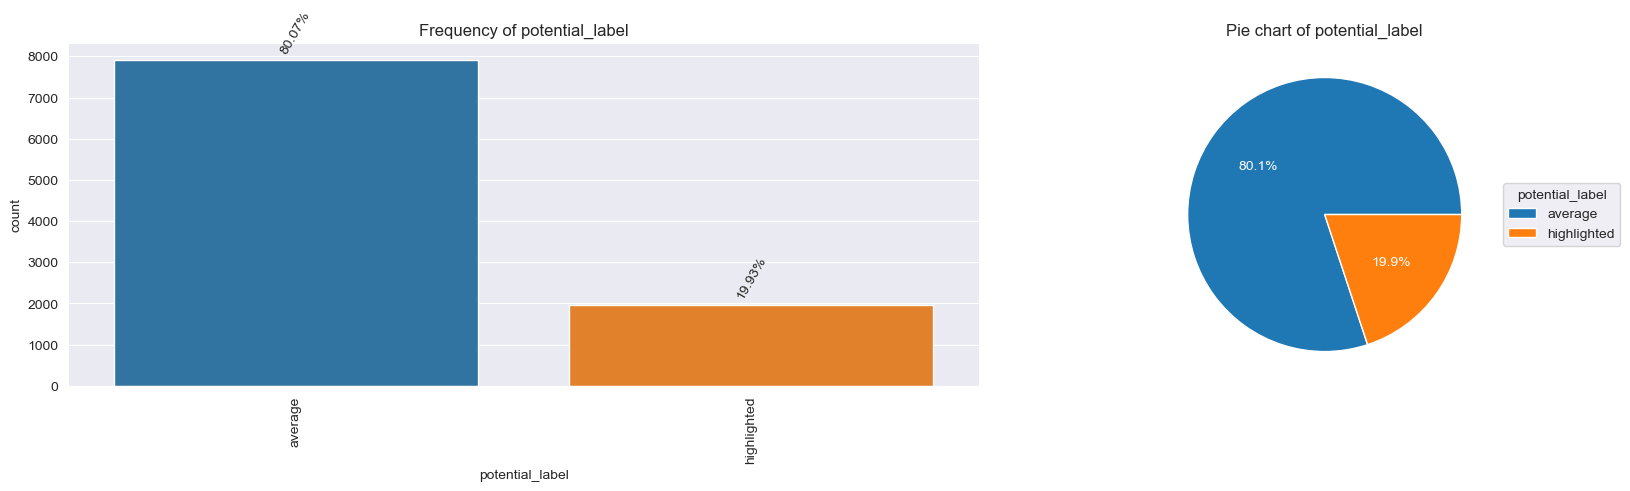

######################### *** #########################
             position_id  Ratio
position_id                    
2                   1972 19.931
6                   1428 14.433
10                  1054 10.653
7                    986  9.966
8                    986  9.966
3                    952  9.622
9                    850  8.591
4                    850  8.591
5                    816  8.247
######################### *** #########################


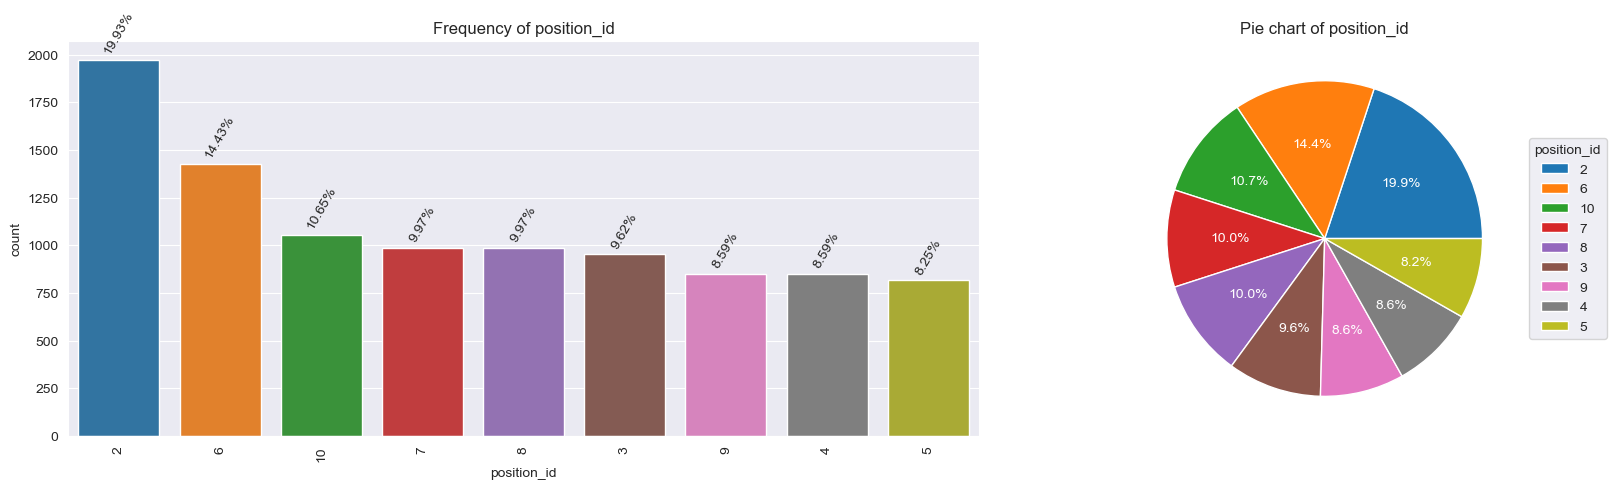

In [18]:
for col in cat_cols:
    cat_summary(df, col, plot=True)

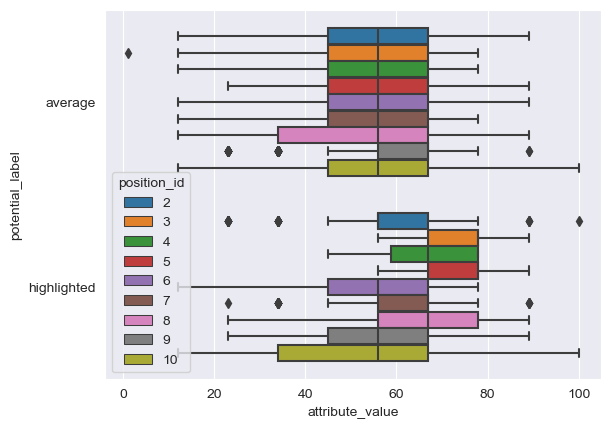

In [19]:
sns.boxplot(data=df, x="attribute_value", y="potential_label", hue="position_id");
plt.show()

In [20]:
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)
    
    if plot:
        fig, axs = plt.subplots(2, 2, figsize=(12, 10))
        
        # Histogram
        plt.subplot(2, 2, 1)
        dataframe[numerical_col].hist(bins=50)
        plt.xlabel(numerical_col)
        plt.title(numerical_col + ' Distribution')
        
        # Boxplot
        plt.subplot(2, 2, 2)
        sns.boxplot(y=numerical_col, data=dataframe)
        plt.title("Boxplot of " + numerical_col)
        plt.xticks(rotation=90)
        
        # Density Plot
        plt.subplot(2, 2, 3)
        sns.kdeplot(dataframe[numerical_col], shade=True)
        plt.xlabel(numerical_col)
        plt.title(numerical_col + ' Density')
        
        # QQ Plot
        plt.subplot(2, 2, 4)
        stats.probplot(dataframe[numerical_col], dist="norm", plot=plt)
        plt.title(numerical_col + ' QQ Plot')
        
        plt.tight_layout()
        plt.show(block=True)   

    print("<-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><->")

count   9894.000
mean    5253.674
std      268.122
min     4915.000
5%      4919.000
10%     4929.000
20%     4970.000
30%     5005.000
40%     5119.000
50%     5162.000
60%     5319.000
70%     5523.000
80%     5579.000
90%     5621.000
95%     5639.000
99%     5642.000
max     5642.000
Name: task_response_id, dtype: float64


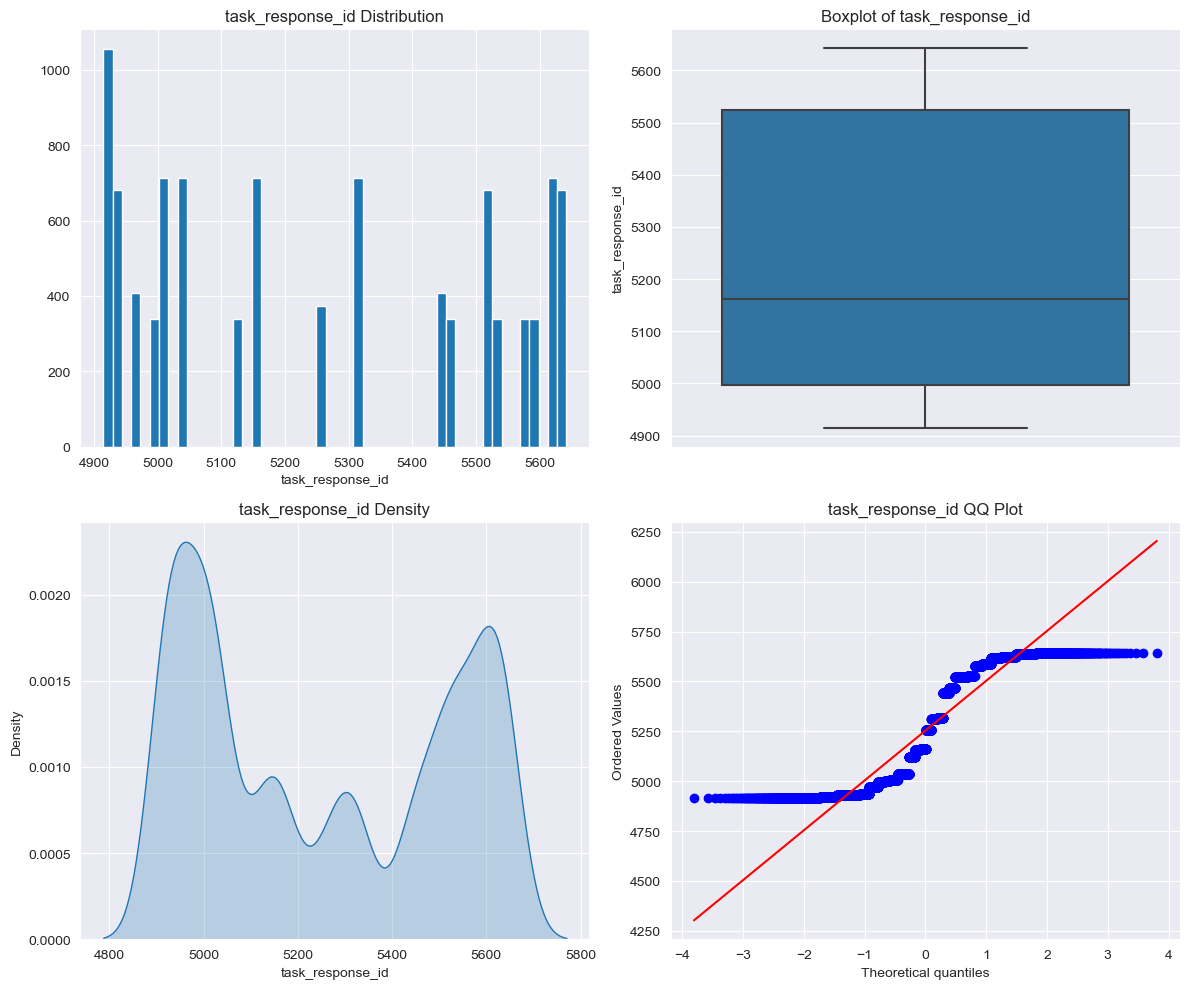

<-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><->
count    9894.000
mean    63199.093
std       666.085
min     60549.000
5%      61923.000
10%     62935.000
20%     62944.000
30%     63032.000
40%     63058.000
50%     63166.000
60%     63406.000
70%     63556.000
80%     63696.000
90%     63930.000
95%     64045.000
99%     64045.000
max     64045.000
Name: match_id, dtype: float64


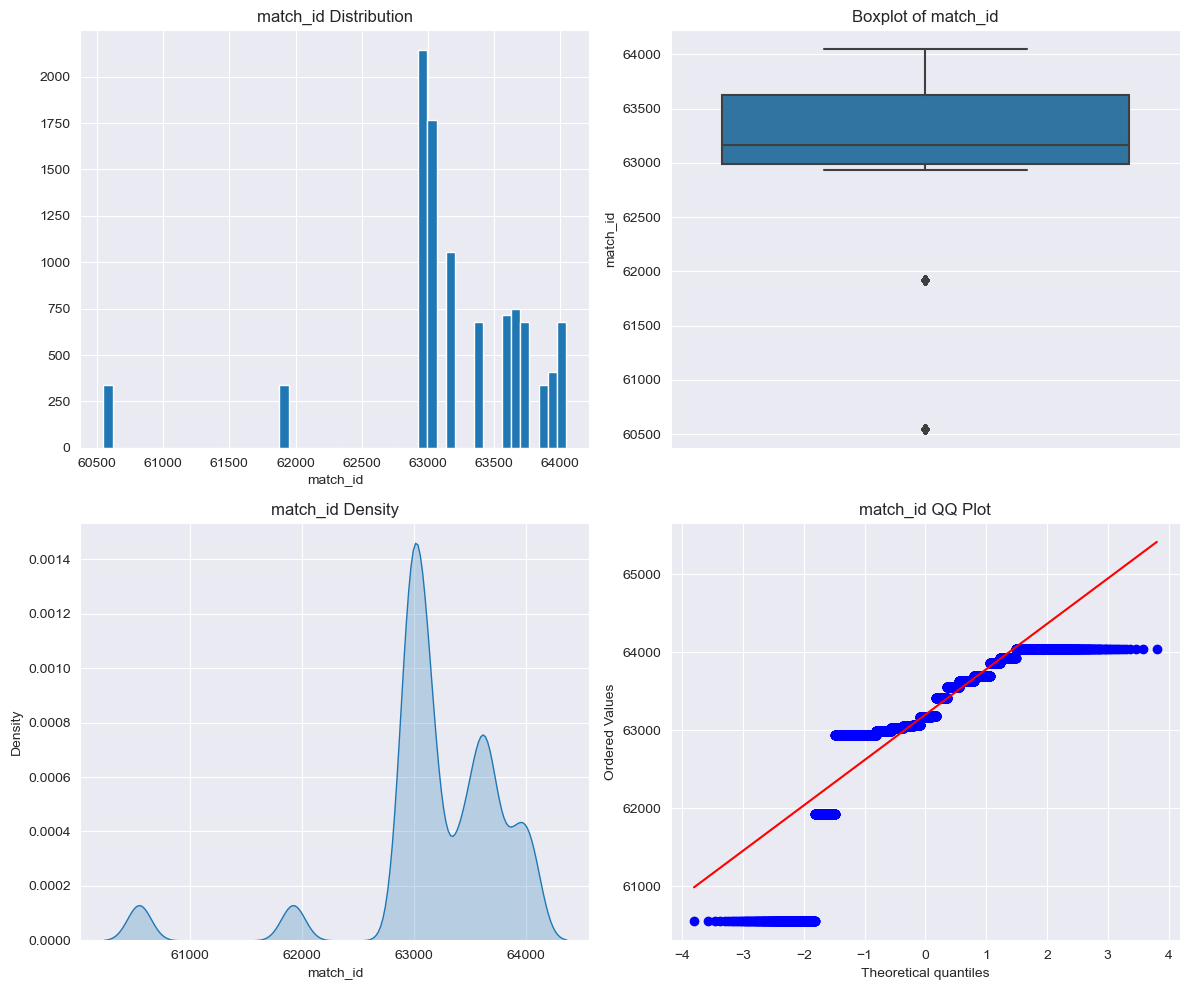

<-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><->
count     9894.000
mean    175284.113
std      43563.191
min     130478.000
5%      132337.000
10%     132337.000
20%     151191.000
30%     151191.000
40%     151191.000
50%     151191.000
60%     160289.000
70%     177676.000
80%     256441.000
90%     256441.000
95%     256441.000
99%     256441.000
max     256441.000
Name: evaluator_id, dtype: float64


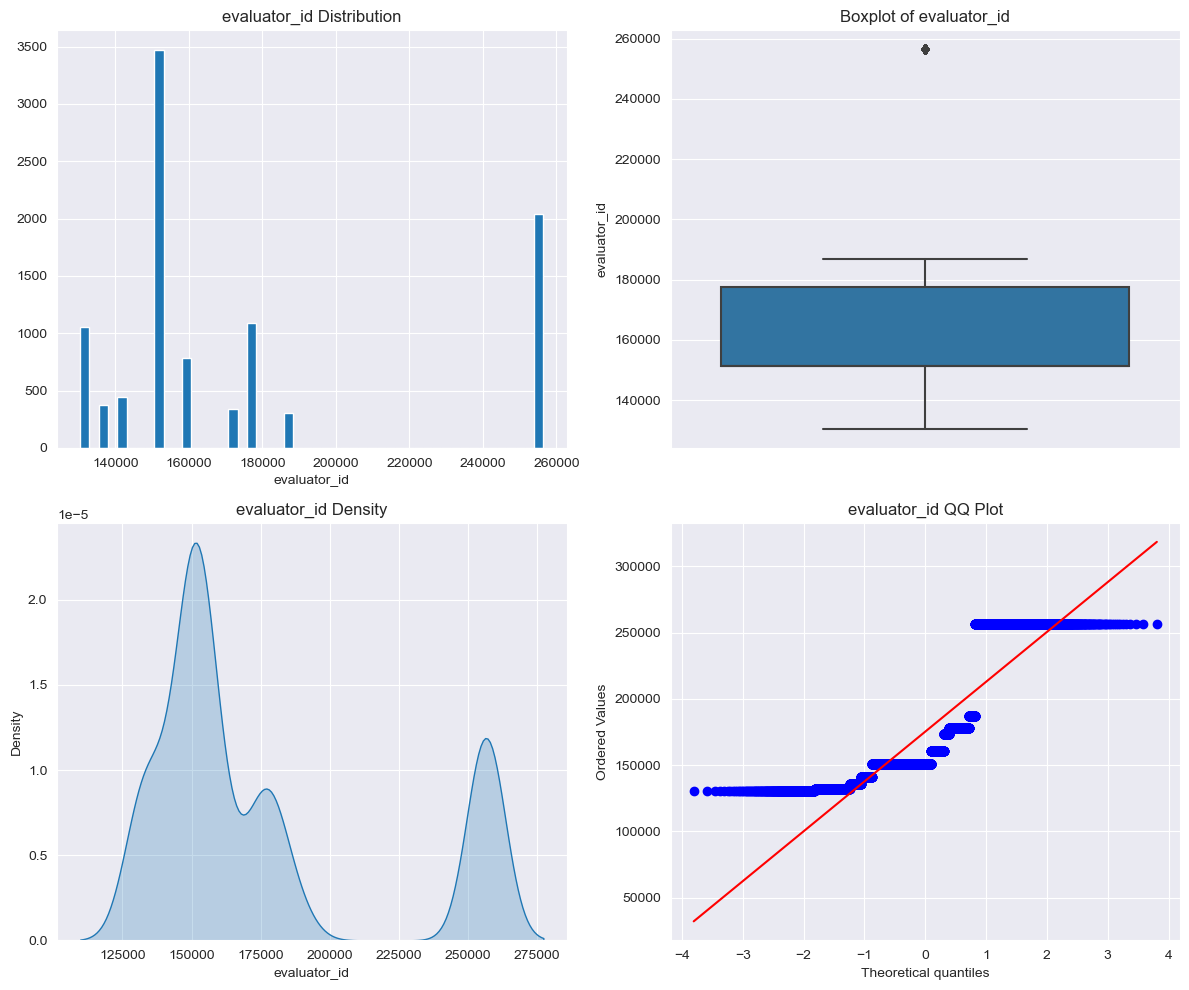

<-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><->
count      9894.000
mean    1528313.031
std      203116.033
min     1355710.000
5%      1359394.000
10%     1361549.000
20%     1367544.000
30%     1369067.000
40%     1370976.000
50%     1372673.000
60%     1450931.000
70%     1717976.000
80%     1785482.000
90%     1818252.000
95%     1863235.000
99%     1909532.000
max     1909728.000
Name: player_id, dtype: float64


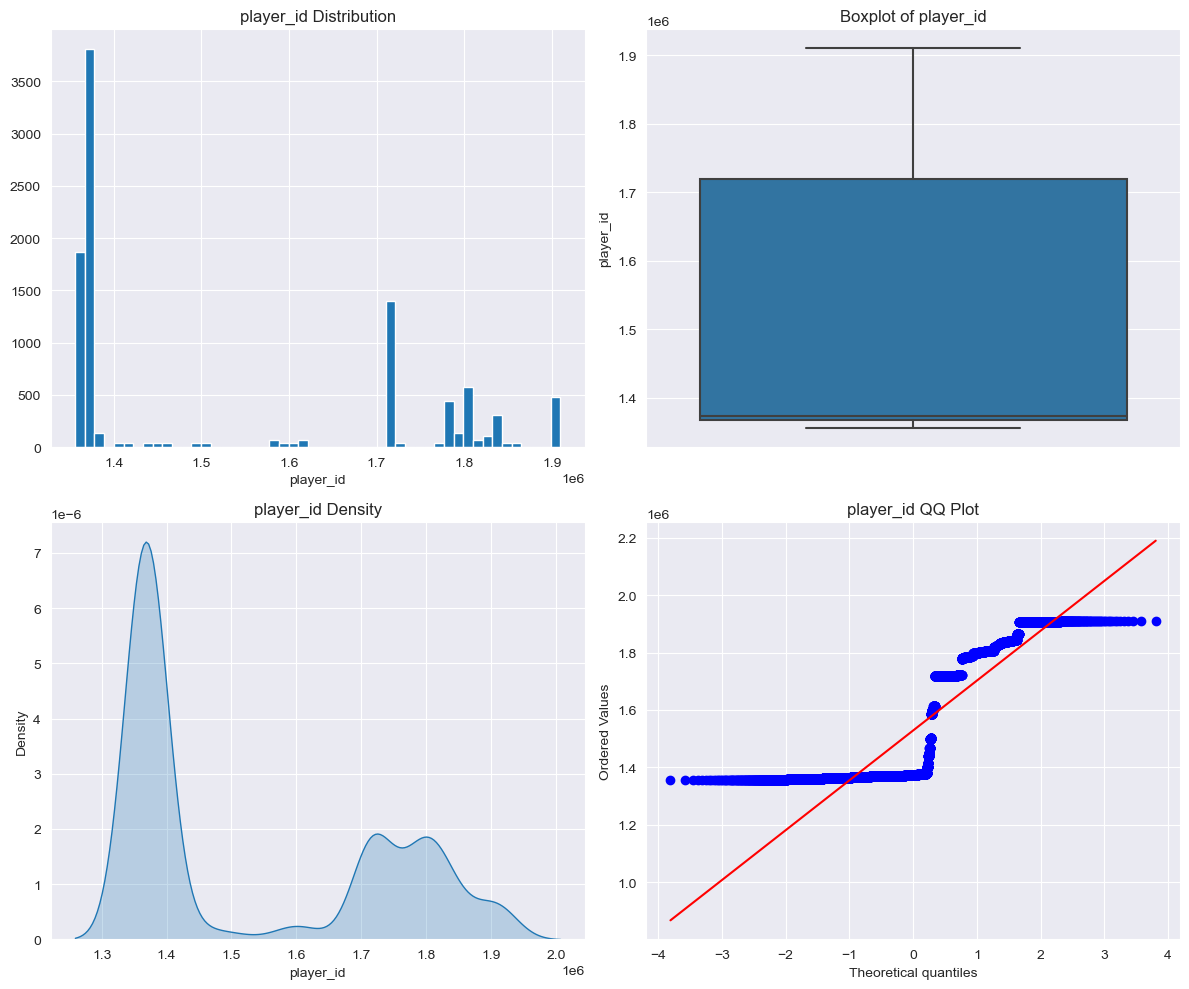

<-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><->
count       9894.000
mean    12822406.069
std         2673.436
min     12818484.000
5%      12818552.000
10%     12818773.000
20%     12819199.000
30%     12819741.000
40%     12821973.000
50%     12822231.000
60%     12823687.000
70%     12825028.000
80%     12825303.000
90%     12825548.000
95%     12825724.000
99%     12825761.000
max     12825763.000
Name: analysis_id, dtype: float64


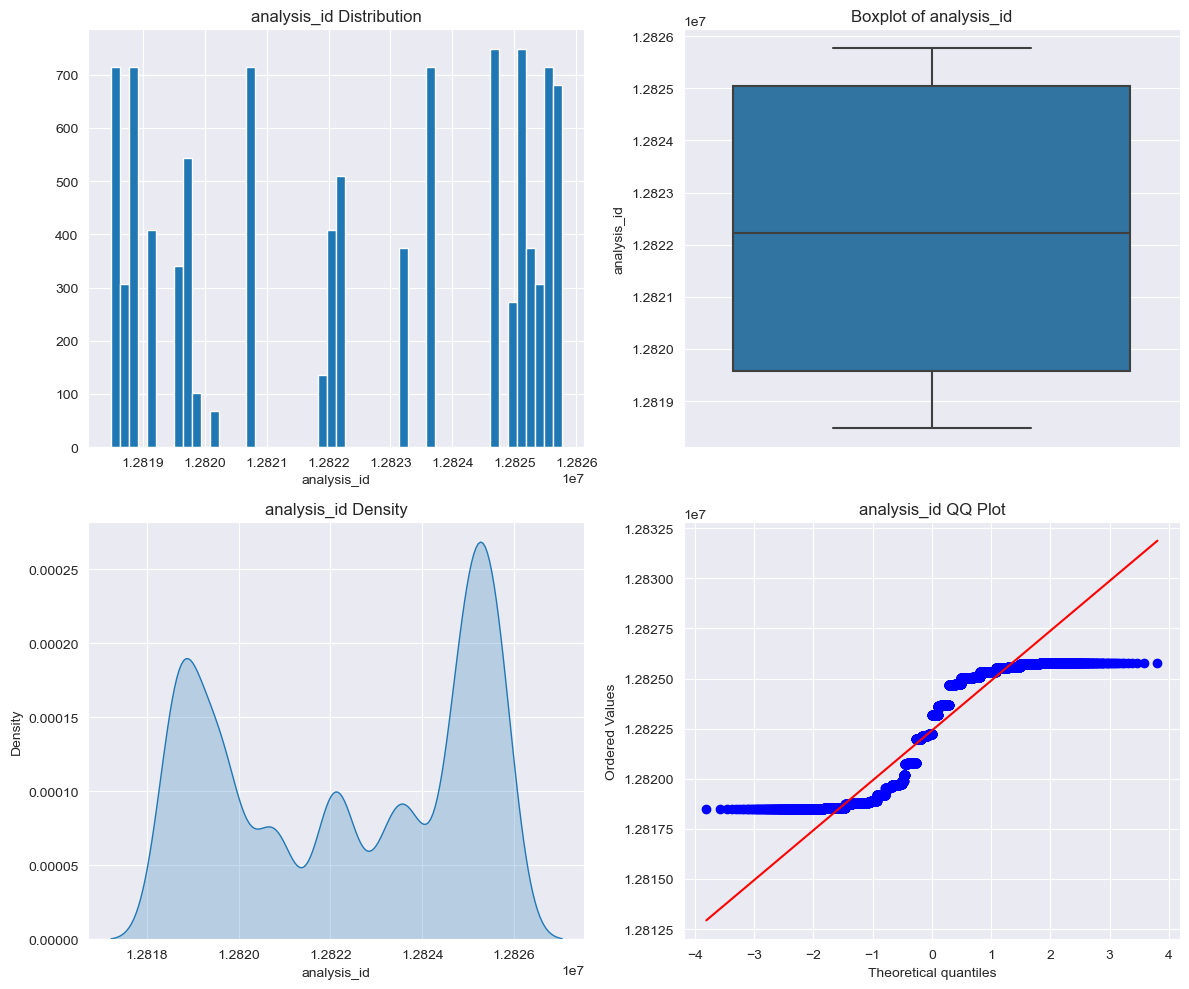

<-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><->
count   9894.000
mean    4348.676
std       26.848
min     4322.000
5%      4323.000
10%     4325.000
20%     4328.000
30%     4333.000
40%     4339.000
50%     4342.500
60%     4348.000
70%     4351.000
80%     4355.000
90%     4407.000
95%     4423.000
99%     4426.000
max     4426.000
Name: attribute_id, dtype: float64


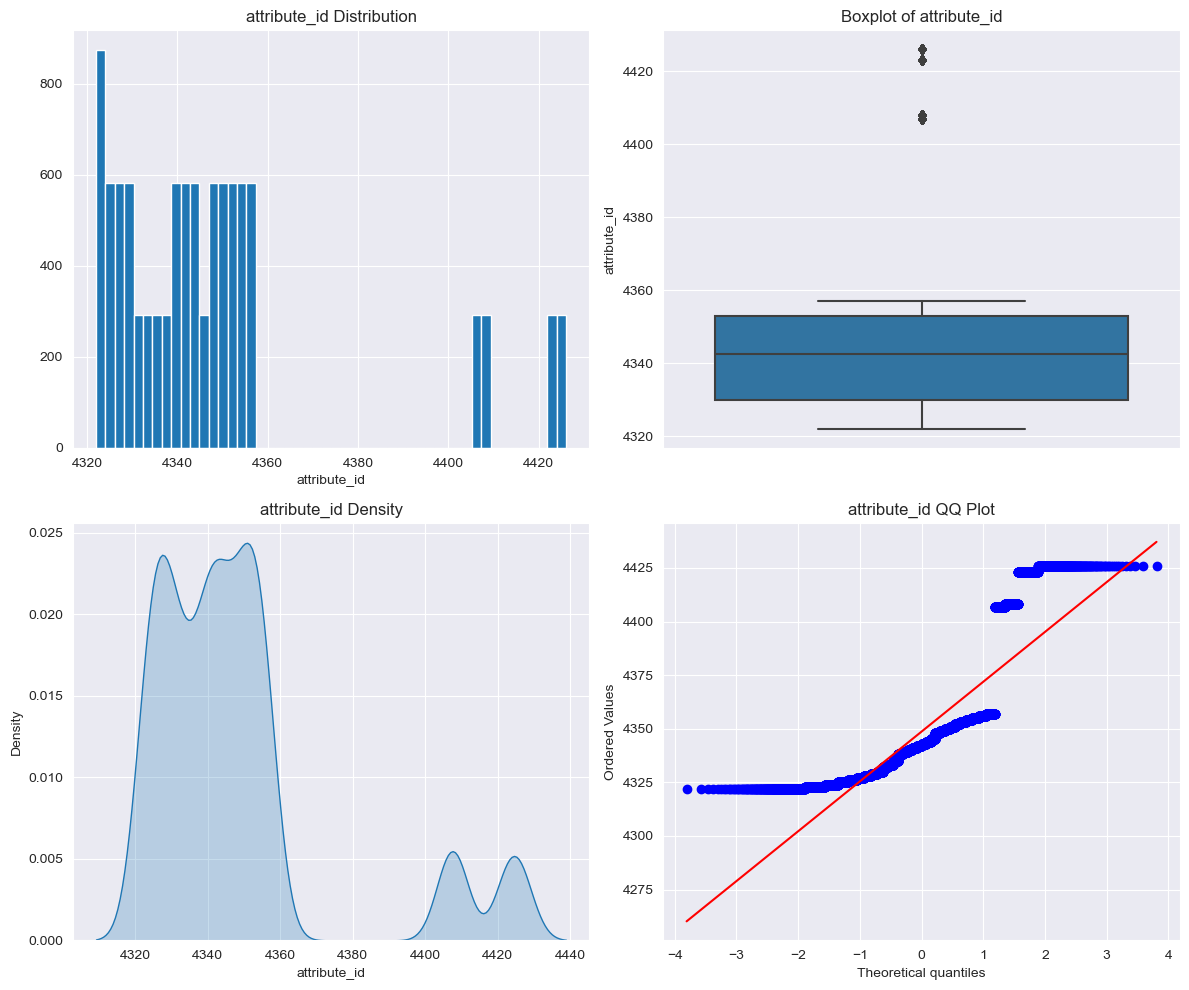

<-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><->
count   9894.000
mean      55.522
std       15.942
min        1.000
5%        23.000
10%       34.000
20%       45.000
30%       45.000
40%       56.000
50%       56.000
60%       67.000
70%       67.000
80%       67.000
90%       78.000
95%       78.000
99%       78.000
max      100.000
Name: attribute_value, dtype: float64


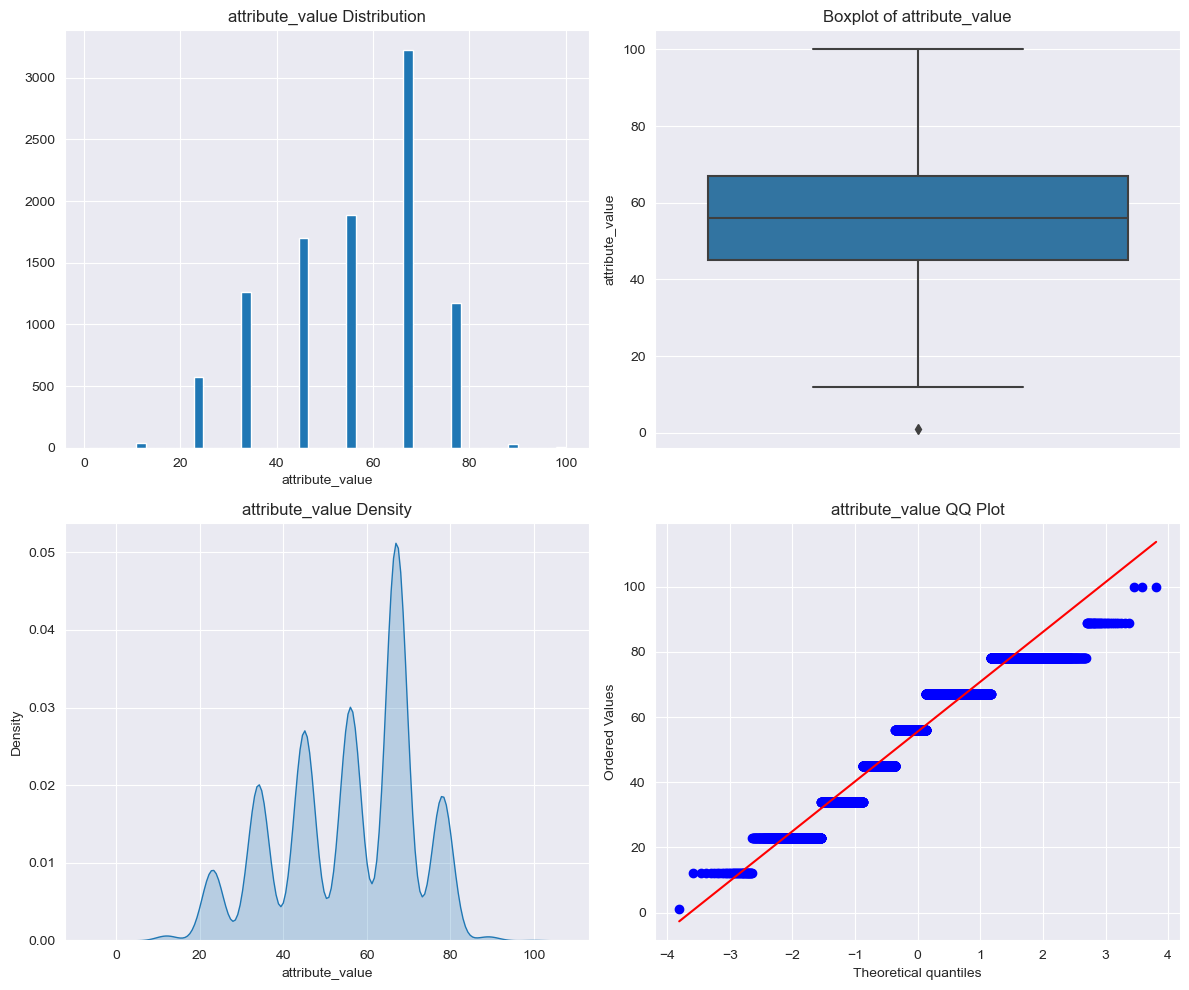

<-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><->


In [21]:
for col in num_cols:
    num_summary(df, col , plot=True)

In [22]:
def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "nunique"}), end="\n\n\n")

In [23]:

for col in num_cols:
    target_summary_with_num(df, "potential_label", col)

                 task_response_id
potential_label                  
average                        29
highlighted                    24


                 match_id
potential_label          
average                17
highlighted            15


                 evaluator_id
potential_label              
average                    10
highlighted                 9


                 player_id
potential_label           
average                209
highlighted             56


                 analysis_id
potential_label             
average                  233
highlighted               58


                 attribute_id
potential_label              
average                    34
highlighted                34


                 attribute_value
potential_label                 
average                       10
highlighted                    9




# PIVOT TABLE

In [26]:
pivot_df = pd.pivot_table(df, values="attribute_value", index=["player_id", "position_id", "potential_label"], columns=["attribute_id"])
pivot_df.head()

attribute_id                            4322   4323   4324   4325   4326  \
player_id position_id potential_label                                      
1355710   7           average         50.500 50.500 34.000 50.500 45.000   
1356362   9           average         67.000 67.000 67.000 67.000 67.000   
1356375   3           average         67.000 67.000 67.000 67.000 67.000   
          4           average         67.000 78.000 67.000 67.000 67.000   
1356411   9           average         67.000 67.000 78.000 78.000 67.000   

attribute_id                            4327   4328   4329   4330   4332  \
player_id position_id potential_label                                      
1355710   7           average         45.000 45.000 45.000 50.500 56.000   
1356362   9           average         67.000 67.000 67.000 67.000 67.000   
1356375   3           average         67.000 67.000 78.000 67.000 67.000   
          4           average         78.000 78.000 78.000 56.000 67.000   
1356411   9           average         67.000 67.000 67.000 89.000 78.000   

attribute_id                            4333   4335   4338   4339   4340  \
player_id position_id potential_label                                      
1355710   7           average         39.500 34.000 39.500 39.500 45.000   
1356362   9           average         67.000 67.000 67.000 67.000 67.000   
1356375   3           average         78.000 56.000 67.000 67.000 67.000   
          4           average         67.000 67.000 78.000 78.000 56.000   
1356411   9           average         67.000 67.000 67.000 56.000 56.000   

attribute_id                            4341   4342   4343   4344   4345  \
player_id position_id potential_label                                      
1355710   7           average         45.000 50.500 28.500 23.000 39.500   
1356362   9           average         67.000 67.000 67.000 56.000 67.000   
1356375   3           average         67.000 67.000 56.000 56.000 67.000   
          4           average         67.000 67.000 45.000 45.000 56.000   
1356411   9           average         67.000 78.000 56.000 56.000 67.000   

attribute_id                            4348   4349   4350   4351   4352  \
player_id position_id potential_label                                      
1355710   7           average         28.500 28.500 45.000 50.500 56.000   
1356362   9           average         67.000 56.000 67.000 67.000 67.000   
1356375   3           average         67.000 56.000 56.000 67.000 67.000   
          4           average         67.000 67.000 67.000 67.000 78.000   
1356411   9           average         56.000 67.000 56.000 67.000 67.000   

attribute_id                            4353   4354   4355   4356   4357  \
player_id position_id potential_label                                      
1355710   7           average         34.000 39.500 50.500 34.000 34.000   
1356362   9           average         67.000 78.000 67.000 67.000 67.000   
1356375   3           average         67.000 78.000 67.000 67.000 67.000   
          4           average         67.000 67.000 67.000 56.000 67.000   
1356411   9           average         56.000 67.000 67.000 56.000 67.000   

attribute_id                            4407   4408   4423   4426  
player_id position_id potential_label                              
1355710   7           average         56.000 34.000 34.000 56.000  
1356362   9           average         67.000 67.000 56.000 78.000  
1356375   3           average         67.000 67.000 56.000 78.000  
          4           average         56.000 67.000 45.000 56.000  
1356411   9           average         89.000 56.000 67.000 78.000

In [29]:
pivot_df = pivot_df.reset_index()
pivot_df.columns = pivot_df.columns.astype(str)
pivot_df.head()

attribute_id  player_id  position_id potential_label   4322   4323   4324  \
0               1355710            7         average 50.500 50.500 34.000   
1               1356362            9         average 67.000 67.000 67.000   
2               1356375            3         average 67.000 67.000 67.000   
3               1356375            4         average 67.000 78.000 67.000   
4               1356411            9         average 67.000 67.000 78.000   

attribute_id   4325   4326   4327   4328   4329   4330   4332   4333   4335  \
0            50.500 45.000 45.000 45.000 45.000 50.500 56.000 39.500 34.000   
1            67.000 67.000 67.000 67.000 67.000 67.000 67.000 67.000 67.000   
2            67.000 67.000 67.000 67.000 78.000 67.000 67.000 78.000 56.000   
3            67.000 67.000 78.000 78.000 78.000 56.000 67.000 67.000 67.000   
4            78.000 67.000 67.000 67.000 67.000 89.000 78.000 67.000 67.000   

attribute_id   4338   4339   4340   4341   4342   4343   4344   4345   4348  \
0            39.500 39.500 45.000 45.000 50.500 28.500 23.000 39.500 28.500   
1            67.000 67.000 67.000 67.000 67.000 67.000 56.000 67.000 67.000   
2            67.000 67.000 67.000 67.000 67.000 56.000 56.000 67.000 67.000   
3            78.000 78.000 56.000 67.000 67.000 45.000 45.000 56.000 67.000   
4            67.000 56.000 56.000 67.000 78.000 56.000 56.000 67.000 56.000   

attribute_id   4349   4350   4351   4352   4353   4354   4355   4356   4357  \
0            28.500 45.000 50.500 56.000 34.000 39.500 50.500 34.000 34.000   
1            56.000 67.000 67.000 67.000 67.000 78.000 67.000 67.000 67.000   
2            56.000 56.000 67.000 67.000 67.000 78.000 67.000 67.000 67.000   
3            67.000 67.000 67.000 78.000 67.000 67.000 67.000 56.000 67.000   
4            67.000 56.000 67.000 67.000 56.000 67.000 67.000 56.000 67.000   

attribute_id   4407   4408   4423   4426  
0            56.000 34.000 34.000 56.000  
1            67.000 67.000 56.000 78.000  
2            67.000 67.000 56.000 78.000  
3            56.000 67.000 45.000 56.000  
4            89.000 56.000 67.000 78.000

In [31]:
cat_cols, num_cols, cat_but_car = grab_col_names(pivot_df)

print("#########")
print("cat cols", cat_cols)
print("num cols" ,num_cols)
print("cat but car cols", cat_but_car)

Observations: 271
Variables: 37
cat_cols: 7
num_cols: 30
cat_but_car: 0
num_but_cat: 6
#########
cat cols ['potential_label', 'position_id', '4324', '4328', '4352', '4357', '4423']
num cols ['player_id', '4322', '4323', '4325', '4326', '4327', '4329', '4330', '4332', '4333', '4335', '4338', '4339', '4340', '4341', '4342', '4343', '4344', '4345', '4348', '4349', '4350', '4351', '4353', '4354', '4355', '4356', '4407', '4408', '4426']
cat but car cols []


# PIVOT TABLE VISUALIZATION

In [32]:
def cat_summary(dataframe, col_name, plot=False):
    summary_df = pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                               "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)})
    print("######################### *** #########################")
    print(summary_df)
    print("######################### *** #########################")
    if plot:
        fig, axs = plt.subplots(1, 2, figsize=(18, 5))
        counts = dataframe[col_name].value_counts()
        ratios = 100 * counts / len(dataframe)
        # Count Plot
        ax = sns.countplot(x=col_name, data=dataframe, ax=axs[0], order=counts.index)
        axs[0].set_title("Frequency of " + col_name)
        axs[0].tick_params(axis='x', rotation=90)
        for i, p in enumerate(ax.patches):
            height = p.get_height()
            ax.text(p.get_x() + p.get_width() / 2., height + 0.01 * max(counts),
                    f'{ratios.iloc[i]:.2f}%', 
                    ha="center", va="bottom",rotation = 60)
        # Pie Chart
        wedges, texts, autotexts = axs[1].pie(x=counts, autopct='%1.1f%%', textprops=dict(color="w"))
        axs[1].set_title("Pie chart of " + col_name)
        # Add legend to pie chart
        axs[1].legend(wedges, counts.index,
                      title=col_name,
                      loc="center left",
                      bbox_to_anchor=(1, 0, 0.5, 1))
        plt.tight_layout()
        plt.show()

######################### *** #########################
                 potential_label  Ratio
potential_label                        
average                      215 79.336
highlighted                   56 20.664
######################### *** #########################


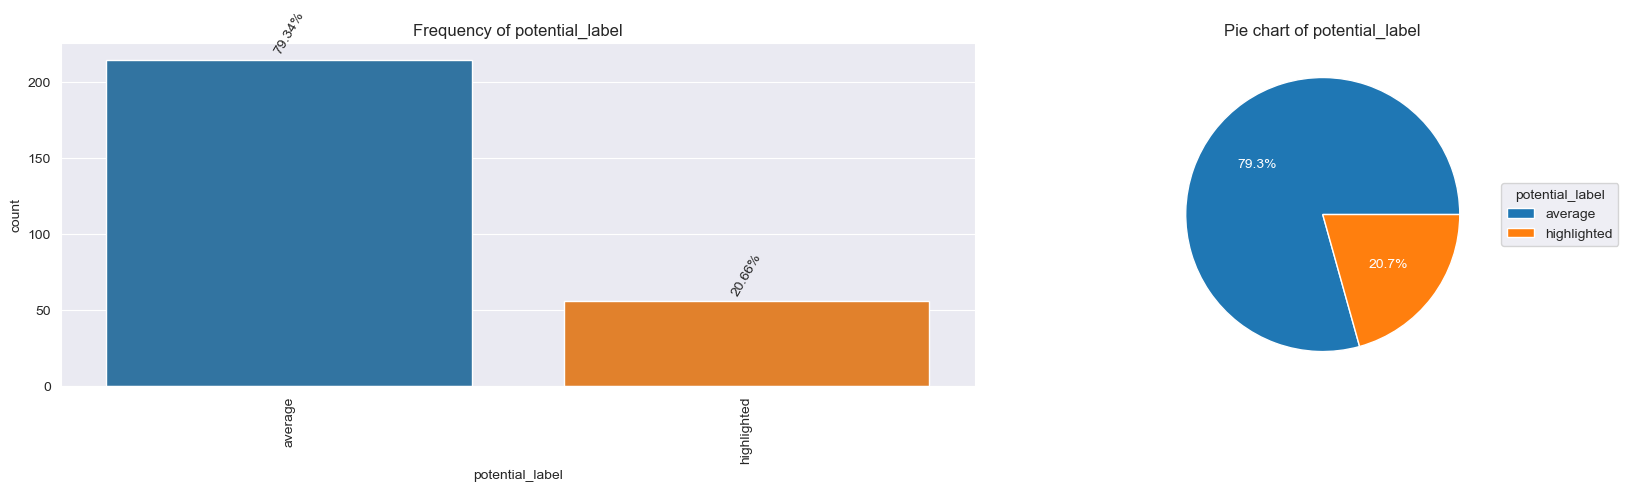

######################### *** #########################
             position_id  Ratio
position_id                    
2                     53 19.557
6                     41 15.129
10                    29 10.701
7                     28 10.332
3                     26  9.594
8                     25  9.225
4                     24  8.856
5                     23  8.487
9                     22  8.118
######################### *** #########################


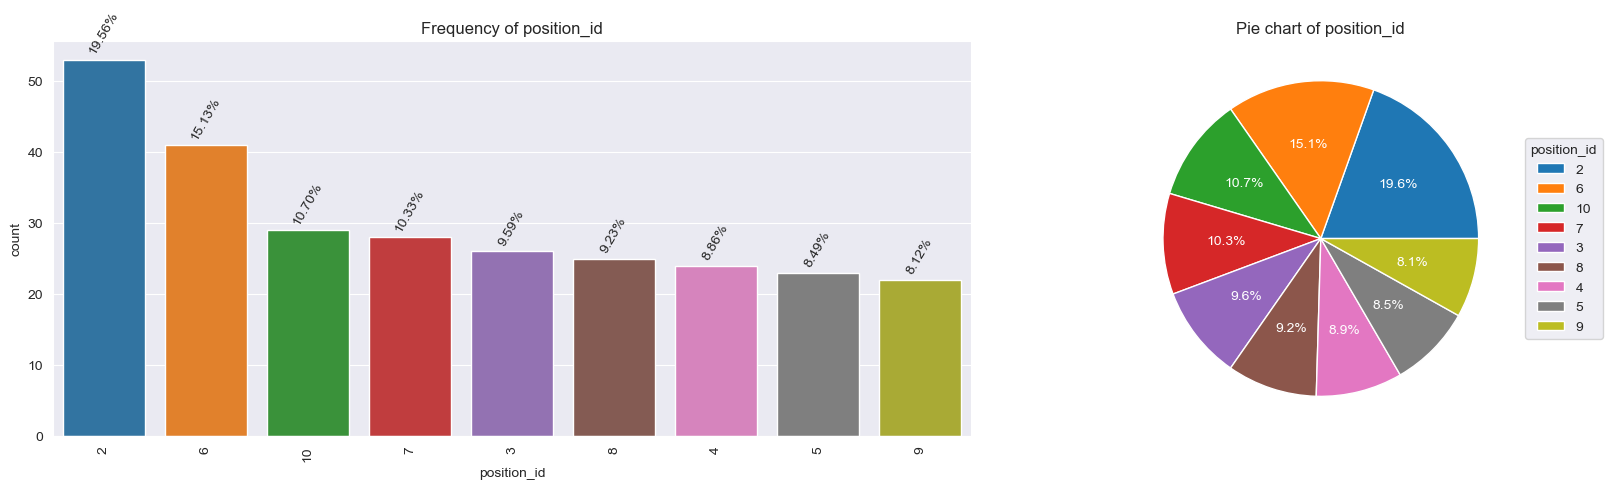

######################### *** #########################
        4324  Ratio
4324               
67.000    93 34.317
34.000    45 16.605
56.000    42 15.498
45.000    39 14.391
78.000    35 12.915
23.000    11  4.059
72.500     4  1.476
41.333     1  0.369
61.500     1  0.369
######################### *** #########################


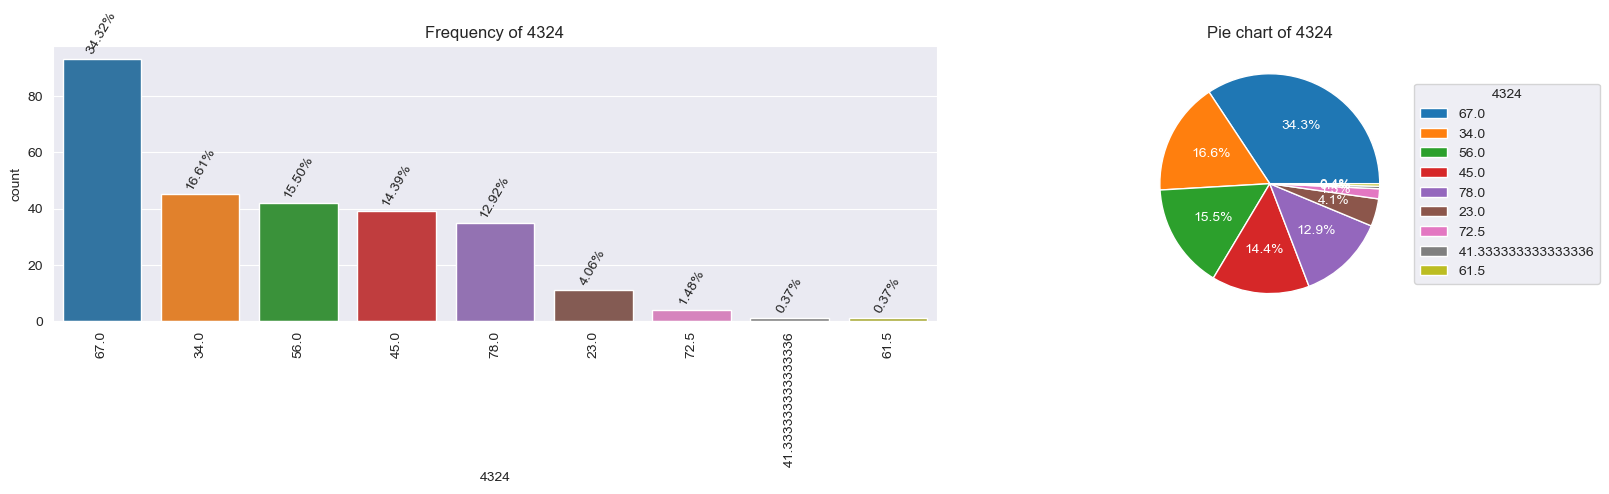

######################### *** #########################
        4328  Ratio
4328               
67.000    85 31.365
45.000    56 20.664
56.000    48 17.712
78.000    44 16.236
34.000    25  9.225
23.000     6  2.214
50.500     3  1.107
72.500     3  1.107
89.000     1  0.369
######################### *** #########################


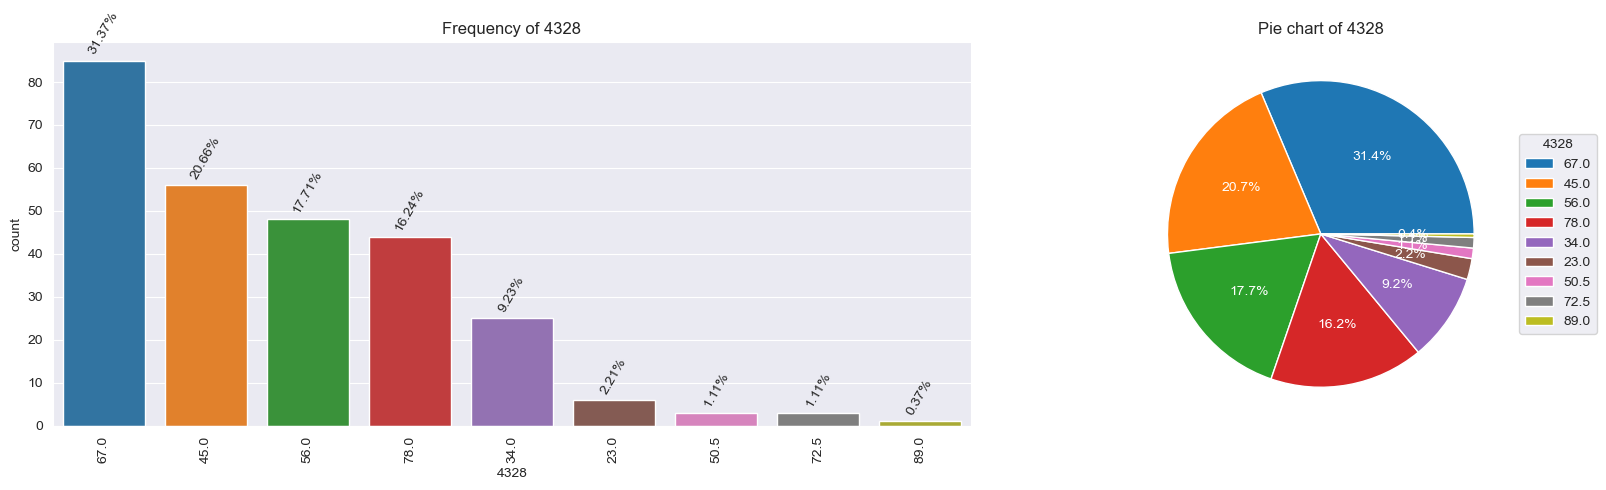

######################### *** #########################
        4352  Ratio
4352               
67.000   112 41.328
56.000    56 20.664
45.000    44 16.236
34.000    30 11.070
78.000    13  4.797
23.000    12  4.428
61.500     3  1.107
12.000     1  0.369
######################### *** #########################


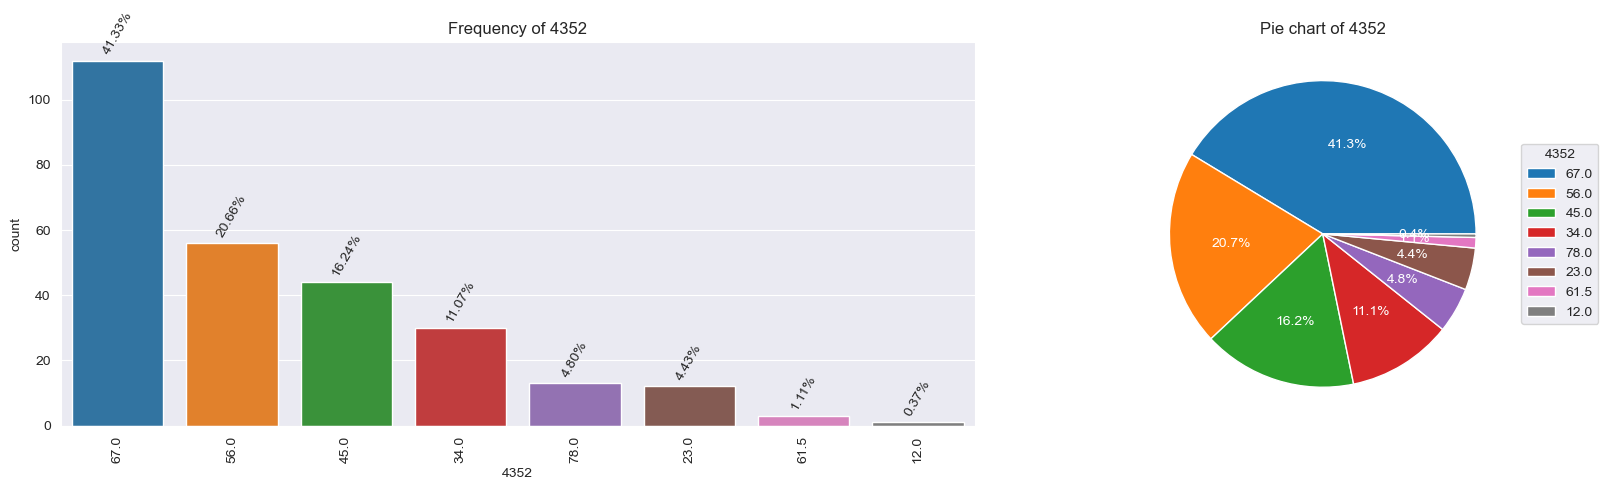

######################### *** #########################
        4357  Ratio
4357               
67.000   123 45.387
45.000    56 20.664
56.000    33 12.177
34.000    30 11.070
78.000    13  4.797
23.000    12  4.428
72.500     2  0.738
50.500     1  0.369
39.500     1  0.369
######################### *** #########################


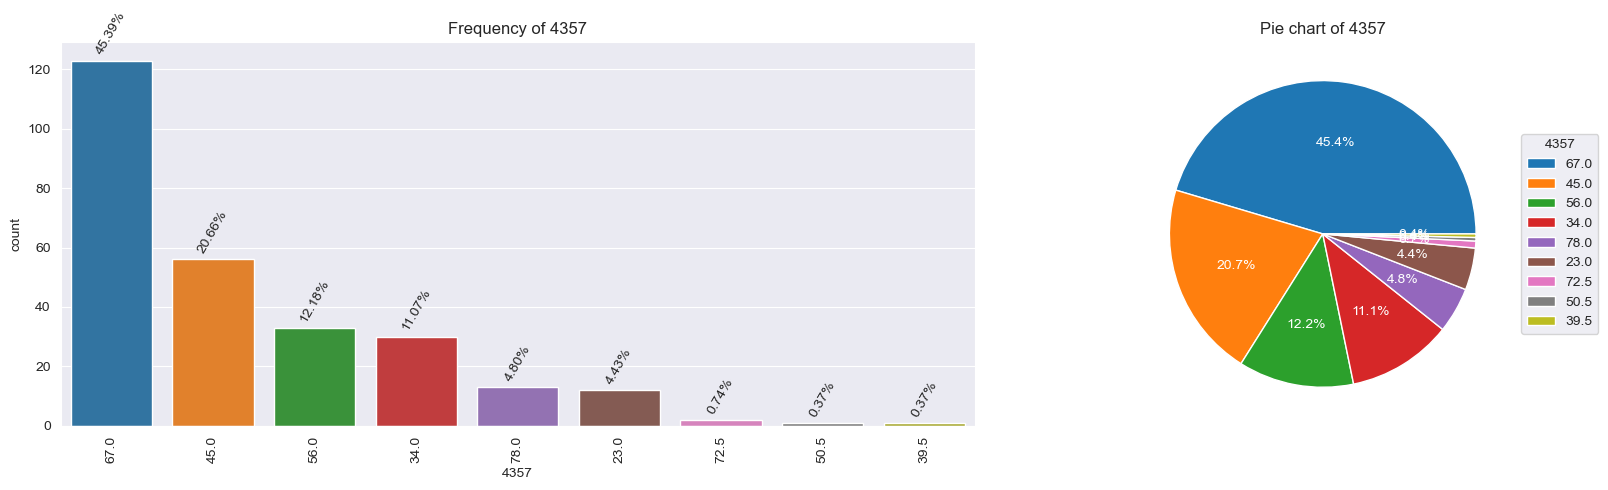

######################### *** #########################
        4423  Ratio
4423               
67.000    85 31.365
34.000    66 24.354
56.000    42 15.498
45.000    36 13.284
23.000    30 11.070
78.000     6  2.214
61.500     4  1.476
39.500     1  0.369
50.500     1  0.369
######################### *** #########################


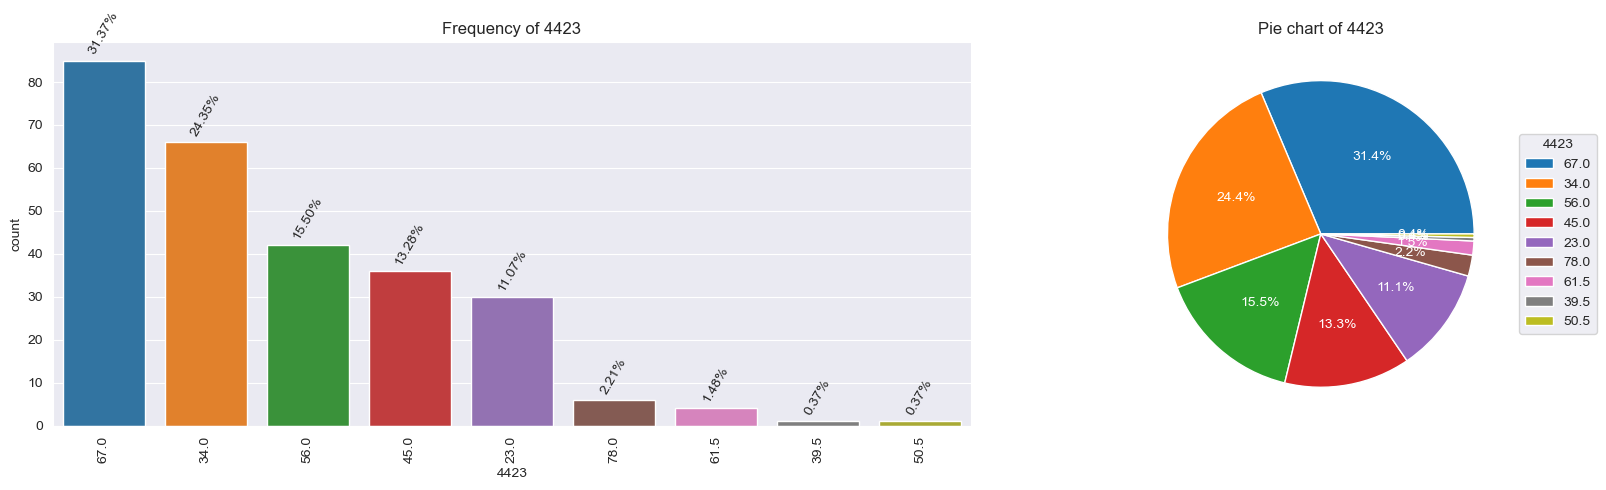

In [33]:
for col in cat_cols:
    cat_summary(pivot_df, col, plot=True)

In [34]:
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)
    
    if plot:
        fig, axs = plt.subplots(2, 2, figsize=(12, 10))
        
        # Histogram
        plt.subplot(2, 2, 1)
        dataframe[numerical_col].hist(bins=50)
        plt.xlabel(numerical_col)
        plt.title(numerical_col + ' Distribution')
        
        # Boxplot
        plt.subplot(2, 2, 2)
        sns.boxplot(y=numerical_col, data=dataframe)
        plt.title("Boxplot of " + numerical_col)
        plt.xticks(rotation=90)
        
        # Density Plot
        plt.subplot(2, 2, 3)
        sns.kdeplot(dataframe[numerical_col], shade=True)
        plt.xlabel(numerical_col)
        plt.title(numerical_col + ' Density')
        
        # QQ Plot
        plt.subplot(2, 2, 4)
        stats.probplot(dataframe[numerical_col], dist="norm", plot=plt)
        plt.title(numerical_col + ' QQ Plot')
        
        plt.tight_layout()
        plt.show(block=True)   

    print("<-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><->")

count       271.000
mean    1538154.742
std      204999.321
min     1355710.000
5%      1359396.000
10%     1361549.000
20%     1367596.000
30%     1369198.000
40%     1371149.000
50%     1373419.000
60%     1599652.000
70%     1717981.000
80%     1785962.000
90%     1818318.000
95%     1854102.000
99%     1908002.500
max     1909728.000
Name: player_id, dtype: float64


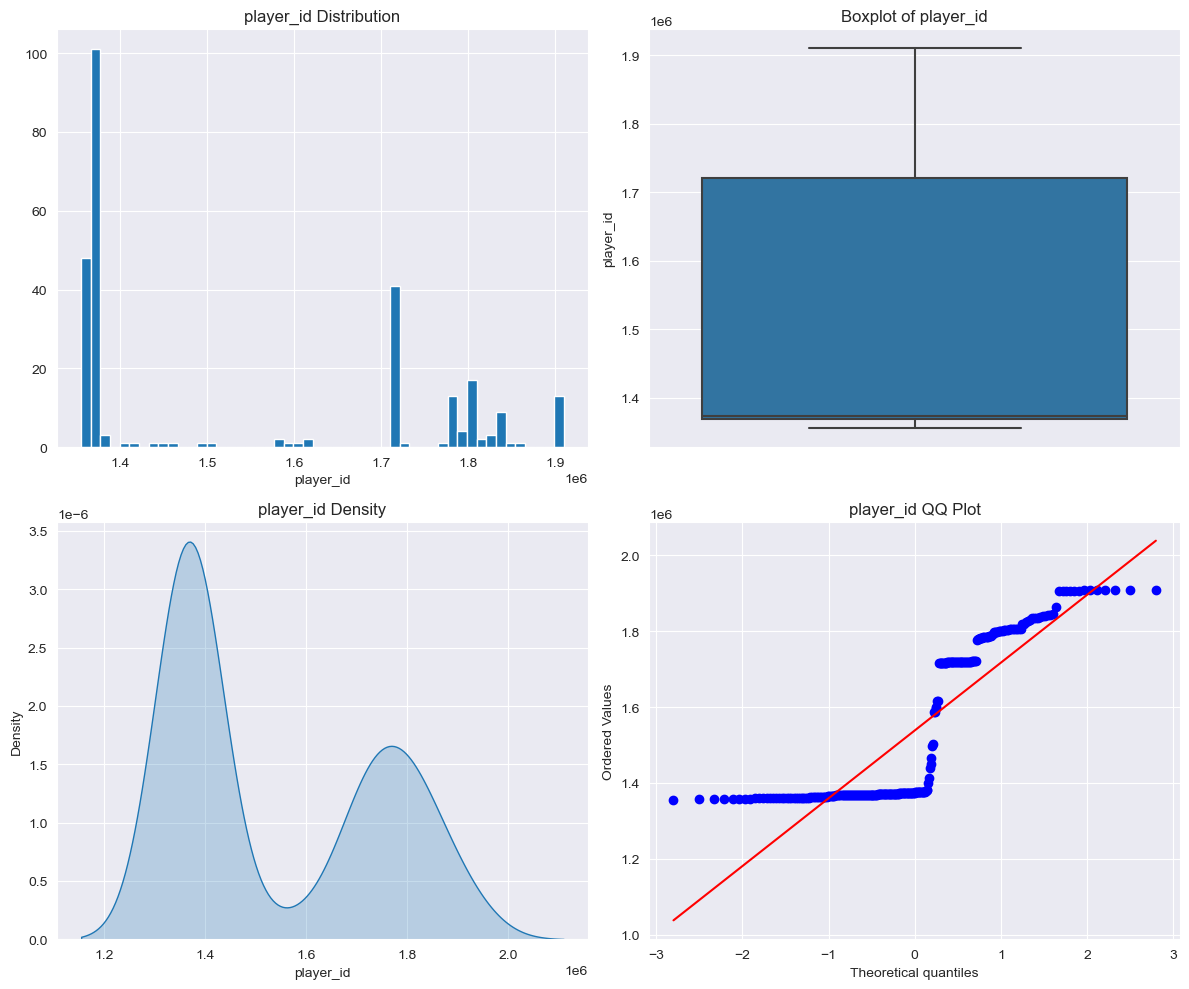

<-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><->
count   271.000
mean     58.368
std      14.527
min      23.000
5%       34.000
10%      34.000
20%      45.000
30%      56.000
40%      56.000
50%      56.000
60%      67.000
70%      67.000
80%      67.000
90%      78.000
95%      78.000
99%      78.000
max      89.000
Name: 4322, dtype: float64


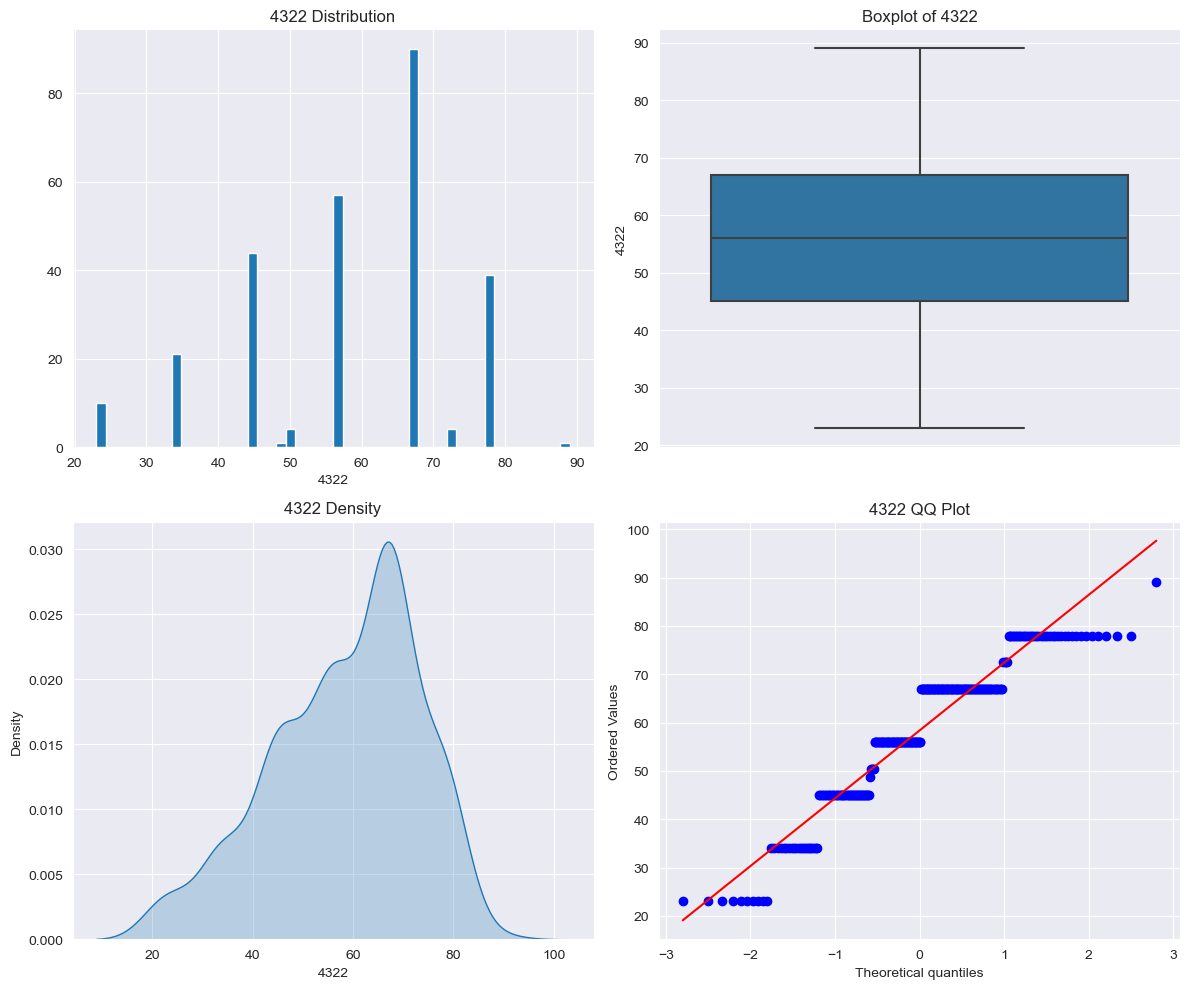

<-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><->
count   271.000
mean     58.740
std      14.757
min      23.000
5%       34.000
10%      34.000
20%      45.000
30%      45.000
40%      56.000
50%      56.000
60%      67.000
70%      67.000
80%      72.500
90%      78.000
95%      78.000
99%      78.000
max      89.000
Name: 4323, dtype: float64


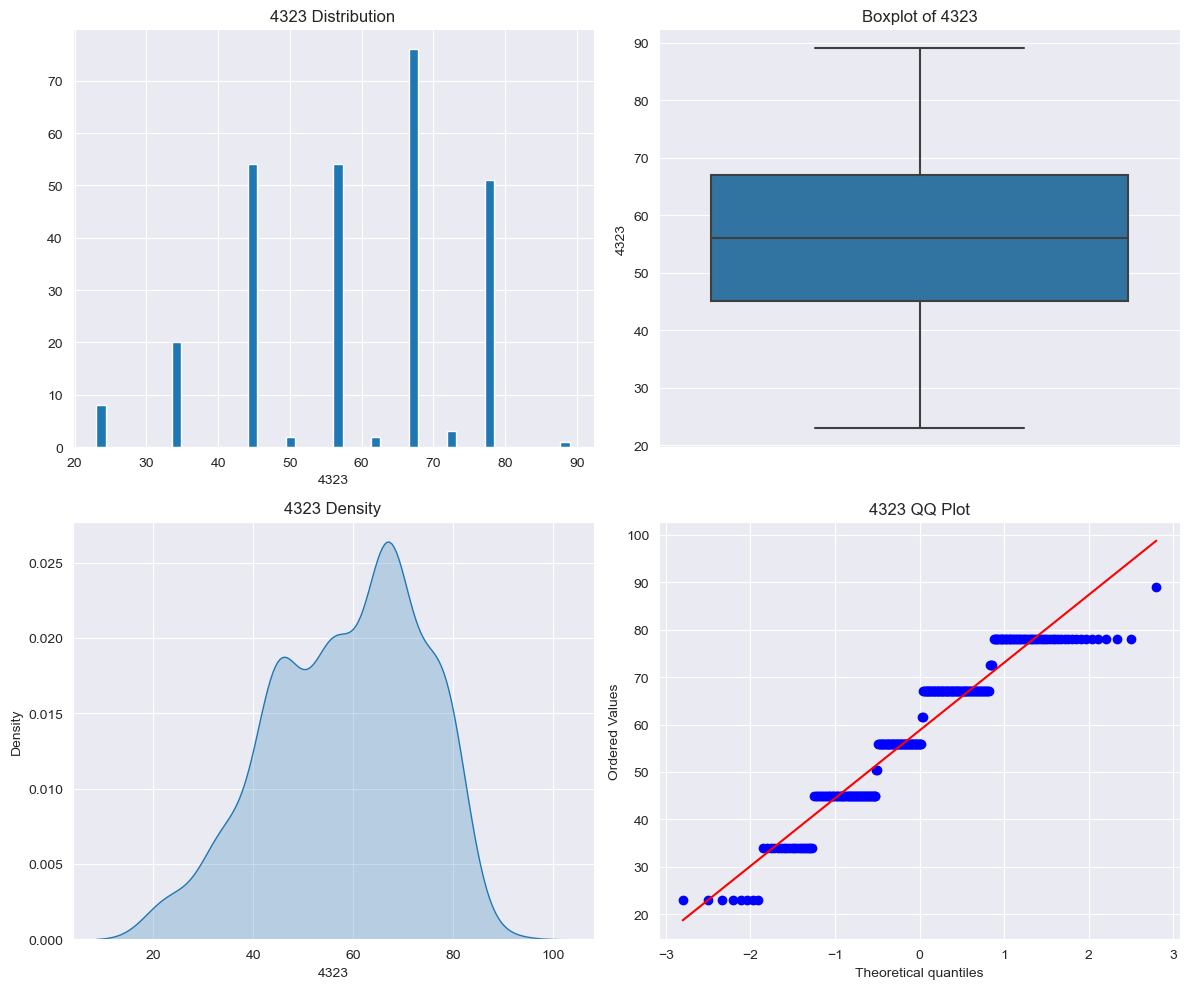

<-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><->
count   271.000
mean     56.947
std      14.749
min      12.000
5%       34.000
10%      34.000
20%      45.000
30%      45.000
40%      56.000
50%      61.500
60%      67.000
70%      67.000
80%      67.000
90%      78.000
95%      78.000
99%      78.000
max      89.000
Name: 4325, dtype: float64


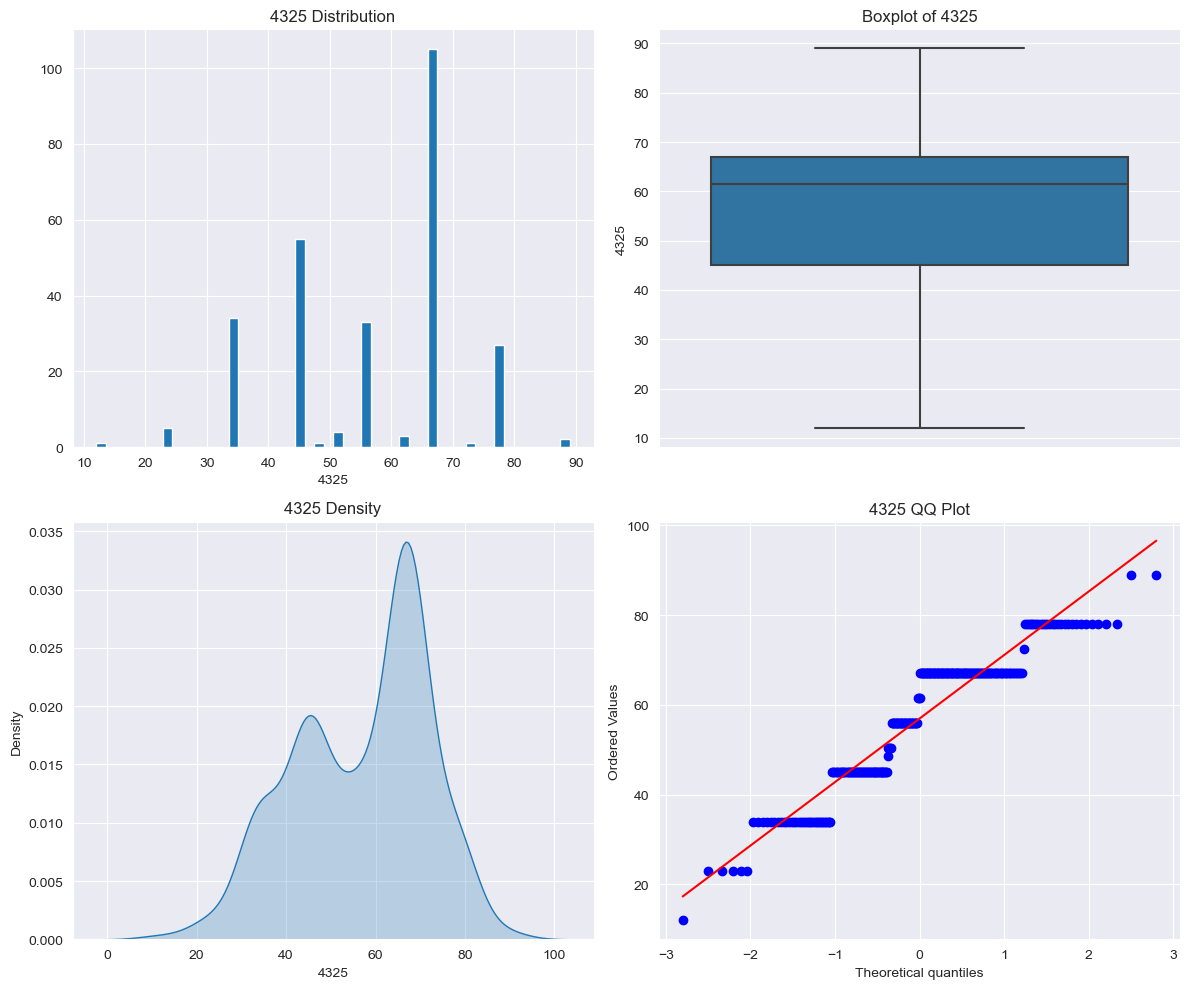

<-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><->
count   271.000
mean     56.325
std      14.800
min      23.000
5%       34.000
10%      34.000
20%      45.000
30%      45.000
40%      56.000
50%      61.500
60%      67.000
70%      67.000
80%      67.000
90%      67.000
95%      78.000
99%      78.000
max      89.000
Name: 4326, dtype: float64


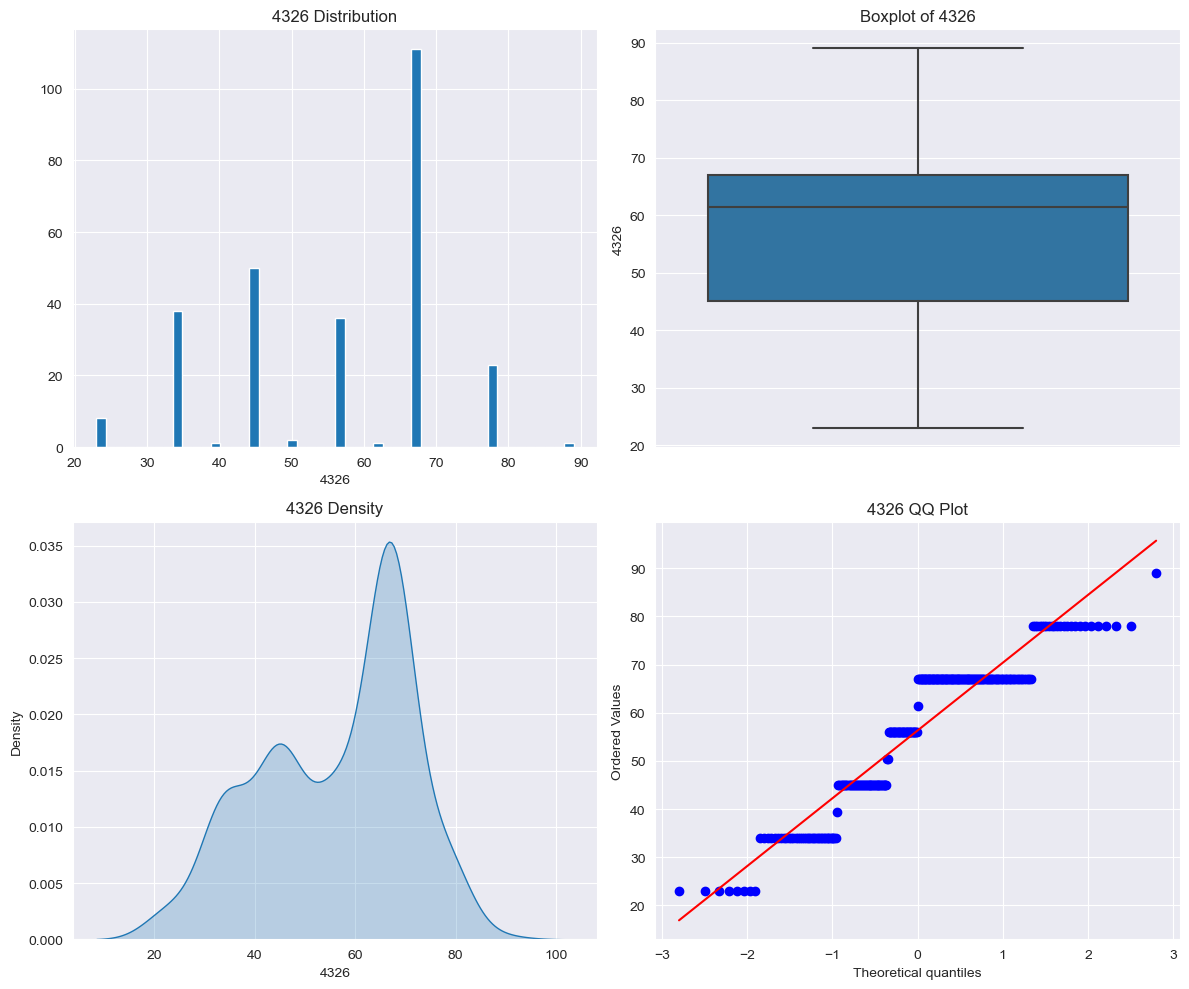

<-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><->
count   271.000
mean     56.521
std      14.522
min      23.000
5%       34.000
10%      34.000
20%      45.000
30%      45.000
40%      56.000
50%      56.000
60%      67.000
70%      67.000
80%      67.000
90%      78.000
95%      78.000
99%      78.000
max      78.000
Name: 4327, dtype: float64


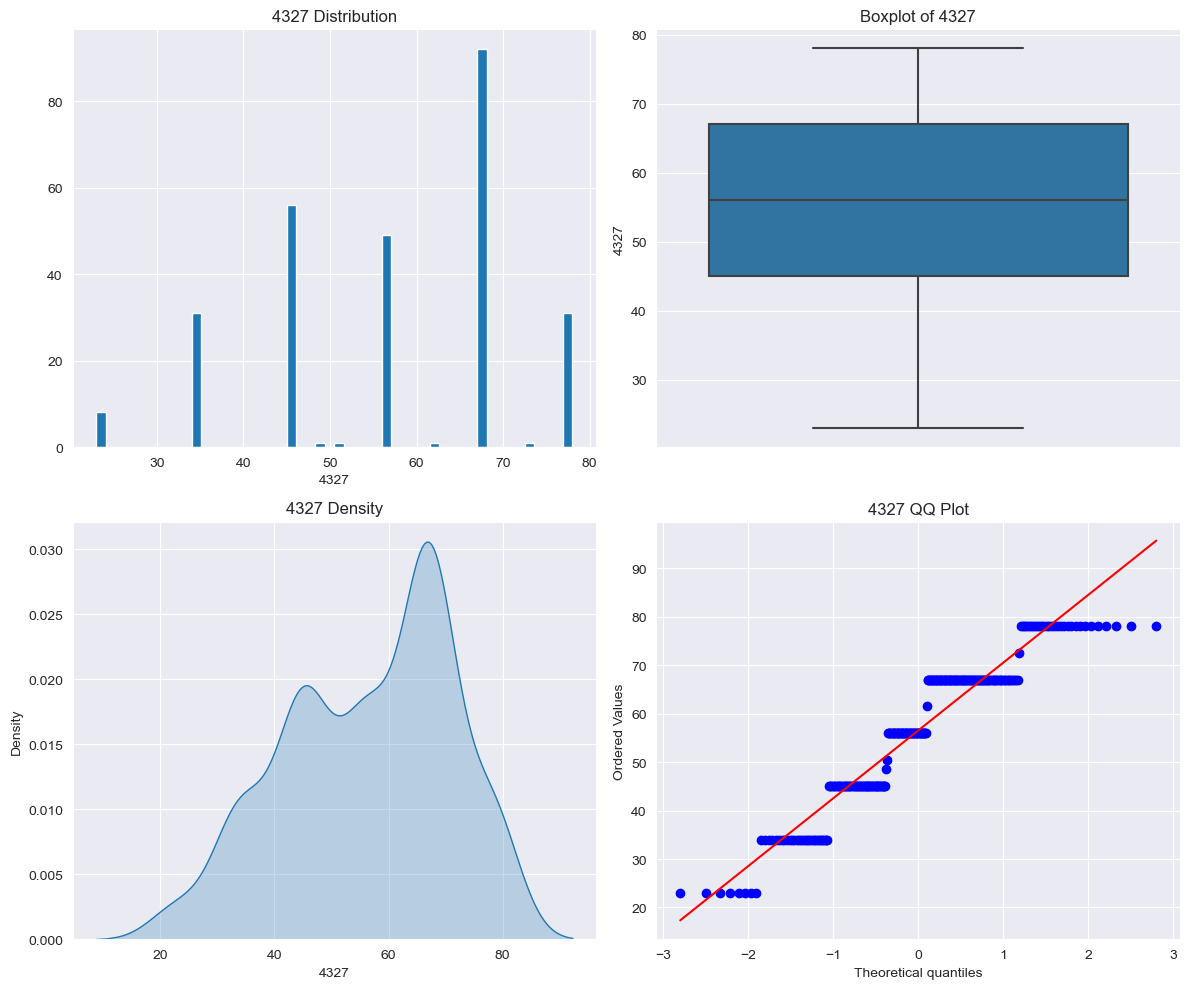

<-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><->
count   271.000
mean     59.565
std      18.434
min      12.000
5%       23.000
10%      34.000
20%      45.000
30%      45.000
40%      56.000
50%      67.000
60%      67.000
70%      78.000
80%      78.000
90%      78.000
95%      78.000
99%      78.000
max      89.000
Name: 4329, dtype: float64


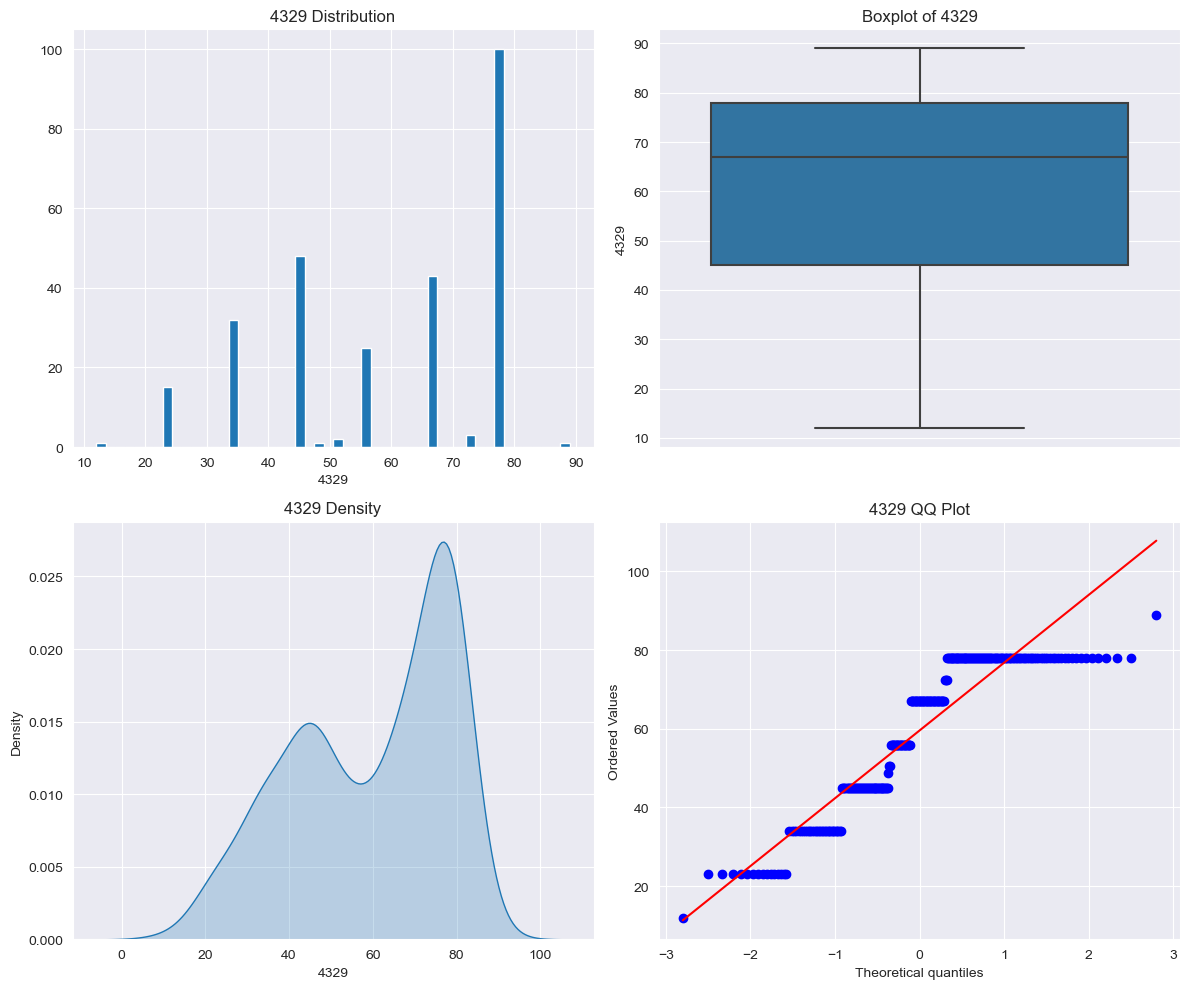

<-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><->
count   271.000
mean     56.771
std      14.077
min      23.000
5%       34.000
10%      34.000
20%      45.000
30%      56.000
40%      56.000
50%      61.500
60%      67.000
70%      67.000
80%      67.000
90%      67.000
95%      72.500
99%      78.000
max      89.000
Name: 4330, dtype: float64


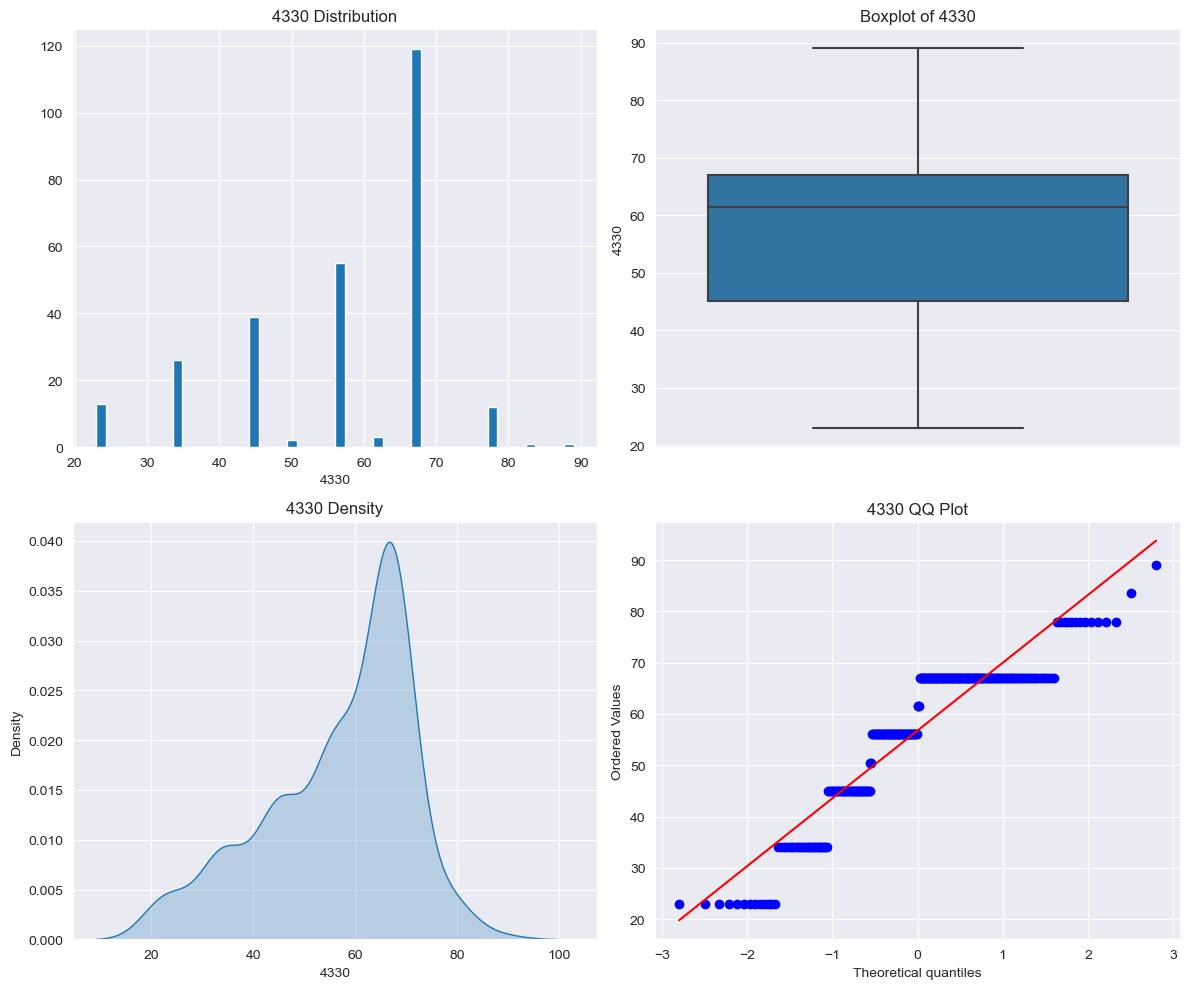

<-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><->
count   271.000
mean     57.657
std      13.542
min      23.000
5%       34.000
10%      34.000
20%      45.000
30%      56.000
40%      56.000
50%      61.500
60%      67.000
70%      67.000
80%      67.000
90%      67.000
95%      78.000
99%      78.000
max      89.000
Name: 4332, dtype: float64


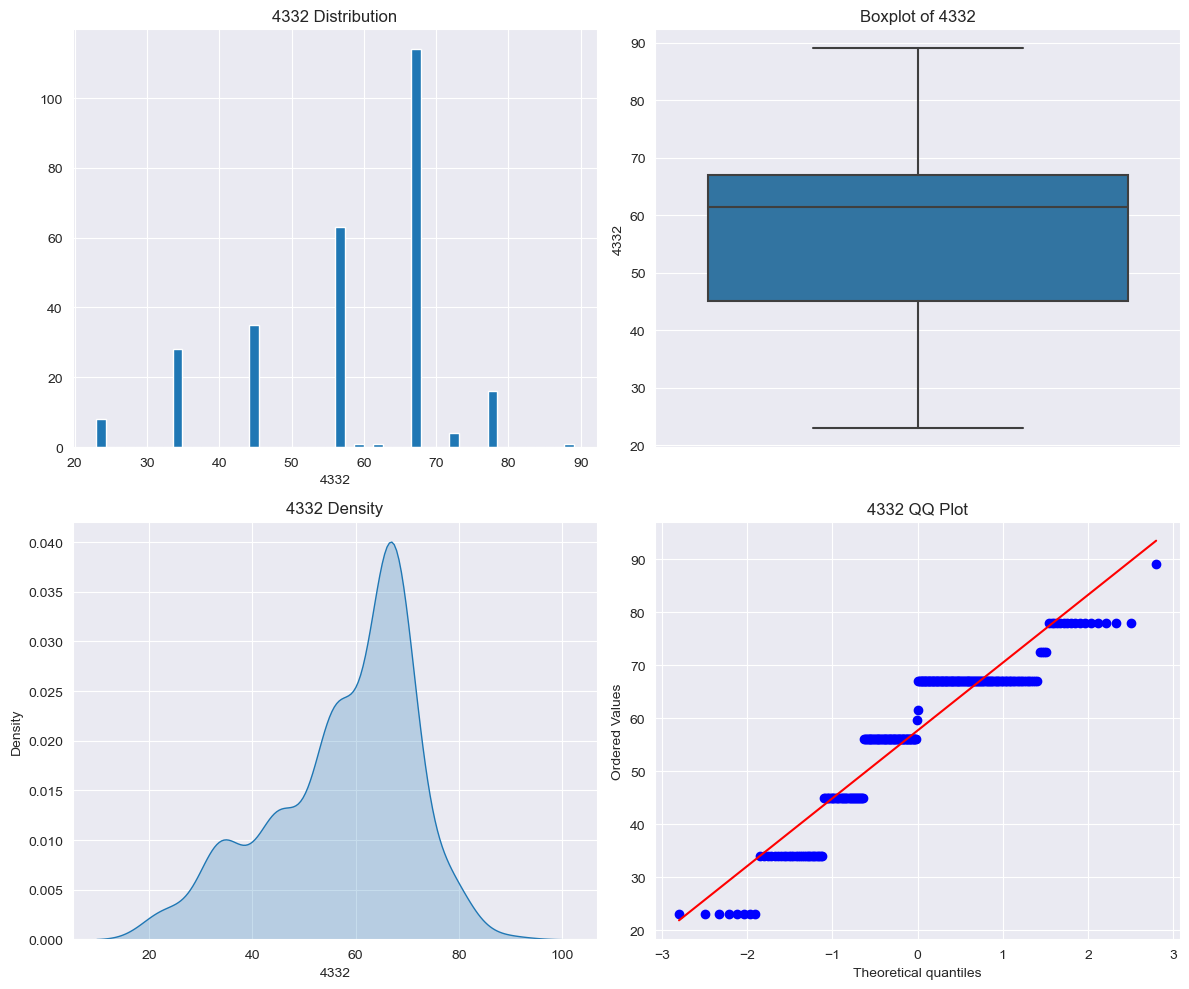

<-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><->
count   271.000
mean     59.498
std      16.370
min      23.000
5%       34.000
10%      34.000
20%      45.000
30%      56.000
40%      56.000
50%      67.000
60%      67.000
70%      72.500
80%      78.000
90%      78.000
95%      78.000
99%      78.000
max      78.000
Name: 4333, dtype: float64


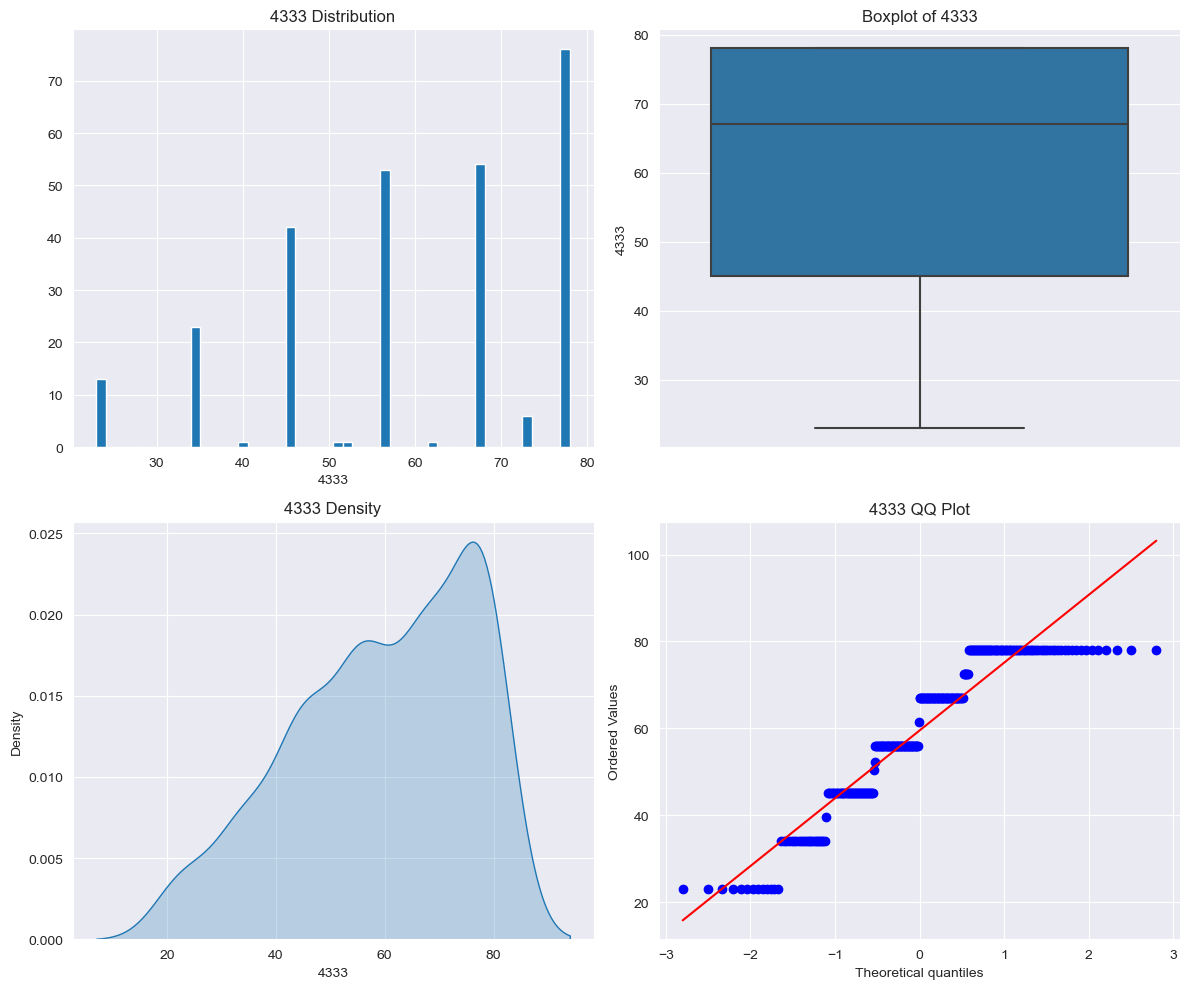

<-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><->
count   271.000
mean     50.818
std      16.269
min      12.000
5%       23.000
10%      34.000
20%      34.000
30%      34.000
40%      45.000
50%      56.000
60%      56.000
70%      67.000
80%      67.000
90%      67.000
95%      67.000
99%      78.000
max      89.000
Name: 4335, dtype: float64


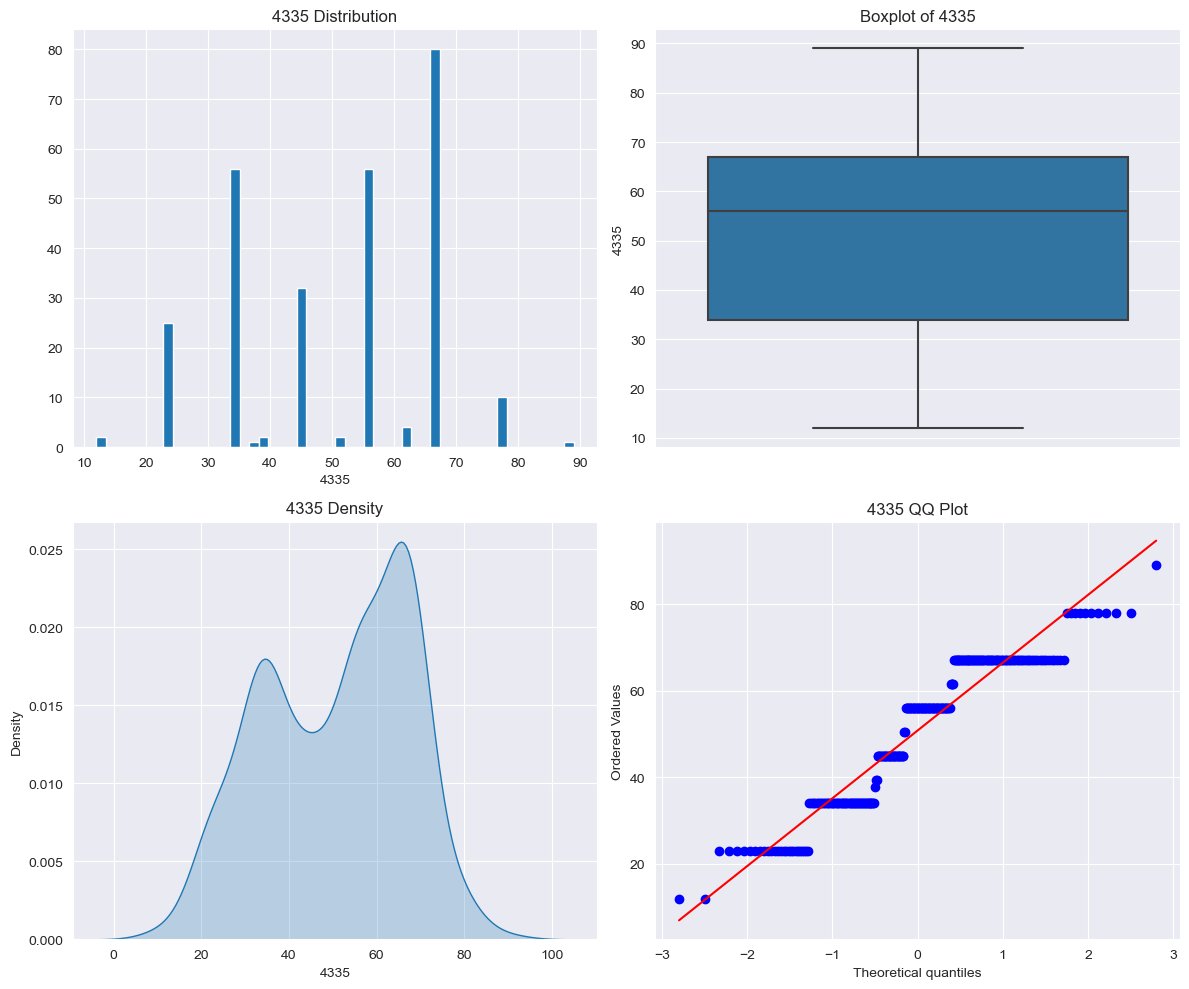

<-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><->
count   271.000
mean     57.116
std      15.671
min      23.000
5%       34.000
10%      34.000
20%      45.000
30%      45.000
40%      56.000
50%      56.000
60%      67.000
70%      67.000
80%      67.000
90%      78.000
95%      78.000
99%      78.000
max      78.000
Name: 4338, dtype: float64


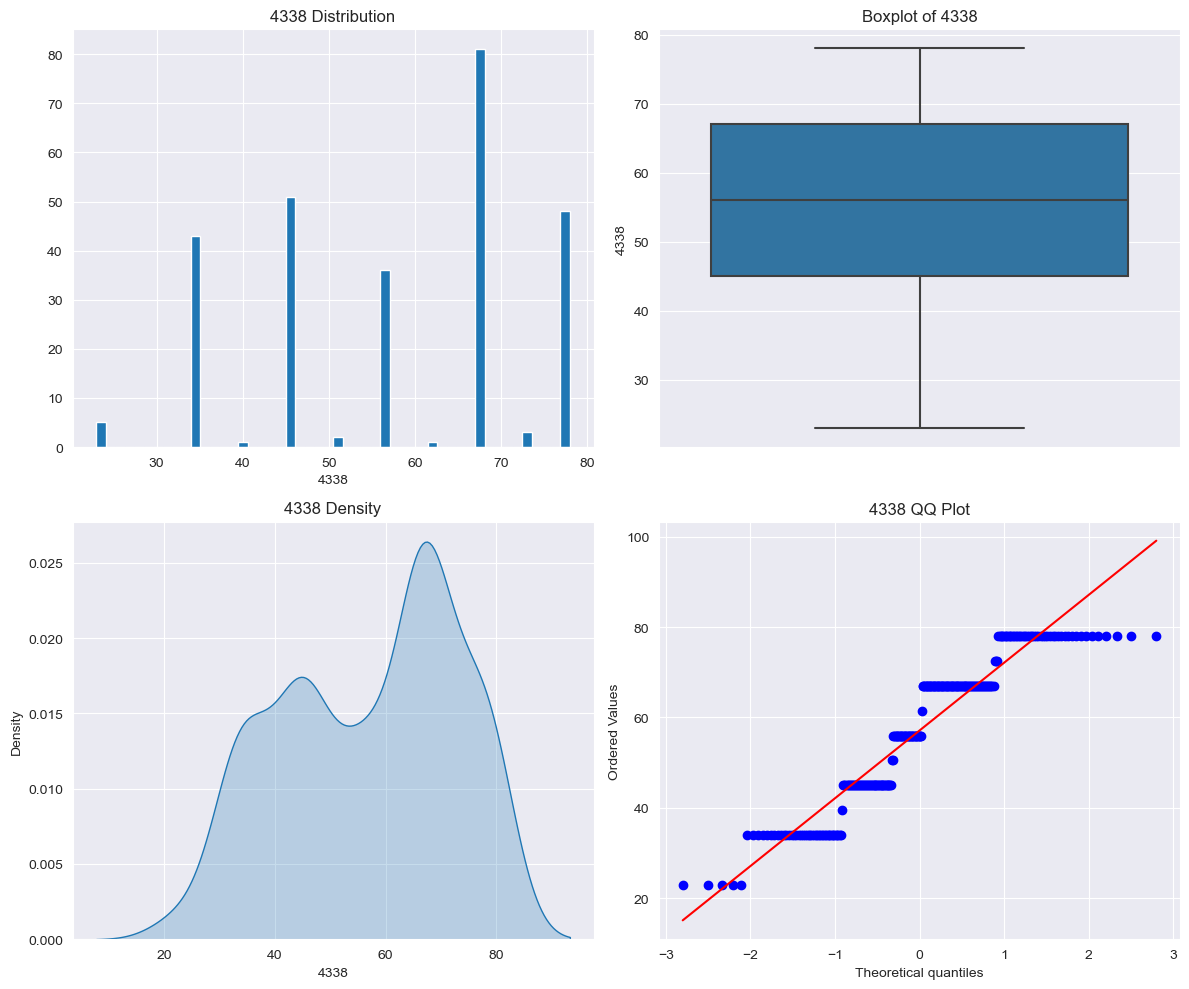

<-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><->
count   271.000
mean     54.505
std      14.894
min      23.000
5%       28.500
10%      34.000
20%      45.000
30%      45.000
40%      56.000
50%      56.000
60%      67.000
70%      67.000
80%      67.000
90%      67.000
95%      78.000
99%      78.000
max      89.000
Name: 4339, dtype: float64


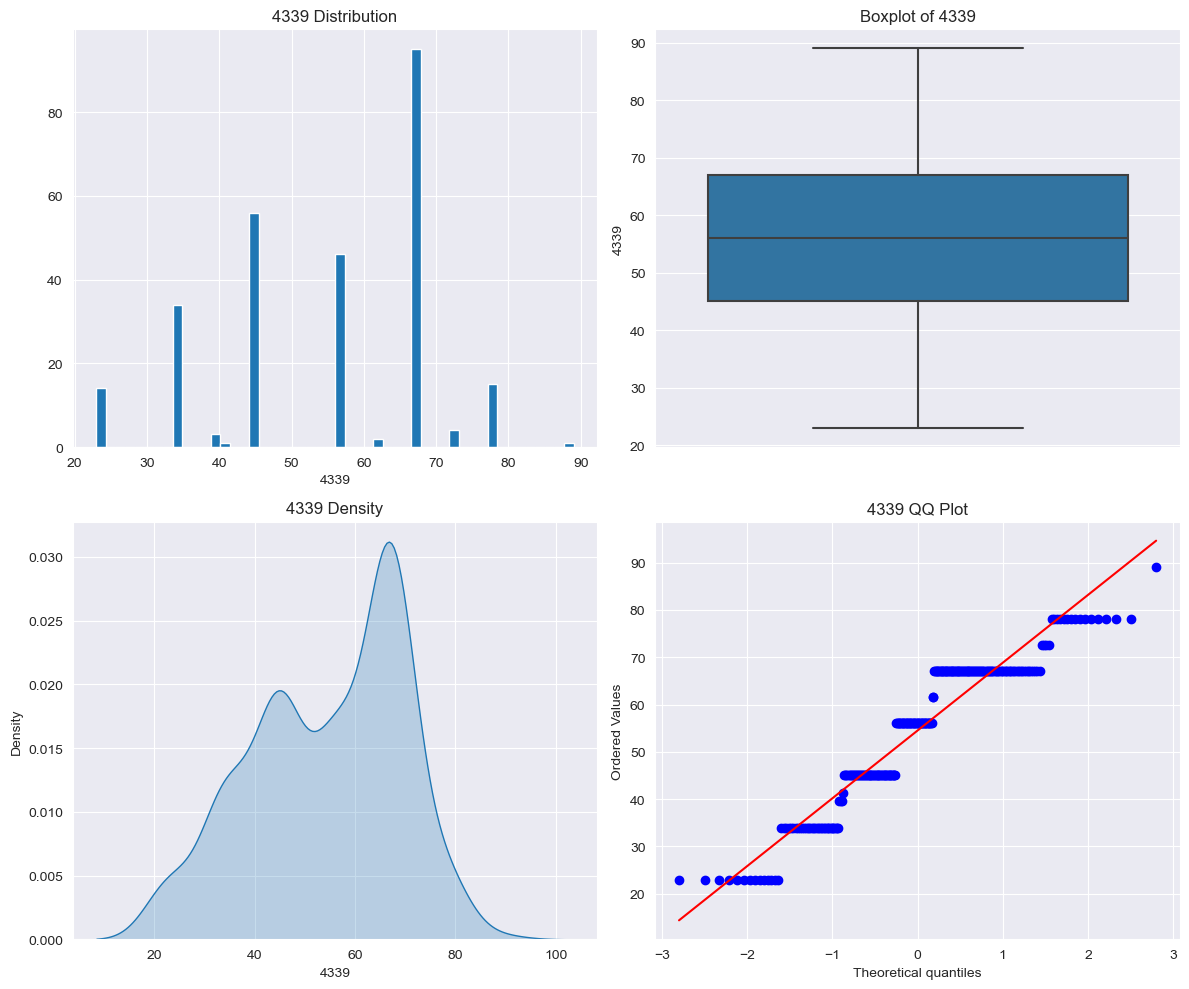

<-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><->
count   271.000
mean     53.199
std      15.161
min      12.000
5%       23.000
10%      34.000
20%      34.000
30%      45.000
40%      45.000
50%      56.000
60%      67.000
70%      67.000
80%      67.000
90%      67.000
95%      67.000
99%      78.000
max      78.000
Name: 4340, dtype: float64


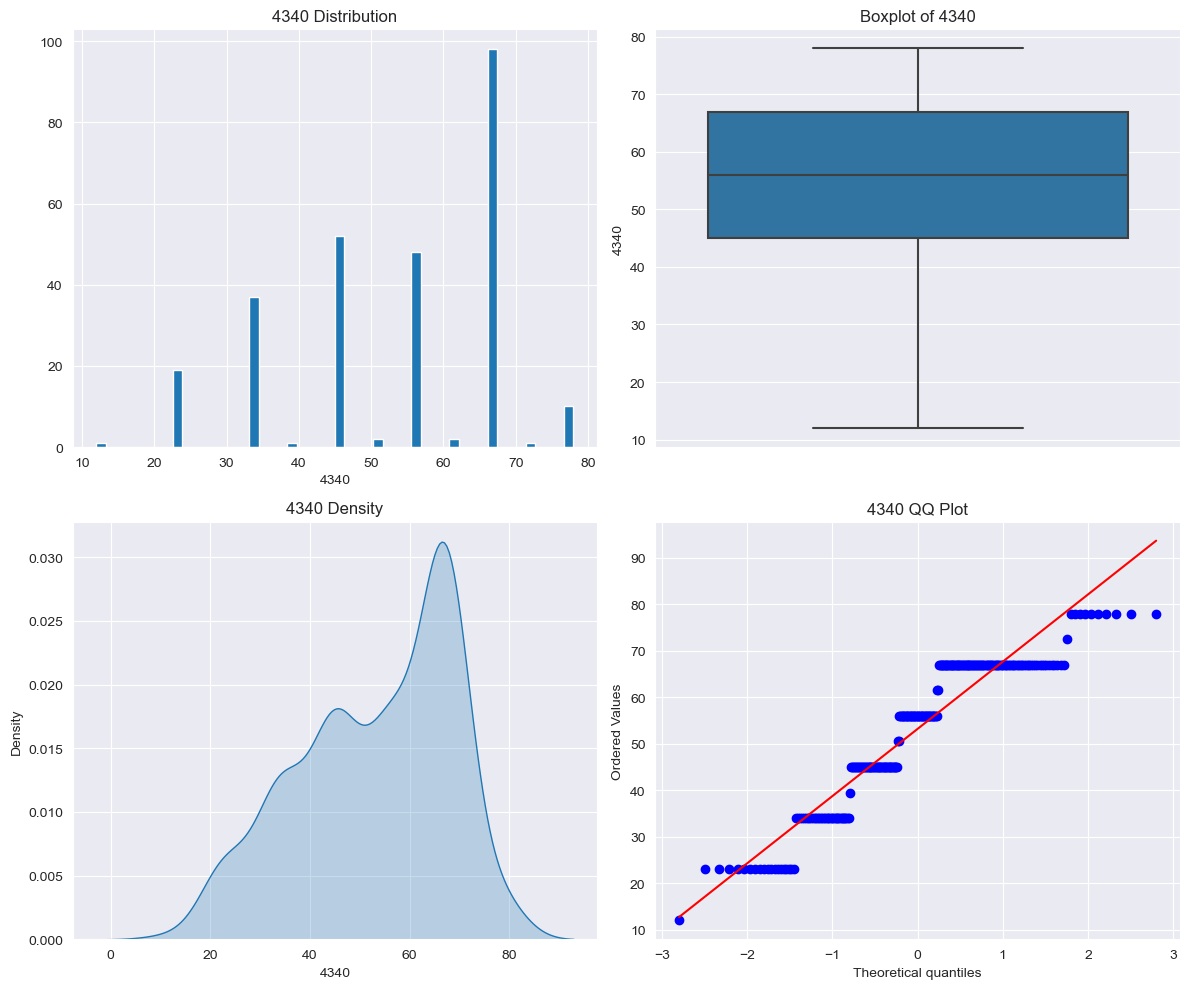

<-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><->
count   271.000
mean     55.195
std      14.795
min      23.000
5%       34.000
10%      34.000
20%      45.000
30%      45.000
40%      56.000
50%      56.000
60%      67.000
70%      67.000
80%      67.000
90%      67.000
95%      78.000
99%      78.000
max      89.000
Name: 4341, dtype: float64


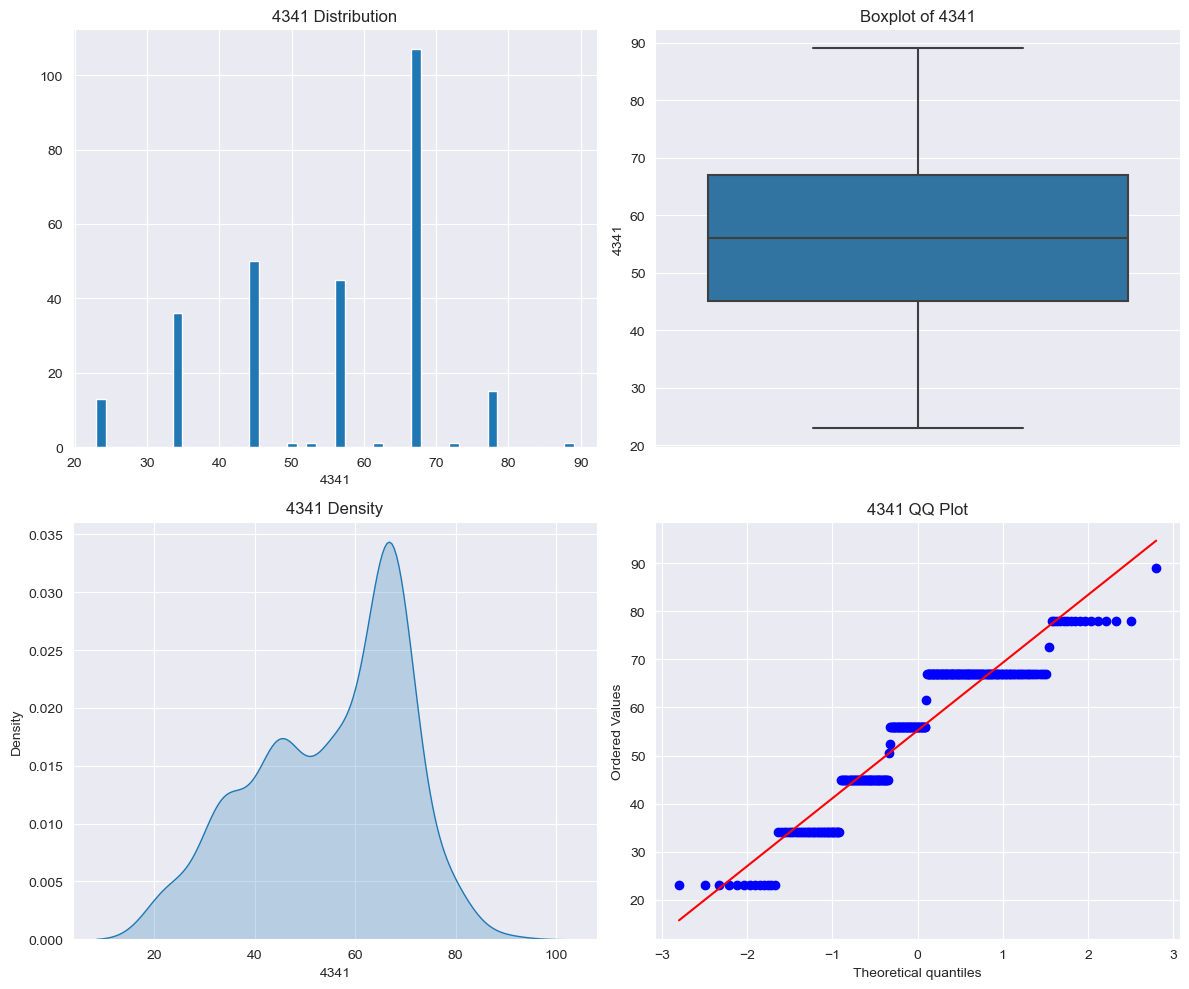

<-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><->
count   271.000
mean     58.361
std      14.718
min      23.000
5%       34.000
10%      34.000
20%      45.000
30%      45.000
40%      56.000
50%      67.000
60%      67.000
70%      67.000
80%      67.000
90%      78.000
95%      78.000
99%      78.000
max      89.000
Name: 4342, dtype: float64


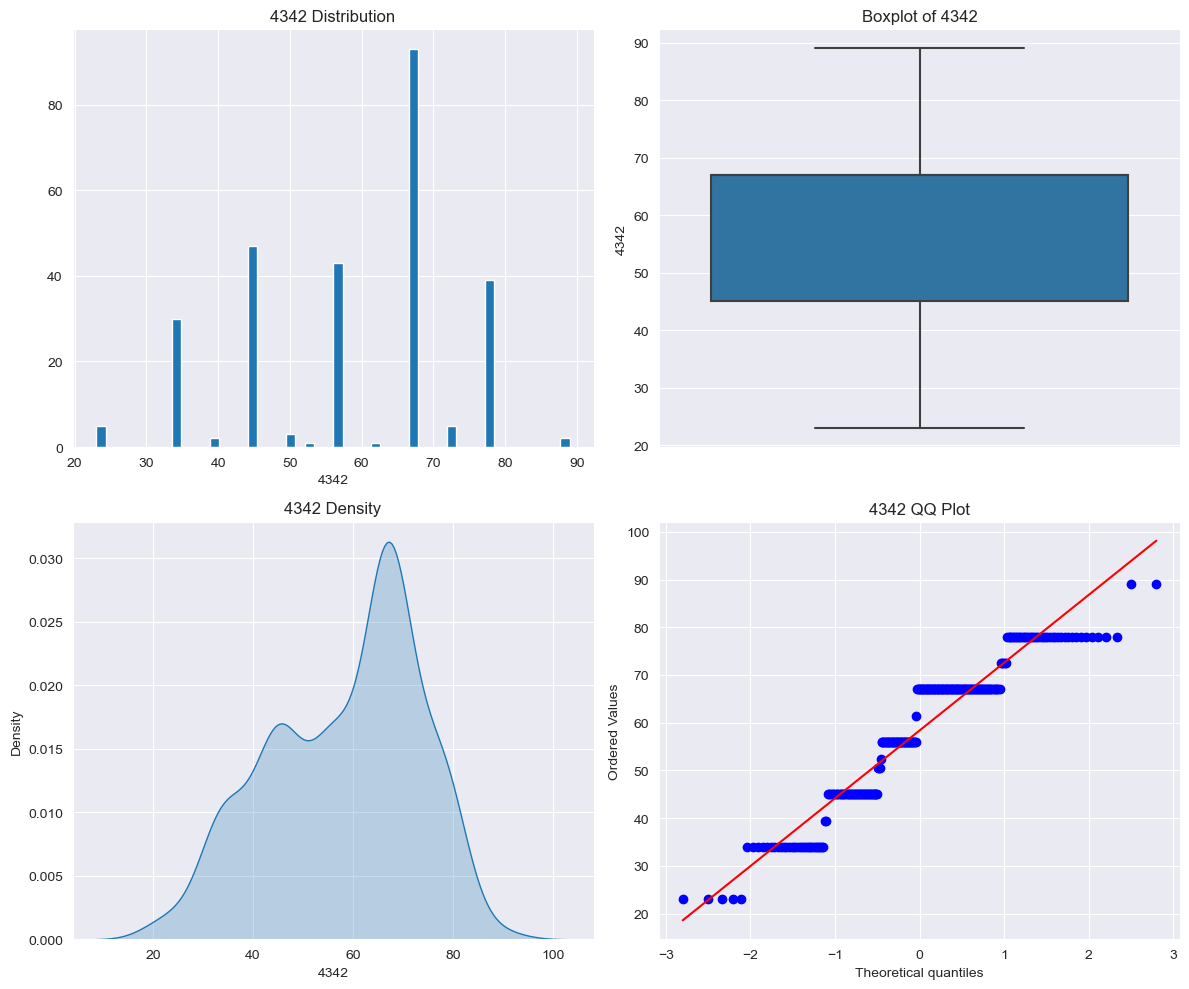

<-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><->
count   271.000
mean     46.387
std      16.790
min      12.000
5%       23.000
10%      23.000
20%      23.000
30%      34.000
40%      45.000
50%      45.000
60%      56.000
70%      56.000
80%      67.000
90%      67.000
95%      67.000
99%      74.150
max      89.000
Name: 4343, dtype: float64


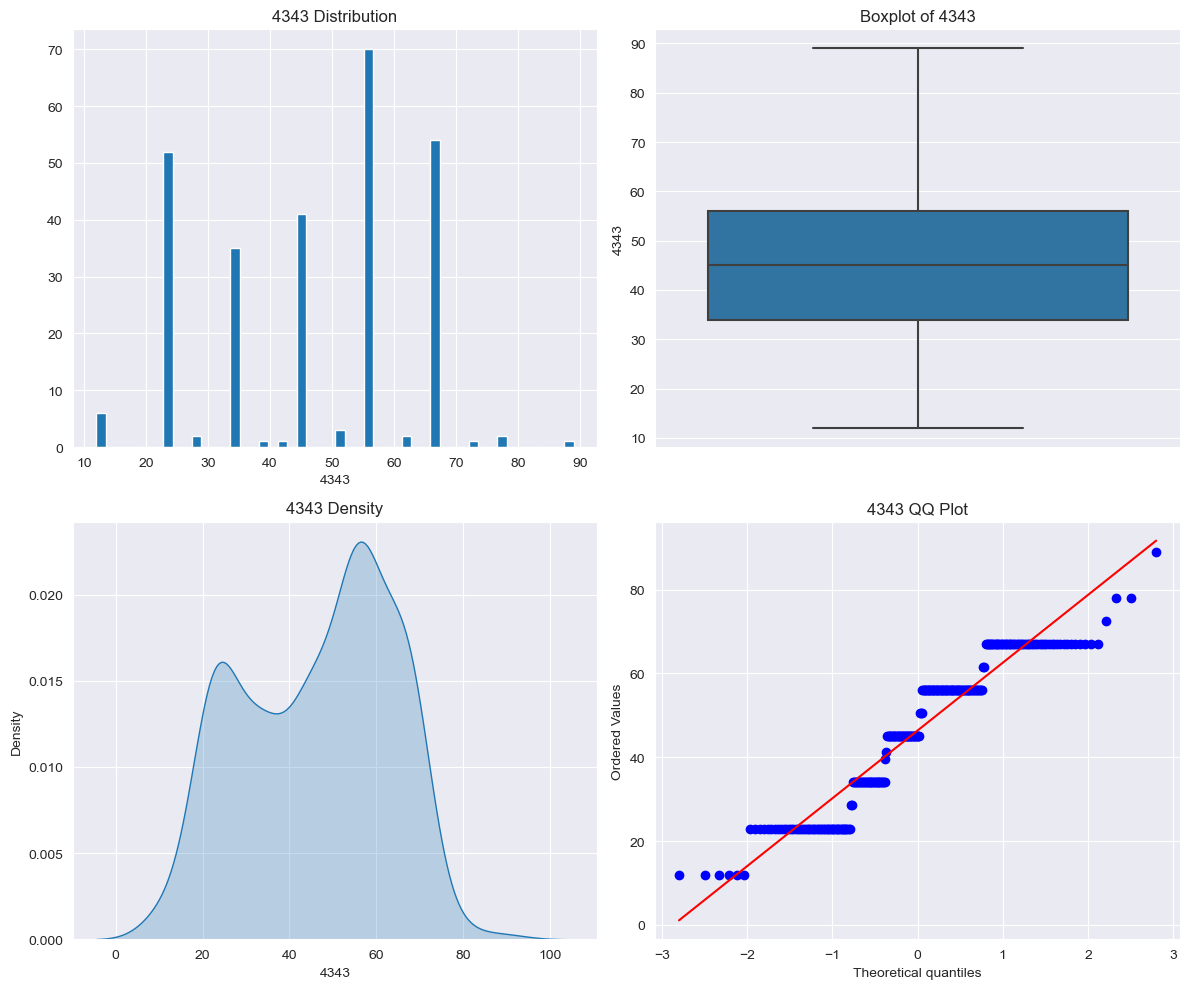

<-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><->
count   271.000
mean     43.349
std      16.909
min      12.000
5%       23.000
10%      23.000
20%      23.000
30%      34.000
40%      34.000
50%      45.000
60%      56.000
70%      56.000
80%      56.000
90%      56.000
95%      67.000
99%      78.000
max     100.000
Name: 4344, dtype: float64


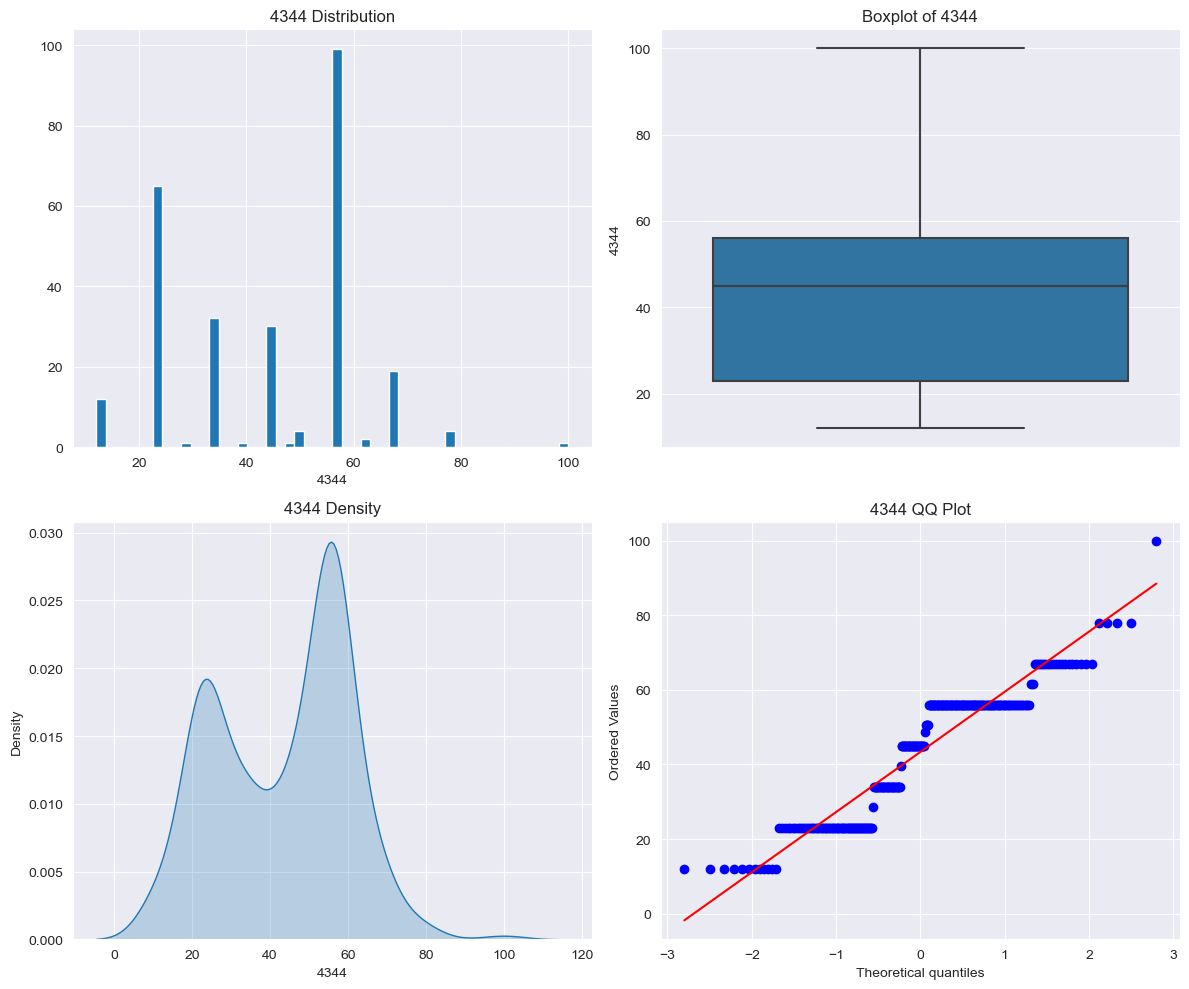

<-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><->
count   271.000
mean     55.317
std      15.768
min      23.000
5%       28.500
10%      34.000
20%      34.000
30%      45.000
40%      56.000
50%      56.000
60%      67.000
70%      67.000
80%      67.000
90%      67.000
95%      78.000
99%      78.000
max      83.500
Name: 4345, dtype: float64


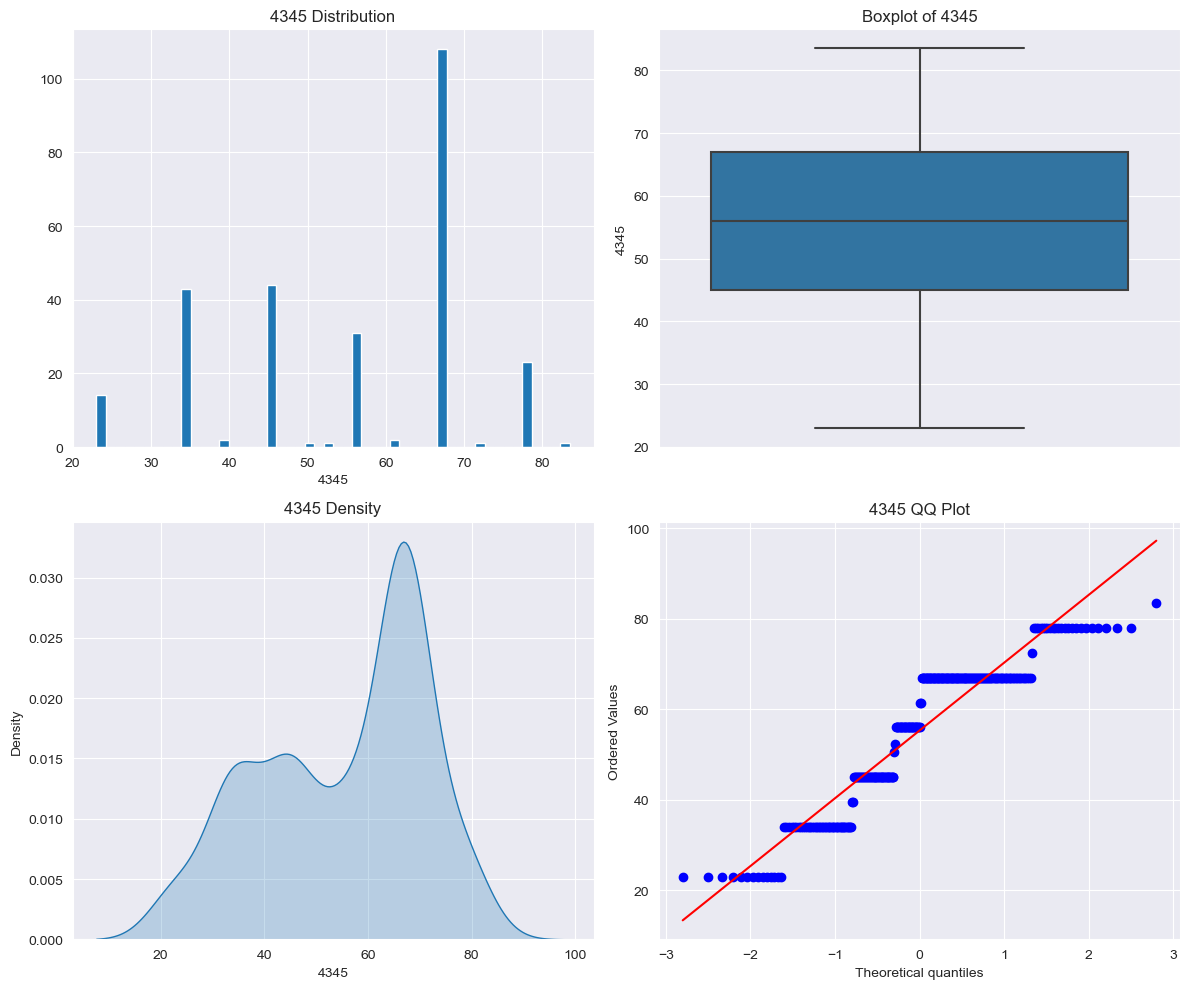

<-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><->
count   271.000
mean     51.569
std      17.592
min      12.000
5%       23.000
10%      23.000
20%      34.000
30%      34.000
40%      45.000
50%      56.000
60%      61.500
70%      67.000
80%      67.000
90%      67.000
95%      78.000
99%      78.000
max      89.000
Name: 4348, dtype: float64


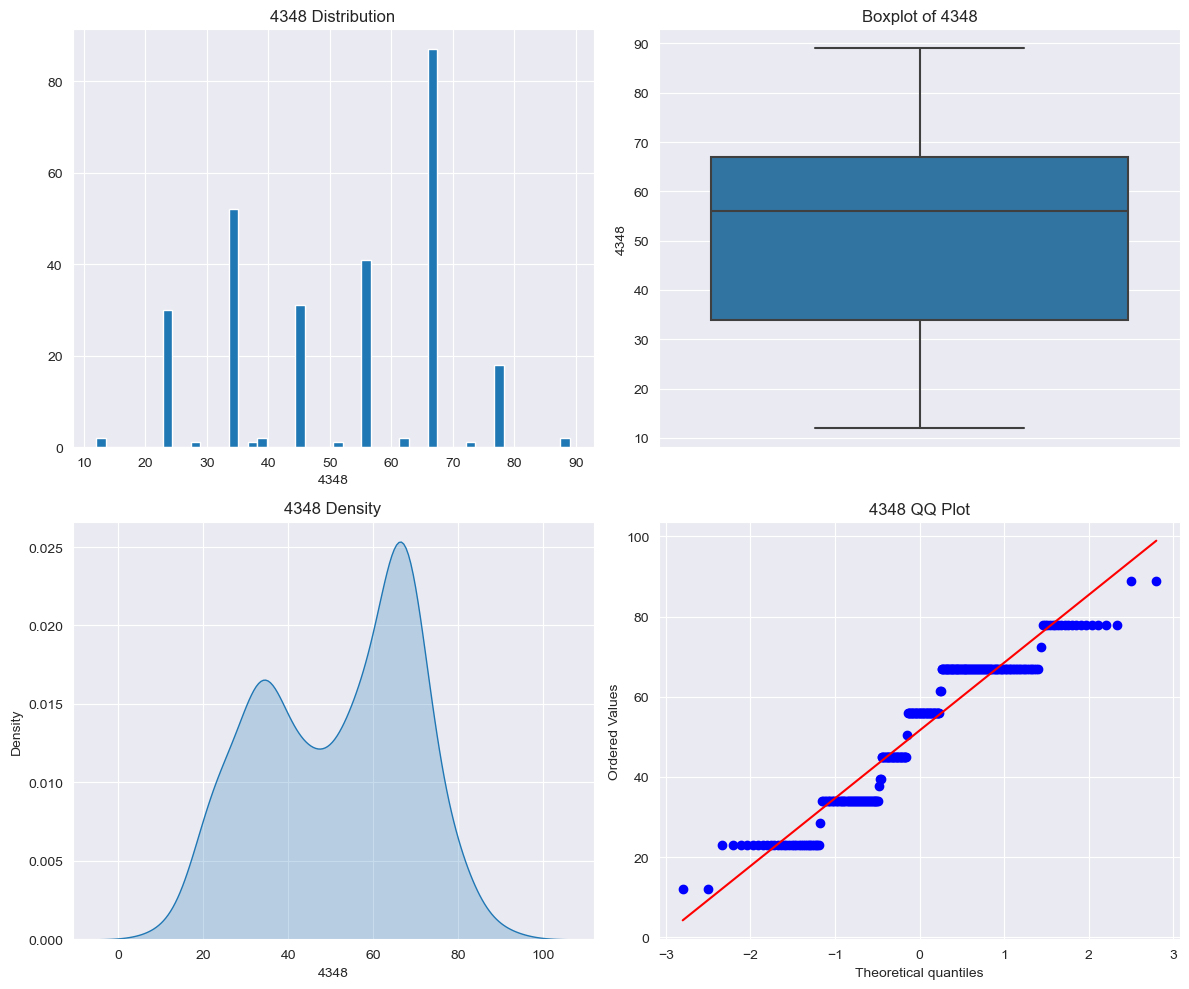

<-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><->
count   271.000
mean     45.237
std      16.095
min      12.000
5%       23.000
10%      23.000
20%      23.000
30%      34.000
40%      45.000
50%      45.000
60%      56.000
70%      56.000
80%      56.000
90%      67.000
95%      67.000
99%      78.000
max      89.000
Name: 4349, dtype: float64


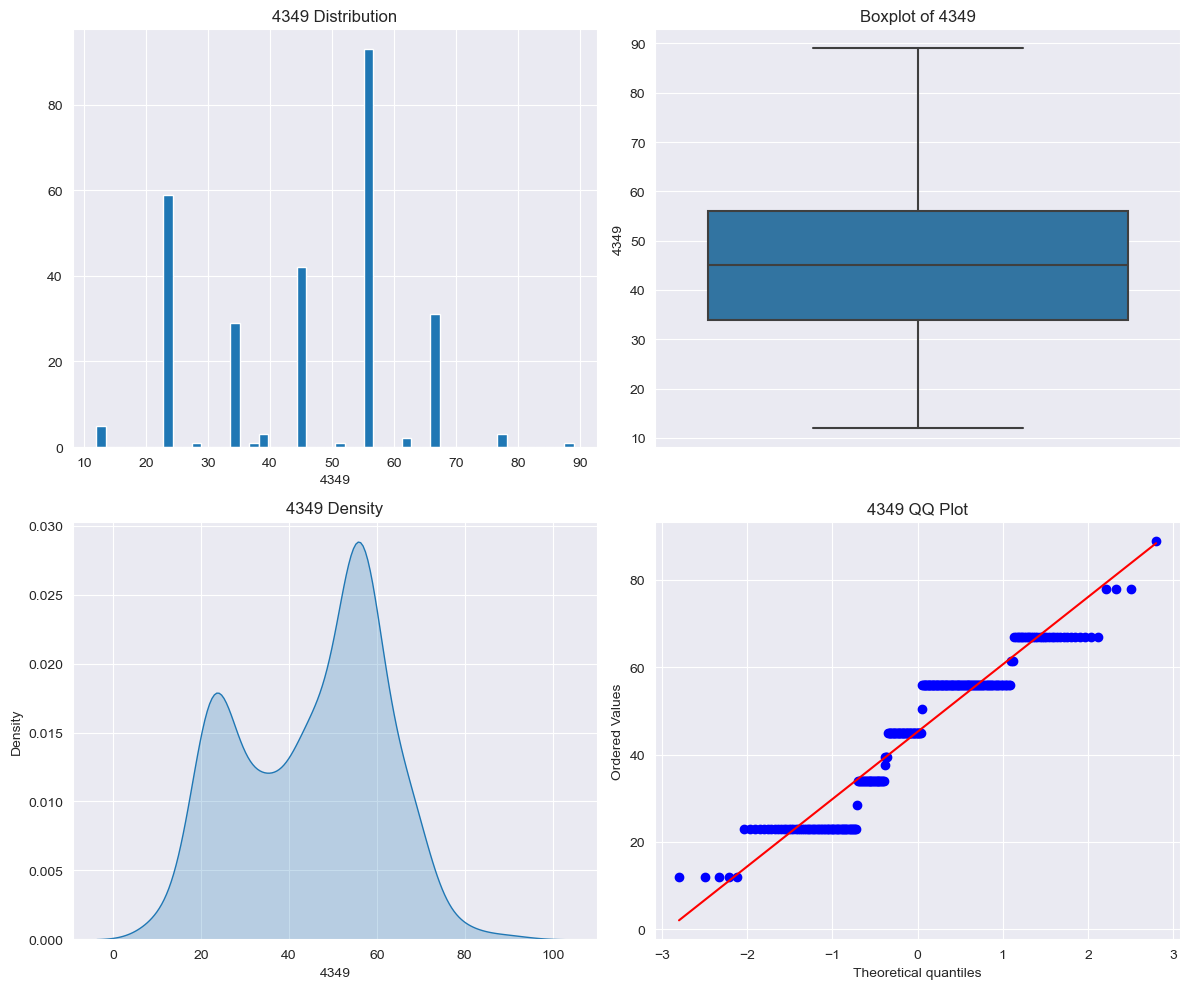

<-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><->
count   271.000
mean     54.897
std      14.303
min      12.000
5%       34.000
10%      34.000
20%      45.000
30%      45.000
40%      56.000
50%      56.000
60%      67.000
70%      67.000
80%      67.000
90%      67.000
95%      67.000
99%      78.000
max      78.000
Name: 4350, dtype: float64


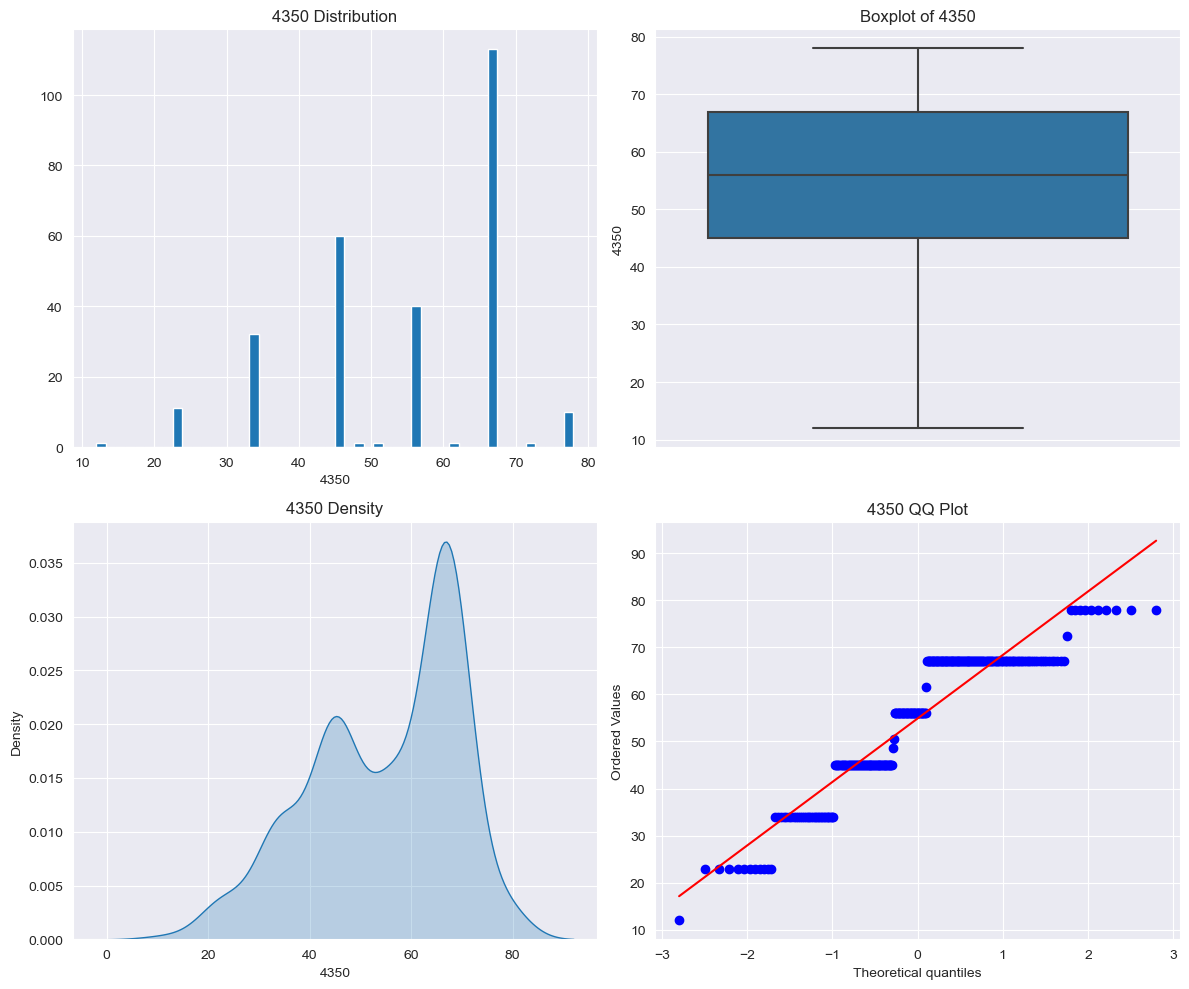

<-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><->
count   271.000
mean     56.737
std      14.344
min      12.000
5%       34.000
10%      34.000
20%      45.000
30%      45.000
40%      56.000
50%      56.000
60%      67.000
70%      67.000
80%      67.000
90%      67.000
95%      78.000
99%      78.000
max     100.000
Name: 4351, dtype: float64


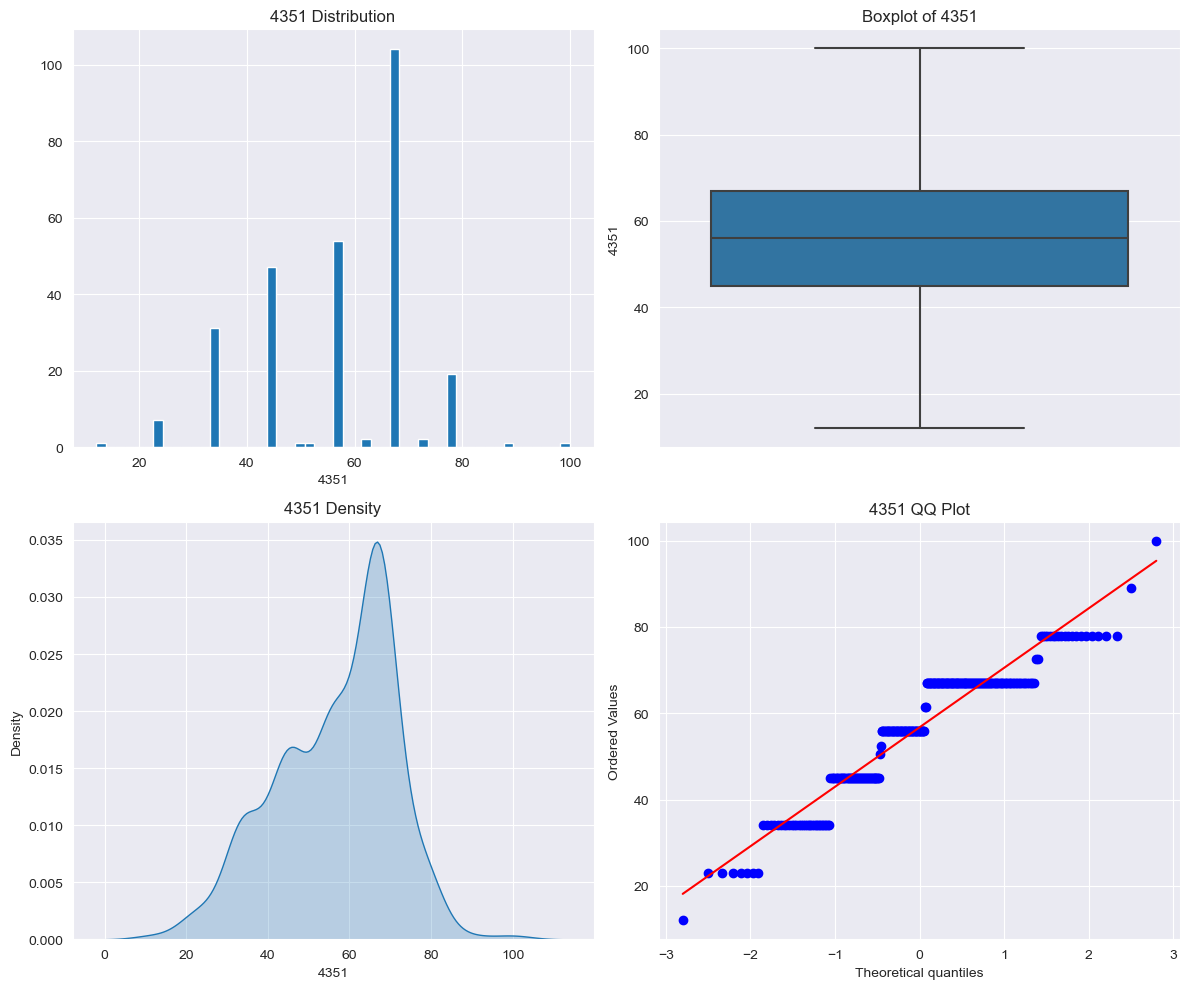

<-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><->
count   271.000
mean     54.187
std      15.777
min      12.000
5%       34.000
10%      34.000
20%      34.000
30%      45.000
40%      45.000
50%      56.000
60%      67.000
70%      67.000
80%      67.000
90%      67.000
95%      78.000
99%      78.000
max      78.000
Name: 4353, dtype: float64


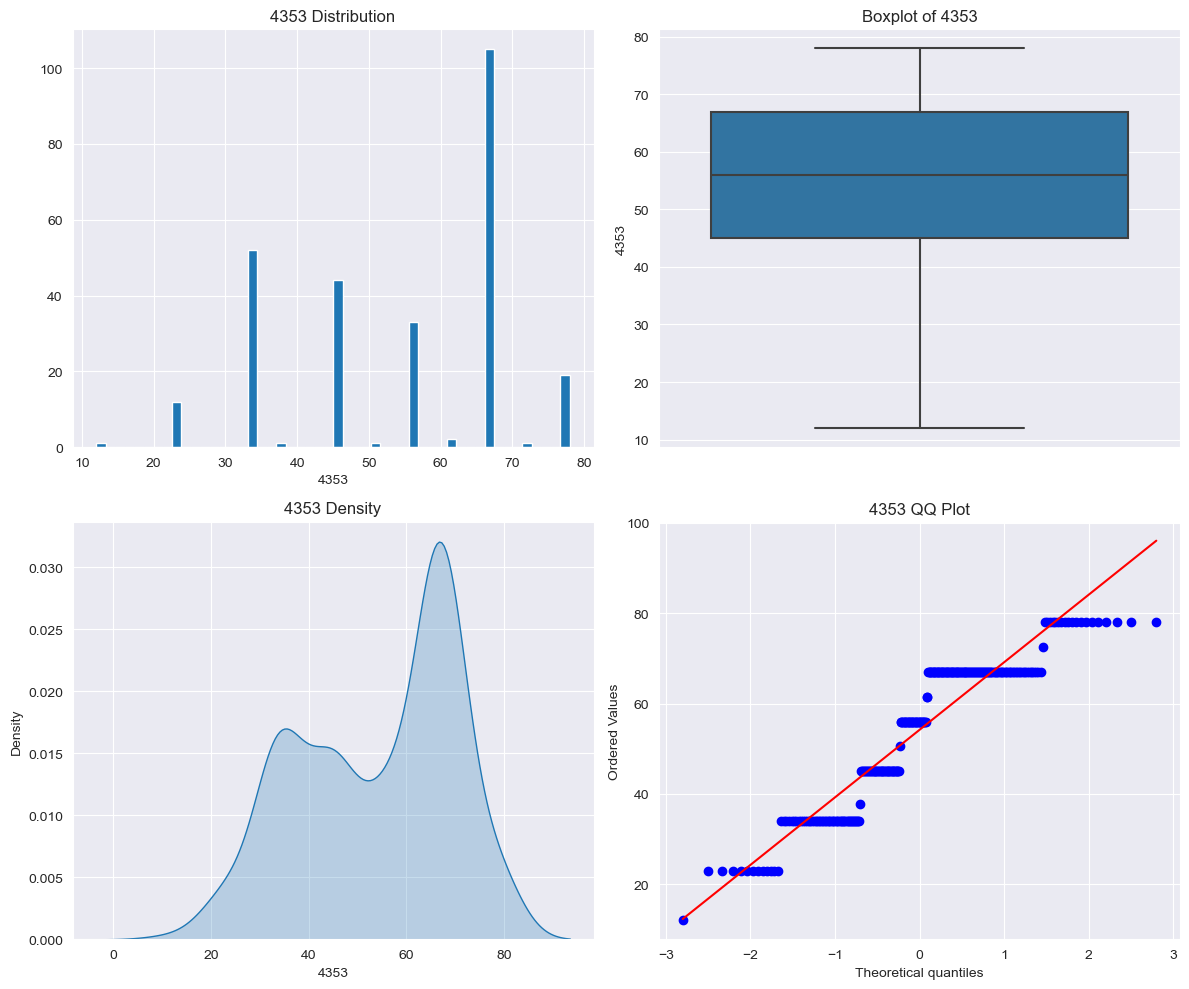

<-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><->
count   271.000
mean     59.450
std      17.653
min      12.000
5%       34.000
10%      34.000
20%      45.000
30%      45.000
40%      56.000
50%      56.000
60%      67.000
70%      78.000
80%      78.000
90%      78.000
95%      78.000
99%      78.000
max      78.000
Name: 4354, dtype: float64


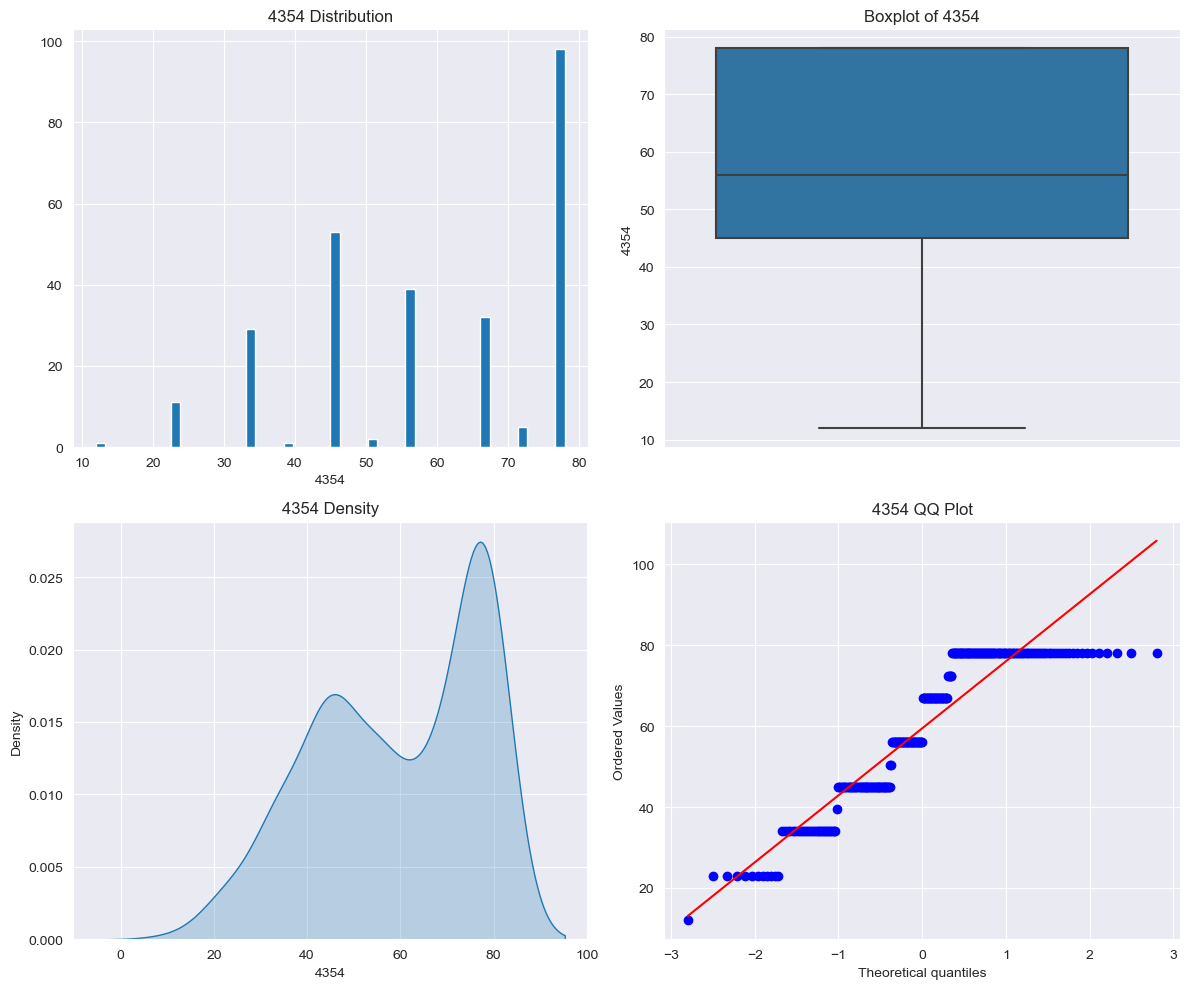

<-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><->
count   271.000
mean     57.745
std      14.677
min      12.000
5%       34.000
10%      34.000
20%      45.000
30%      45.000
40%      56.000
50%      56.000
60%      67.000
70%      67.000
80%      67.000
90%      78.000
95%      78.000
99%      78.000
max      89.000
Name: 4355, dtype: float64


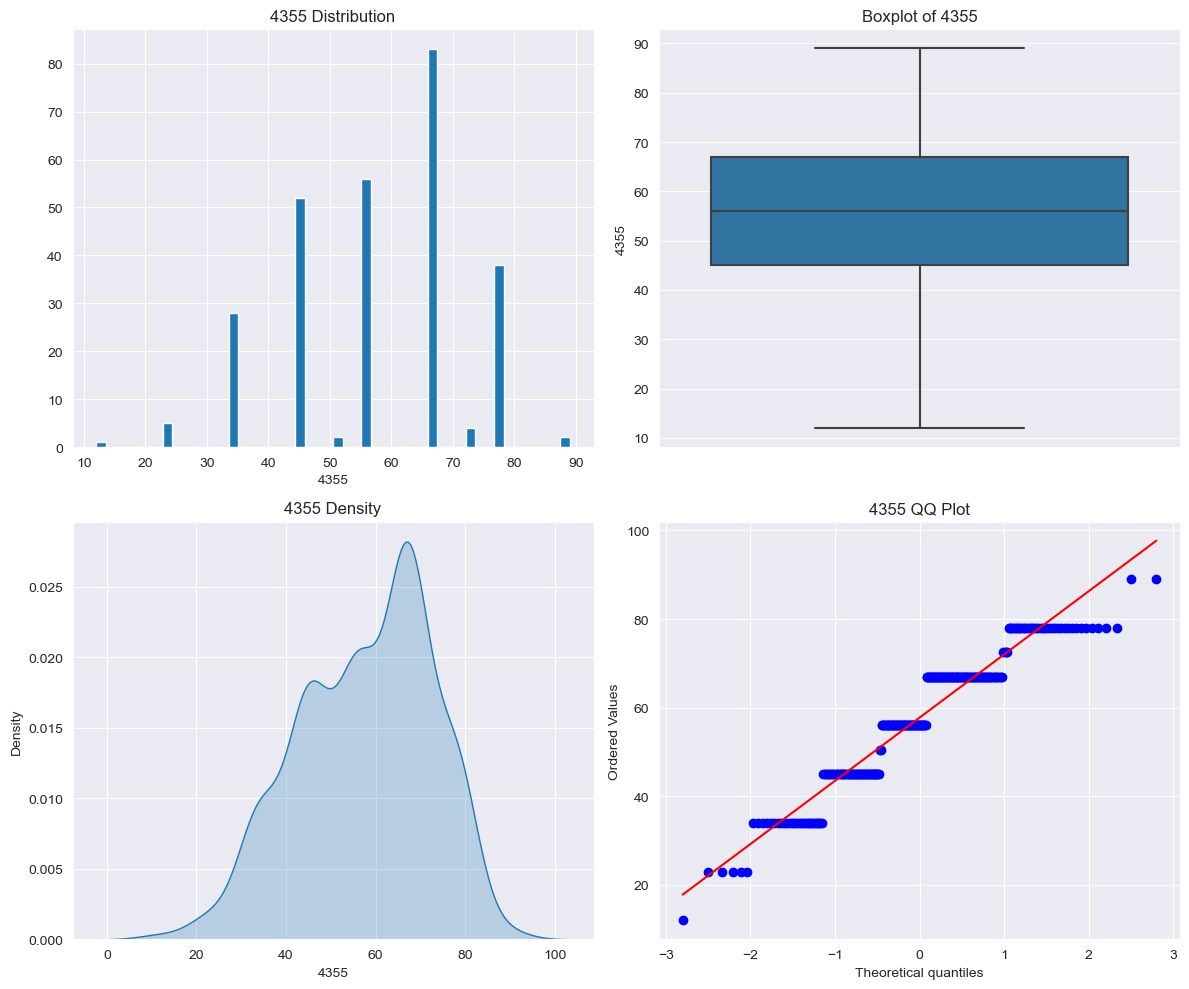

<-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><->
count   271.000
mean     52.956
std      15.379
min      23.000
5%       23.000
10%      34.000
20%      34.000
30%      45.000
40%      45.000
50%      56.000
60%      67.000
70%      67.000
80%      67.000
90%      67.000
95%      67.000
99%      78.000
max      78.000
Name: 4356, dtype: float64


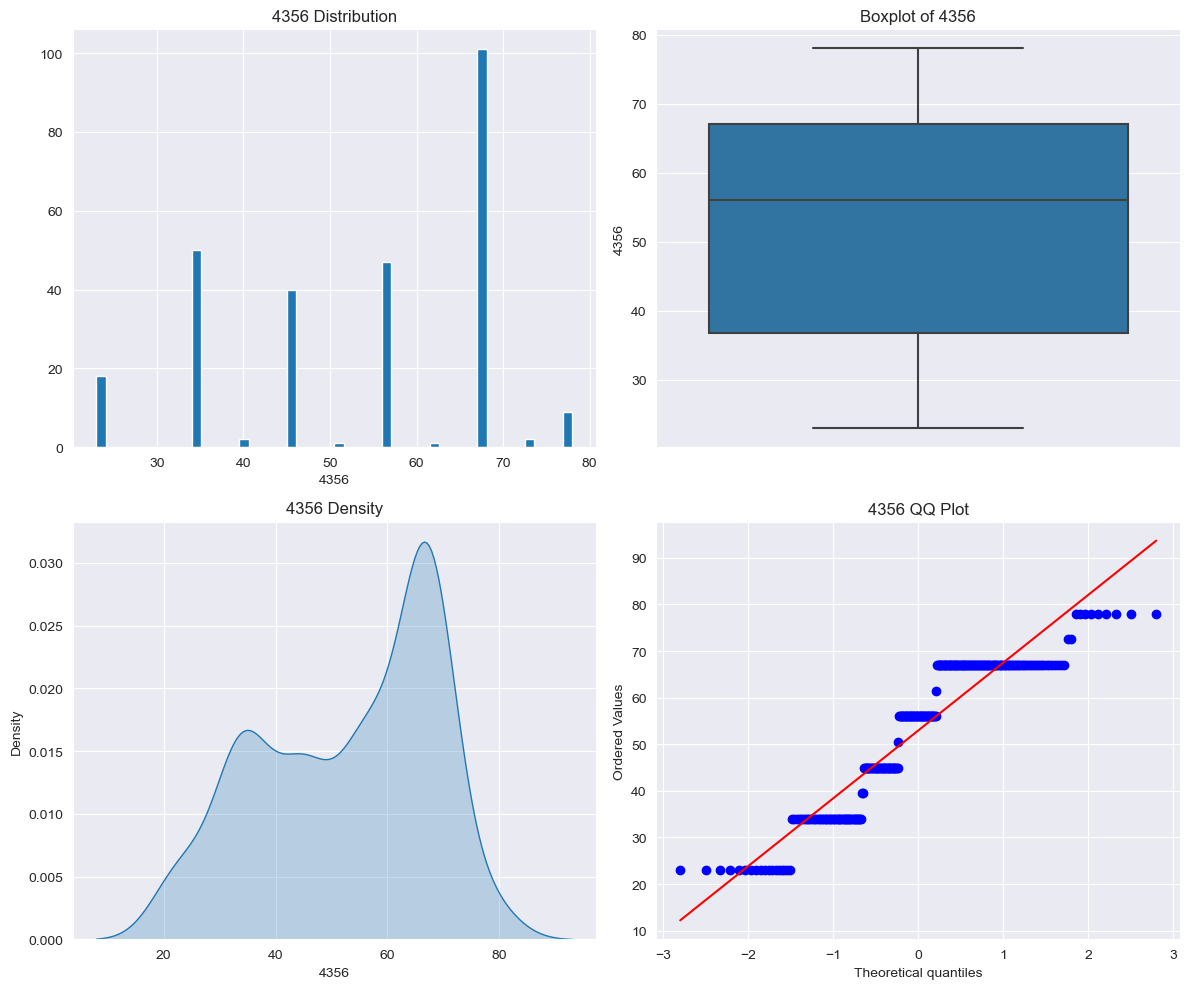

<-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><->
count   271.000
mean     58.334
std      16.392
min       1.000
5%       28.500
10%      34.000
20%      45.000
30%      56.000
40%      56.000
50%      67.000
60%      67.000
70%      67.000
80%      67.000
90%      78.000
95%      78.000
99%      89.000
max     100.000
Name: 4407, dtype: float64


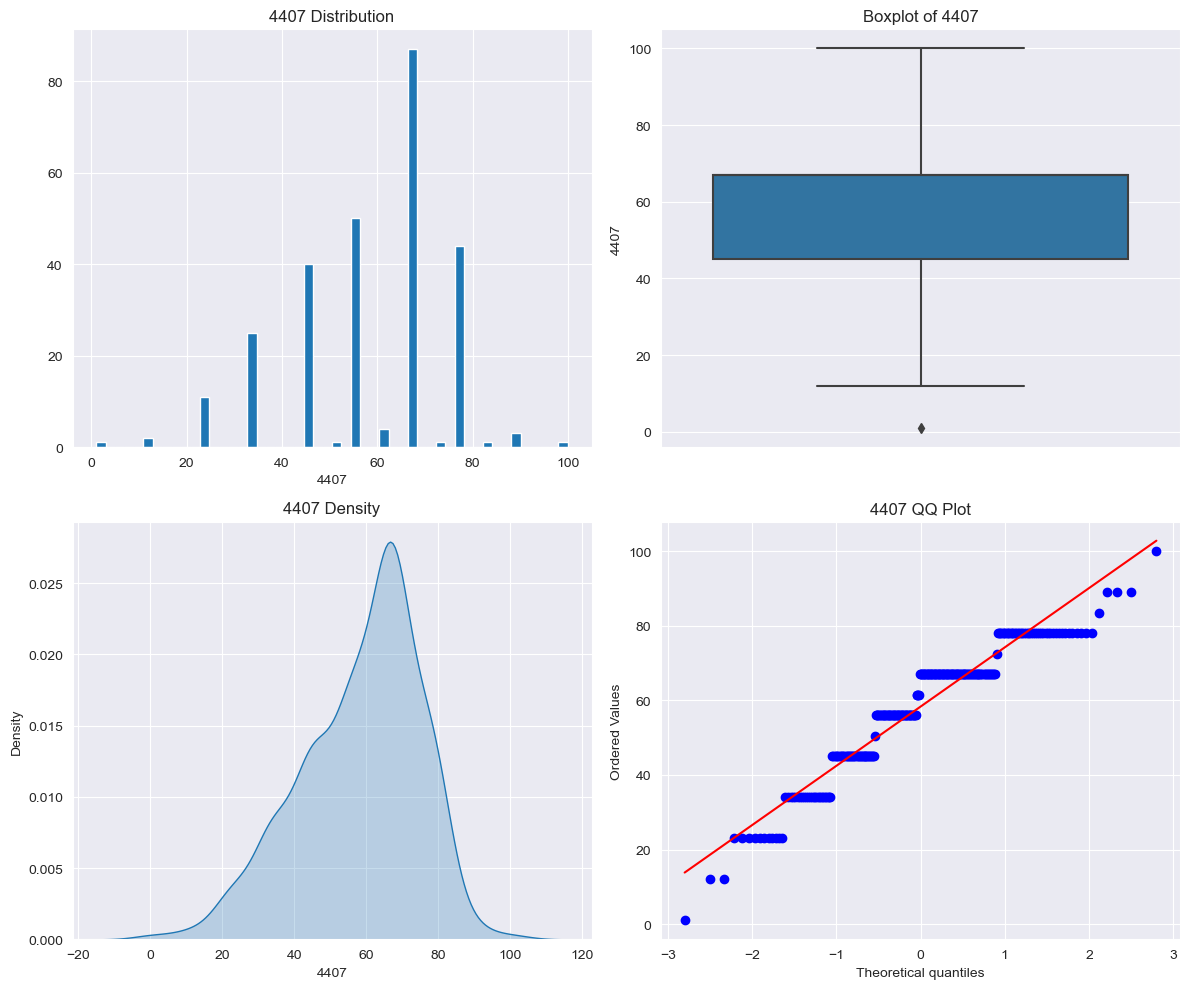

<-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><->
count   271.000
mean     56.764
std      15.335
min      12.000
5%       34.000
10%      34.000
20%      45.000
30%      45.000
40%      56.000
50%      56.000
60%      67.000
70%      67.000
80%      67.000
90%      78.000
95%      78.000
99%      78.000
max      89.000
Name: 4408, dtype: float64


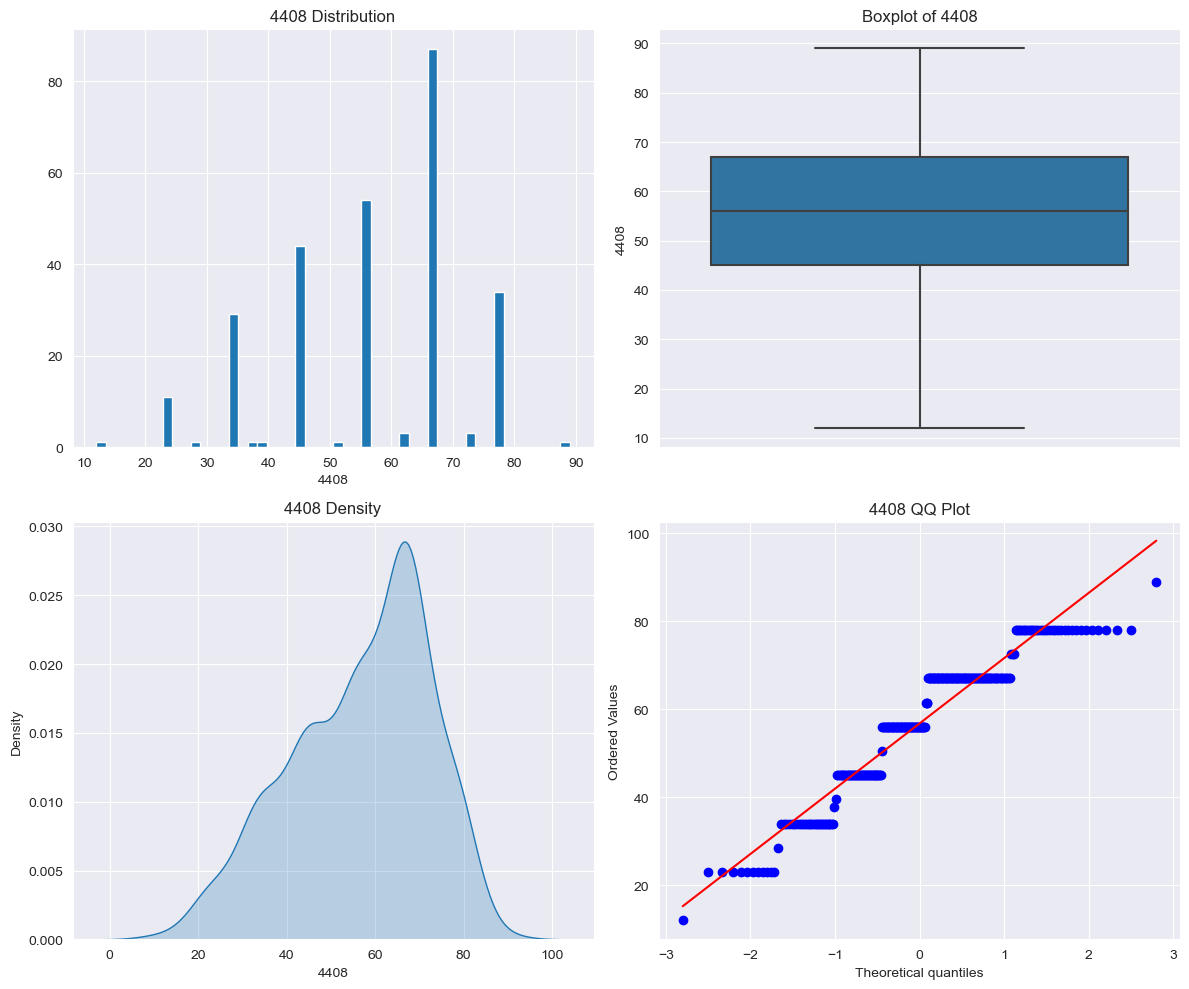

<-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><->
count   271.000
mean     60.296
std      17.028
min      23.000
5%       34.000
10%      34.000
20%      45.000
30%      50.500
40%      56.000
50%      61.500
60%      67.000
70%      78.000
80%      78.000
90%      78.000
95%      78.000
99%      78.000
max      89.000
Name: 4426, dtype: float64


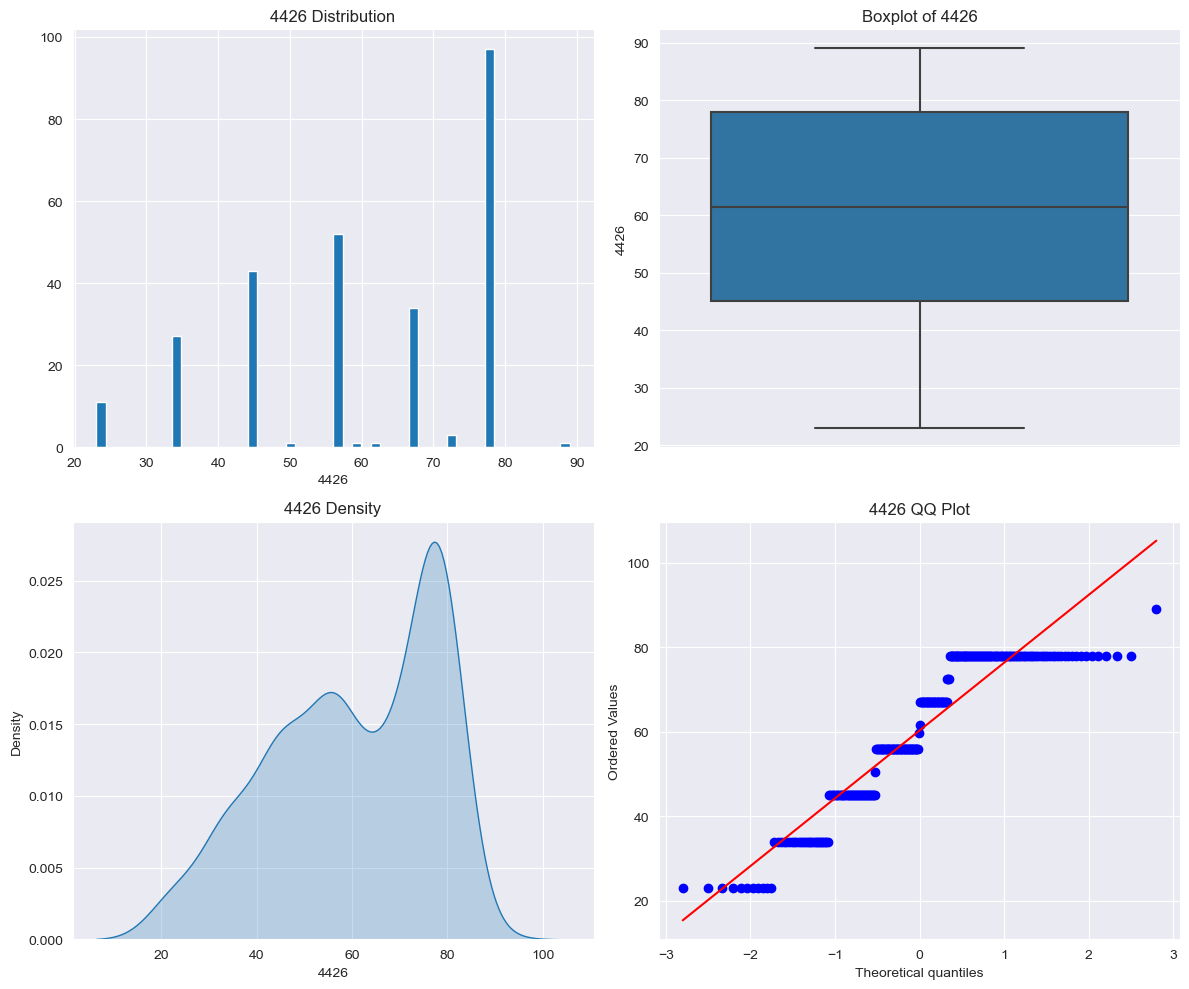

<-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><->


In [35]:
for col in num_cols:
    num_summary(pivot_df, col, plot=True)

# LABEL ENCODING

In [36]:
pivot_df["potential_label"] = LabelEncoder().fit_transform(pivot_df["potential_label"])
pivot_df.head()

attribute_id  player_id  position_id  potential_label   4322   4323   4324  \
0               1355710            7                0 50.500 50.500 34.000   
1               1356362            9                0 67.000 67.000 67.000   
2               1356375            3                0 67.000 67.000 67.000   
3               1356375            4                0 67.000 78.000 67.000   
4               1356411            9                0 67.000 67.000 78.000   

attribute_id   4325   4326   4327   4328   4329   4330   4332   4333   4335  \
0            50.500 45.000 45.000 45.000 45.000 50.500 56.000 39.500 34.000   
1            67.000 67.000 67.000 67.000 67.000 67.000 67.000 67.000 67.000   
2            67.000 67.000 67.000 67.000 78.000 67.000 67.000 78.000 56.000   
3            67.000 67.000 78.000 78.000 78.000 56.000 67.000 67.000 67.000   
4            78.000 67.000 67.000 67.000 67.000 89.000 78.000 67.000 67.000   

attribute_id   4338   4339   4340   4341   4342   4343   4344   4345   4348  \
0            39.500 39.500 45.000 45.000 50.500 28.500 23.000 39.500 28.500   
1            67.000 67.000 67.000 67.000 67.000 67.000 56.000 67.000 67.000   
2            67.000 67.000 67.000 67.000 67.000 56.000 56.000 67.000 67.000   
3            78.000 78.000 56.000 67.000 67.000 45.000 45.000 56.000 67.000   
4            67.000 56.000 56.000 67.000 78.000 56.000 56.000 67.000 56.000   

attribute_id   4349   4350   4351   4352   4353   4354   4355   4356   4357  \
0            28.500 45.000 50.500 56.000 34.000 39.500 50.500 34.000 34.000   
1            56.000 67.000 67.000 67.000 67.000 78.000 67.000 67.000 67.000   
2            56.000 56.000 67.000 67.000 67.000 78.000 67.000 67.000 67.000   
3            67.000 67.000 67.000 78.000 67.000 67.000 67.000 56.000 67.000   
4            67.000 56.000 67.000 67.000 56.000 67.000 67.000 56.000 67.000   

attribute_id   4407   4408   4423   4426  
0            56.000 34.000 34.000 56.000  
1            67.000 67.000 56.000 78.000  
2            67.000 67.000 56.000 78.000  
3            56.000 67.000 45.000 56.000  
4            89.000 56.000 67.000 78.000

In [37]:
pivot_df["potential_label"].value_counts()

potential_label
0    215
1     56
Name: count, dtype: int64

In [38]:
cat_cols, num_cols, cat_but_car = grab_col_names(pivot_df)

print("#########")
print("cat cols", cat_cols)
print("num cols" ,num_cols)
print("cat but car cols", cat_but_car)

Observations: 271
Variables: 37
cat_cols: 7
num_cols: 30
cat_but_car: 0
num_but_cat: 7
#########
cat cols ['position_id', 'potential_label', '4324', '4328', '4352', '4357', '4423']
num cols ['player_id', '4322', '4323', '4325', '4326', '4327', '4329', '4330', '4332', '4333', '4335', '4338', '4339', '4340', '4341', '4342', '4343', '4344', '4345', '4348', '4349', '4350', '4351', '4353', '4354', '4355', '4356', '4407', '4408', '4426']
cat but car cols []


In [40]:
df["player_id"].nunique()

248

In [41]:
num_cols.remove("player_id")

In [42]:
specific_num_cols = ['4324', '4328', '4352', '4357', '4423']
for col in specific_num_cols:
    if col in cat_cols:
        cat_cols.remove(col)
        num_cols.append(col)
num_cols = sorted(num_cols)

In [43]:
pivot_df[num_cols]

attribute_id   4322   4323   4324   4325   4326   4327   4328   4329   4330  \
0            50.500 50.500 34.000 50.500 45.000 45.000 45.000 45.000 50.500   
1            67.000 67.000 67.000 67.000 67.000 67.000 67.000 67.000 67.000   
2            67.000 67.000 67.000 67.000 67.000 67.000 67.000 78.000 67.000   
3            67.000 78.000 67.000 67.000 67.000 78.000 78.000 78.000 56.000   
4            67.000 67.000 78.000 78.000 67.000 67.000 67.000 67.000 89.000   
..              ...    ...    ...    ...    ...    ...    ...    ...    ...   
266          67.000 78.000 78.000 56.000 78.000 67.000 78.000 67.000 56.000   
267          67.000 67.000 67.000 67.000 67.000 67.000 67.000 78.000 67.000   
268          56.000 45.000 45.000 45.000 56.000 56.000 56.000 56.000 23.000   
269          78.000 78.000 78.000 78.000 78.000 78.000 78.000 78.000 67.000   
270          78.000 67.000 67.000 78.000 67.000 67.000 67.000 78.000 67.000   

attribute_id   4332   4333   4335   4338   4339   4340   4341   4342   4343  \
0            56.000 39.500 34.000 39.500 39.500 45.000 45.000 50.500 28.500   
1            67.000 67.000 67.000 67.000 67.000 67.000 67.000 67.000 67.000   
2            67.000 78.000 56.000 67.000 67.000 67.000 67.000 67.000 56.000   
3            67.000 67.000 67.000 78.000 78.000 56.000 67.000 67.000 45.000   
4            78.000 67.000 67.000 67.000 56.000 56.000 67.000 78.000 56.000   
..              ...    ...    ...    ...    ...    ...    ...    ...    ...   
266          78.000 78.000 56.000 67.000 67.000 78.000 56.000 67.000 56.000   
267          67.000 78.000 56.000 67.000 67.000 67.000 67.000 78.000 67.000   
268          23.000 34.000 45.000 56.000 34.000 23.000 45.000 45.000 23.000   
269          67.000 78.000 78.000 78.000 67.000 78.000 67.000 78.000 56.000   
270          67.000 78.000 67.000 78.000 67.000 67.000 78.000 78.000 67.000   

attribute_id   4344   4345   4348   4349   4350   4351   4352   4353   4354  \
0            23.000 39.500 28.500 28.500 45.000 50.500 56.000 34.000 39.500   
1            56.000 67.000 67.000 56.000 67.000 67.000 67.000 67.000 78.000   
2            56.000 67.000 67.000 56.000 56.000 67.000 67.000 67.000 78.000   
3            45.000 56.000 67.000 67.000 67.000 67.000 78.000 67.000 67.000   
4            56.000 67.000 56.000 67.000 56.000 67.000 67.000 56.000 67.000   
..              ...    ...    ...    ...    ...    ...    ...    ...    ...   
266          56.000 67.000 78.000 89.000 67.000 78.000 67.000 67.000 67.000   
267          56.000 67.000 67.000 67.000 67.000 67.000 67.000 67.000 78.000   
268          23.000 34.000 23.000 23.000 34.000 23.000 45.000 45.000 56.000   
269          56.000 78.000 78.000 67.000 78.000 78.000 78.000 78.000 78.000   
270          56.000 78.000 67.000 56.000 67.000 67.000 67.000 67.000 78.000   

attribute_id   4355   4356   4357   4407   4408   4423   4426  
0            50.500 34.000 34.000 56.000 34.000 34.000 56.000  
1            67.000 67.000 67.000 67.000 67.000 56.000 78.000  
2            67.000 67.000 67.000 67.000 67.000 56.000 78.000  
3            67.000 56.000 67.000 56.000 67.000 45.000 56.000  
4            67.000 56.000 67.000 89.000 56.000 67.000 78.000  
..              ...    ...    ...    ...    ...    ...    ...  
266          67.000 56.000 67.000 78.000 78.000 78.000 56.000  
267          67.000 67.000 67.000 67.000 67.000 67.000 78.000  
268          34.000 34.000 56.000 34.000 34.000 34.000 23.000  
269          67.000 67.000 67.000 78.000 78.000 67.000 78.000  
270          67.000 67.000 67.000 78.000 67.000 67.000 78.000  

[271 rows x 34 columns]

# CORRELATION

<Axes: xlabel='attribute_id', ylabel='attribute_id'>

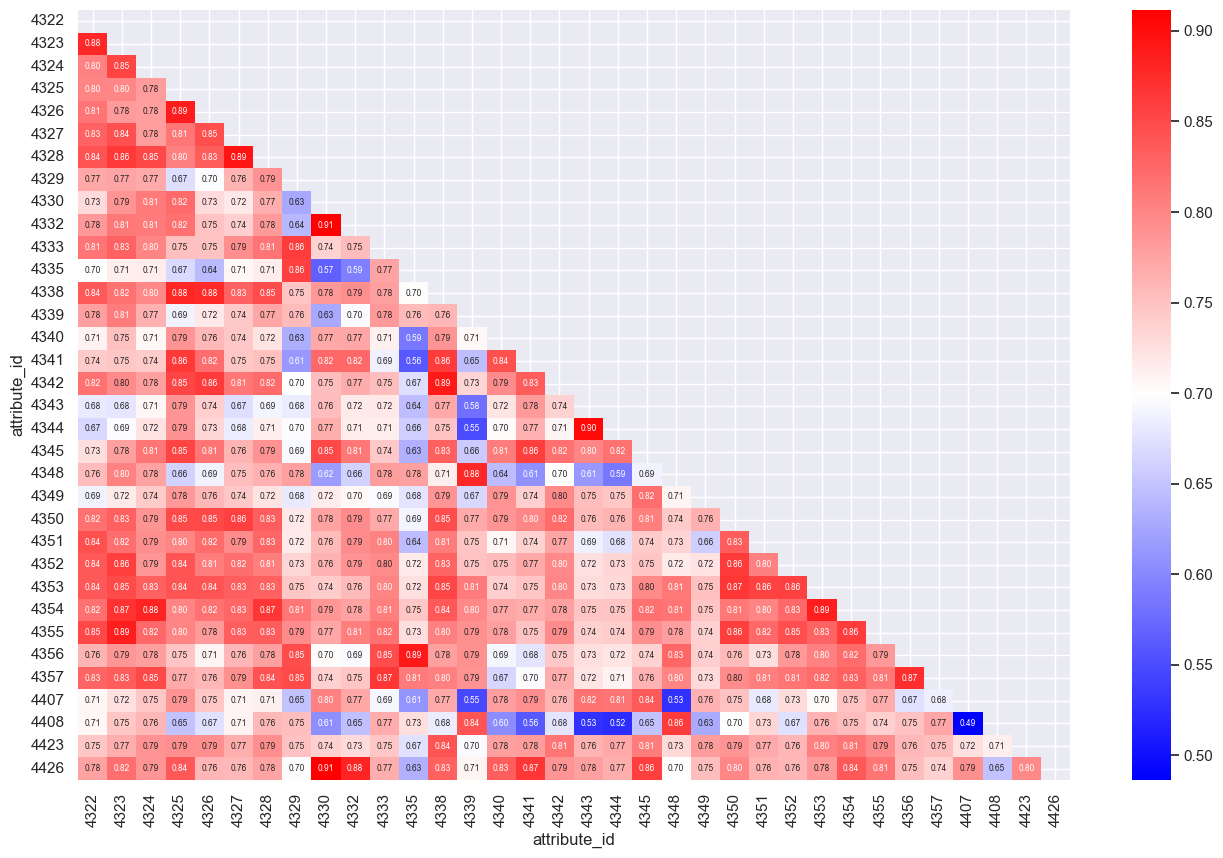

In [46]:
corr = pivot_df[num_cols].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.set(rc={'figure.figsize': (16, 10)})
sns.heatmap(corr,mask = mask, cmap="bwr", annot=True, fmt=".2f", annot_kws = {"size" : 6})
plt.show()

In [47]:
pivot_df.head()

attribute_id  player_id  position_id  potential_label   4322   4323   4324  \
0               1355710            7                0 50.500 50.500 34.000   
1               1356362            9                0 67.000 67.000 67.000   
2               1356375            3                0 67.000 67.000 67.000   
3               1356375            4                0 67.000 78.000 67.000   
4               1356411            9                0 67.000 67.000 78.000   

attribute_id   4325   4326   4327   4328   4329   4330   4332   4333   4335  \
0            50.500 45.000 45.000 45.000 45.000 50.500 56.000 39.500 34.000   
1            67.000 67.000 67.000 67.000 67.000 67.000 67.000 67.000 67.000   
2            67.000 67.000 67.000 67.000 78.000 67.000 67.000 78.000 56.000   
3            67.000 67.000 78.000 78.000 78.000 56.000 67.000 67.000 67.000   
4            78.000 67.000 67.000 67.000 67.000 89.000 78.000 67.000 67.000   

attribute_id   4338   4339   4340   4341   4342   4343   4344   4345   4348  \
0            39.500 39.500 45.000 45.000 50.500 28.500 23.000 39.500 28.500   
1            67.000 67.000 67.000 67.000 67.000 67.000 56.000 67.000 67.000   
2            67.000 67.000 67.000 67.000 67.000 56.000 56.000 67.000 67.000   
3            78.000 78.000 56.000 67.000 67.000 45.000 45.000 56.000 67.000   
4            67.000 56.000 56.000 67.000 78.000 56.000 56.000 67.000 56.000   

attribute_id   4349   4350   4351   4352   4353   4354   4355   4356   4357  \
0            28.500 45.000 50.500 56.000 34.000 39.500 50.500 34.000 34.000   
1            56.000 67.000 67.000 67.000 67.000 78.000 67.000 67.000 67.000   
2            56.000 56.000 67.000 67.000 67.000 78.000 67.000 67.000 67.000   
3            67.000 67.000 67.000 78.000 67.000 67.000 67.000 56.000 67.000   
4            67.000 56.000 67.000 67.000 56.000 67.000 67.000 56.000 67.000   

attribute_id   4407   4408   4423   4426  
0            56.000 34.000 34.000 56.000  
1            67.000 67.000 56.000 78.000  
2            67.000 67.000 56.000 78.000  
3            56.000 67.000 45.000 56.000  
4            89.000 56.000 67.000 78.000

# ML MODELS

In [48]:
X = pivot_df.drop(["player_id", "potential_label"], axis=1)
y = pivot_df["potential_label"]

In [49]:
y.value_counts()

potential_label
0    215
1     56
Name: count, dtype: int64

In [51]:
X.head()

attribute_id  position_id   4322   4323   4324   4325   4326   4327   4328  \
0                       7 50.500 50.500 34.000 50.500 45.000 45.000 45.000   
1                       9 67.000 67.000 67.000 67.000 67.000 67.000 67.000   
2                       3 67.000 67.000 67.000 67.000 67.000 67.000 67.000   
3                       4 67.000 78.000 67.000 67.000 67.000 78.000 78.000   
4                       9 67.000 67.000 78.000 78.000 67.000 67.000 67.000   

attribute_id   4329   4330   4332   4333   4335   4338   4339   4340   4341  \
0            45.000 50.500 56.000 39.500 34.000 39.500 39.500 45.000 45.000   
1            67.000 67.000 67.000 67.000 67.000 67.000 67.000 67.000 67.000   
2            78.000 67.000 67.000 78.000 56.000 67.000 67.000 67.000 67.000   
3            78.000 56.000 67.000 67.000 67.000 78.000 78.000 56.000 67.000   
4            67.000 89.000 78.000 67.000 67.000 67.000 56.000 56.000 67.000   

attribute_id   4342   4343   4344   4345   4348   4349   4350   4351   4352  \
0            50.500 28.500 23.000 39.500 28.500 28.500 45.000 50.500 56.000   
1            67.000 67.000 56.000 67.000 67.000 56.000 67.000 67.000 67.000   
2            67.000 56.000 56.000 67.000 67.000 56.000 56.000 67.000 67.000   
3            67.000 45.000 45.000 56.000 67.000 67.000 67.000 67.000 78.000   
4            78.000 56.000 56.000 67.000 56.000 67.000 56.000 67.000 67.000   

attribute_id   4353   4354   4355   4356   4357   4407   4408   4423   4426  
0            34.000 39.500 50.500 34.000 34.000 56.000 34.000 34.000 56.000  
1            67.000 78.000 67.000 67.000 67.000 67.000 67.000 56.000 78.000  
2            67.000 78.000 67.000 67.000 67.000 67.000 67.000 56.000 78.000  
3            67.000 67.000 67.000 56.000 67.000 56.000 67.000 45.000 56.000  
4            56.000 67.000 67.000 56.000 67.000 89.000 56.000 67.000 78.000

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# SCALING

In [53]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

# MODELS

In [54]:
models = [('LR', LogisticRegression()),
          ('KNN', KNeighborsClassifier()),
          ('CART', DecisionTreeClassifier()),
          ('RF', RandomForestClassifier()),
          ('SVR', SVC()),
          ('GBM', GradientBoostingClassifier()),
          ("XGBoost", XGBClassifier()),
          ("LightGBM", LGBMClassifier()),
          ("CatBoost", CatBoostClassifier(verbose = False))]

In [55]:
acclist=[]
for name, model in models:
    acc = np.mean(cross_val_score(model, X_train, y_train, cv=5, scoring="accuracy"))
    acclist.append([name,acc])
    print(f"ACC: {round(acc, 4)} ({name}) ")

ACC: 0.8286 (LR) 
ACC: 0.8613 (KNN) 
ACC: 0.7916 (CART) 
ACC: 0.8566 (RF) 
ACC: 0.8427 (SVR) 
ACC: 0.8517 (GBM) 
ACC: 0.8795 (XGBoost) 
[LightGBM] [Info] Number of positive: 36, number of negative: 136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000187 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 288
[LightGBM] [Info] Number of data points in the train set: 172, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209302 -> initscore=-1.329136
[LightGBM] [Info] Start training from score -1.329136
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

# Hyperparameter Optimization for LGBM

**In this case, when set to verbosity=-1, no output is generated during the training of the LightGBM model.**

In [69]:
lgbm_model = LGBMClassifier(verbosity=-1)

In [70]:
lgbm_params = {
    "learning_rate": [0.01, 0.03, 0.05, 0.1],
    "max_depth":[3,5,8],
    "subsample":[0.5, 0.8, 1.0],
    "n_estimators": [200, 300]}

In [71]:
lgbm_gs_best = GridSearchCV(lgbm_model, lgbm_params, cv=10, n_jobs=-1).fit(X_train, y_train)

In [72]:
lgbm_gs_best.best_params_

{'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.5}

In [73]:
lgbm_model = LGBMClassifier(**lgbm_gs_best.best_params_, verbosity=-1)
lgbm_model.fit(X_train, y_train)
lgbm_model.score(X_test, y_test)

LGBMClassifier(learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.5,
               verbosity=-1)

0.6

In [64]:
lgbm_pred=lgbm_model.predict(X_test)
lgbm_pred[:10]

array([0, 0, 0, 1, 1, 0, 0, 0, 0, 0])

In [74]:
accuracy = accuracy_score(y_test, lgbm_pred)
precision = precision_score(y_test, lgbm_pred)
recall = recall_score(y_test, lgbm_pred)
f1 = f1_score(y_test, lgbm_pred)

print(f"Accuracy: {round(accuracy, 3)}")
print(f"Precision: {round(precision, 3)}")
print(f"Recall: {round(recall, 3)}")
print(f"F1 Score: {round(f1, 3)}")

Accuracy: 0.6
Precision: 0.238
Recall: 0.455
F1 Score: 0.312


In [81]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

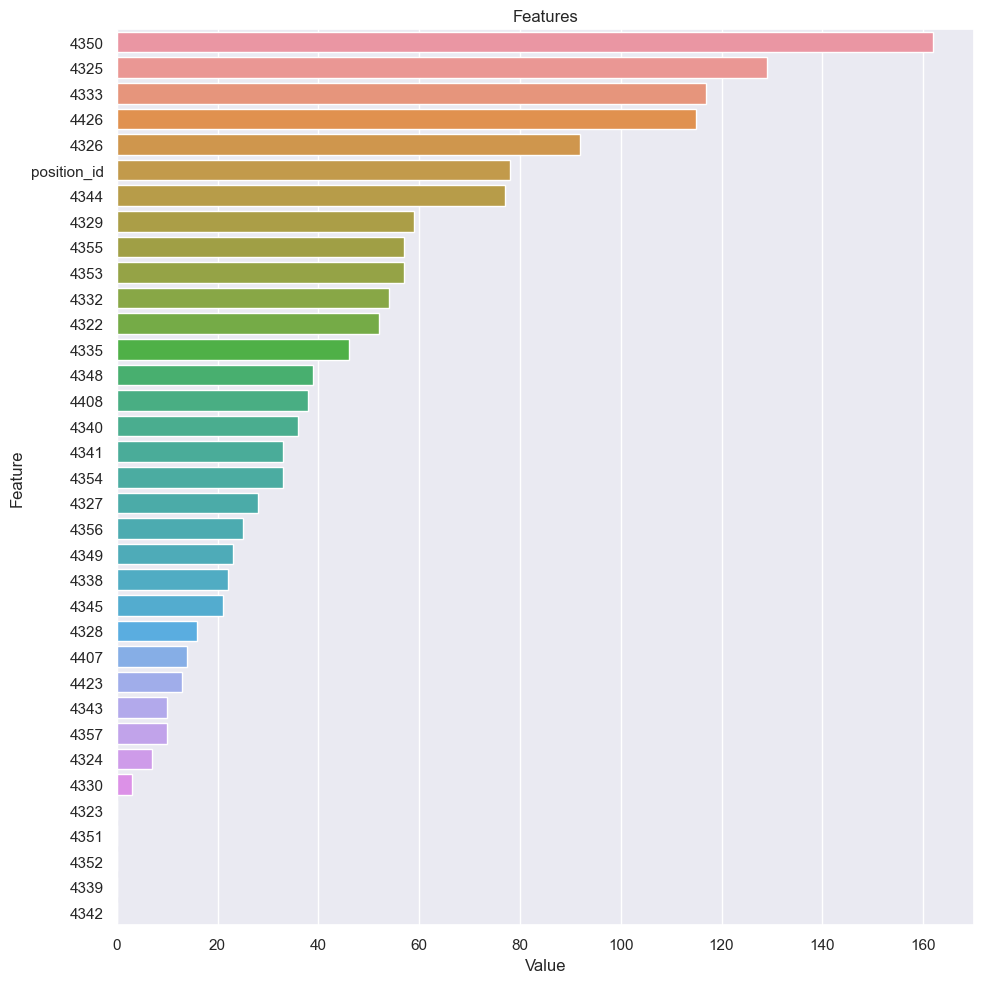

In [82]:
plot_importance(lgbm_model, X)

# Hyperparameter Optimization for XGBOOST

In [75]:
xgb = XGBClassifier()
xgb_params = {
    "learning_rate": [0.01, 0.1, 0.15],
    "max_depth":[3,5,8],
    "max_features":["log2","sqrt"],
    "subsample":[0.5, 0.8, 1.0],
    "n_estimators": [50, 100, 150, 200]}
xgb_gs_best = GridSearchCV(xgb, xgb_params, cv=6, n_jobs=-1).fit(X_train, y_train)

/Users/mustafaemircan/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [01:01:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "max_features" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/mustafaemircan/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [01:01:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "max_features" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/mustafaemircan/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [01:01:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "max_features" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/mustafaemircan/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [01:01:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "max_features" } are not used.

  warnings.warn(smsg, UserW

In [76]:
xgb = XGBClassifier(**xgb_gs_best.best_params_)
xgb.fit(X_train, y_train)
xgb.score(X_test, y_test)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_features='log2',
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=50,
              n_jobs=None, num_parallel_tree=None, ...)

0.8363636363636363

In [77]:
xgb_pred=xgb.predict(X_test)
xgb_pred[:20]

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0])

In [78]:
accuracy = accuracy_score(y_test, xgb_pred)
precision = precision_score(y_test, xgb_pred)
recall = recall_score(y_test, xgb_pred)
f1 = f1_score(y_test, xgb_pred)

print(f"Accuracy: {round(accuracy, 3)}")
print(f"Precision: {round(precision, 3)}")
print(f"Recall: {round(recall, 3)}")
print(f"F1 Score: {round(f1, 3)}")

Accuracy: 0.836
Precision: 0.75
Recall: 0.273
F1 Score: 0.4


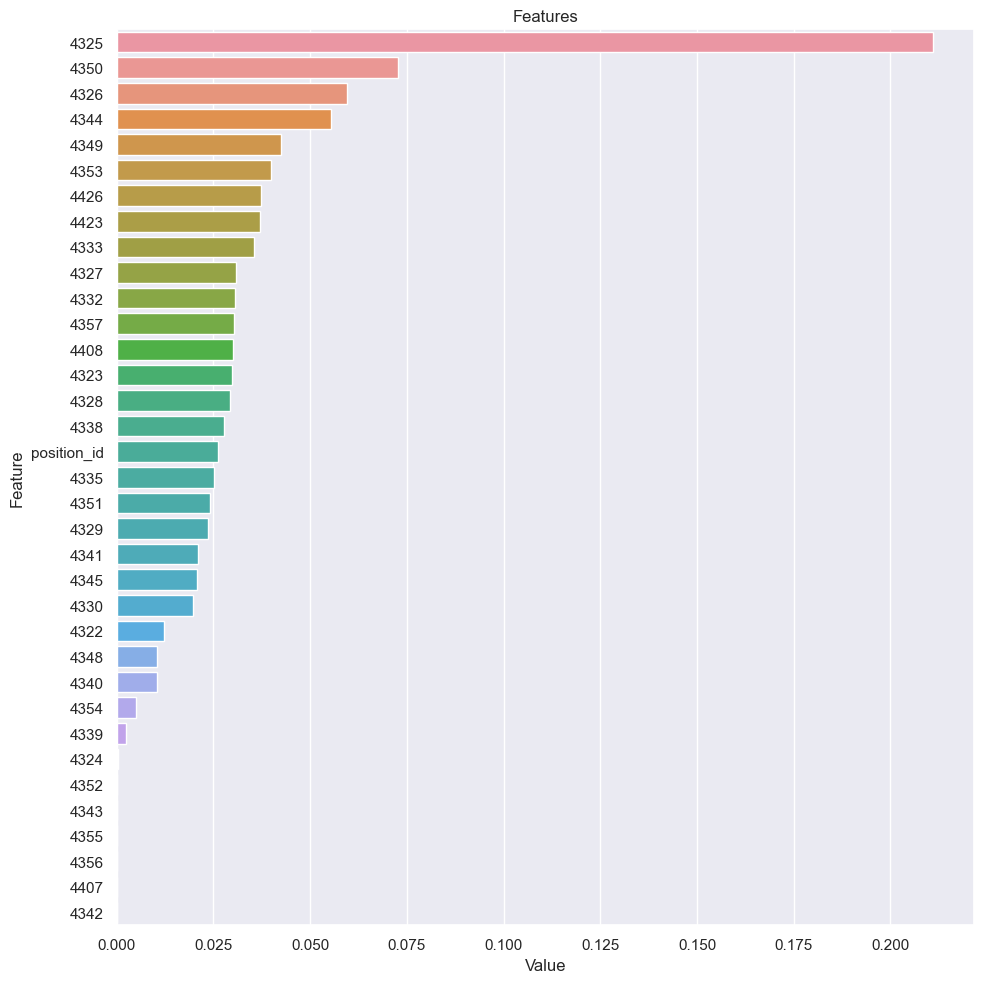

In [80]:
plot_importance(xgb, X)

# THANKS.